In [ ]:
!pip install grad-cam lime opencv-python scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.3 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=3fb2ba338476eae6ab142851c9425341cb9dba2d0cf88e95b97004b2fa276a77
  Stored in directory: /root/.cache/pip/wheels/3d/b6/be/e13cccebb2aa8855f678b02ad449e803de1dfbe75853c34b3e
Successfully built grad-cam


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
import os
import time
import copy
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.init as init
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
import cv2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import traceback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils import resample 
import torchvision 
import timm 
import time 
import copy 
import traceback 

In [ ]:
# --- Configuration ---
DATA_DIR = '/kaggle/input/cervical-cancer-largest-dataset-sipakmed'
MODEL_SAVE_DIR = '/kaggle/working/models'
NUM_CLASSES = 5 
IMAGE_SIZE = 64 
BATCH_SIZE = 64
criterion = nn.CrossEntropyLoss()
LEARNING_RATE_FINETUNE_CLASSIFIER = 1e-4
LEARNING_RATE_FINETUNE_BACKBONE = 1e-5

In [6]:
# Data Split Percentages
TRAIN_PERCENTAGE = 0.70
VAL_PERCENTAGE = 0.15
TEST_PERCENTAGE = 0.15

In [ ]:
# Reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
   
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [ ]:

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

In [9]:
# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# --- Defining ImageNet Normalization ---
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
# --- Preprocessing ---
print("\n--- Defining Data Transforms with ImageNet Normalization ---")

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
    transforms.ToTensor(),                       
   
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
print("Transforms defined.")

try:
    temp_dataset = datasets.ImageFolder(root=DATA_DIR)
    class_names = temp_dataset.classes
    dataset_size = len(temp_dataset)

    print(f"Found dataset structure with {dataset_size} images.")
    print(f"Classes: {class_names}")
    if len(class_names) != NUM_CLASSES:
        print(f"Warning: Expected {NUM_CLASSES} classes, but found {len(class_names)} in {DATA_DIR}")

except FileNotFoundError:
    print(f"Error: Dataset directory not found at {DATA_DIR}")
    exit()
except Exception as e:
    print(f"Error scanning dataset: {e}")
    exit()

# --- Split Indices ---
indices = list(range(dataset_size))
random.Random(RANDOM_SEED).shuffle(indices) 

train_size = int(TRAIN_PERCENTAGE * dataset_size)
val_size = int(VAL_PERCENTAGE * dataset_size)
test_size = dataset_size - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]


generator = torch.Generator().manual_seed(RANDOM_SEED) 

print("\nLoading Training Dataset with Augmentation & Normalization...")

train_val_dataset_augmented = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)

print("Loading Validation/Test Dataset without Augmentation but with Normalization...")

test_dataset_clean = datasets.ImageFolder(root=DATA_DIR, transform=val_test_transforms)


train_dataset_aug, _ , _ = random_split(
    train_val_dataset_augmented, [train_size, val_size, test_size], generator=generator
)
_, val_dataset_clean, test_dataset_clean_final = random_split(
   test_dataset_clean, [train_size, val_size, test_size], generator=generator
)

train_dataset = train_dataset_aug
val_dataset = val_dataset_clean
test_dataset = test_dataset_clean_final 

print(f"\nApplying Updated Transforms:")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if device=='cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if device=='cuda' else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if device=='cuda' else False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

print("\nDataLoaders created with normalized data.")


--- Defining Data Transforms with ImageNet Normalization ---
Transforms defined.
Found dataset structure with 5015 images.
Classes: ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']

Loading Training Dataset with Augmentation & Normalization...
Loading Validation/Test Dataset without Augmentation but with Normalization...

Applying Updated Transforms:
Training set size: 3510
Validation set size: 752
Test set size: 753

DataLoaders created with normalized data.


In [11]:
EPOCHS_FINETUNE = 99

In [ ]:
def train_model(model, model_name, criterion, optimizer, dataloaders, dataset_sizes, scheduler=None, num_epochs=25, patience=10): # Add scheduler and patience
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    epochs_no_improve = 0
    early_stop_triggered = False

    print(f'\n--- Training {model_name} ---')
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            loader = dataloaders[phase]
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else: 
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                if epoch_acc > best_acc:
                    print(f"Validation accuracy improved ({best_acc:.4f} --> {epoch_acc:.4f}). Saving model...")
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                
                    save_path = os.path.join(MODEL_SAVE_DIR, f'{model_name}_best.pth')
                    torch.save(model.state_dict(), save_path)
                    print(f"Saved best model weights to {save_path}") 
                    epochs_no_improve = 0 
                else:
                    epochs_no_improve += 1
                    print(f"Validation accuracy did not improve for {epochs_no_improve} epoch(s).")

        if scheduler:
             
             if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                 scheduler.step(history['val_acc'][-1]) 
             
             current_lr = optimizer.param_groups[0]['lr']
             print(f"Current learning rate: {current_lr:.6f}") 
        
        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs.')
            early_stop_triggered = True
            break 
    
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    if early_stop_triggered:
        print(f"Stopped early due to no improvement in validation accuracy for {patience} epochs.")
    print(f'Best val Acc for {model_name}: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
# --- Evaluation Function ---
def evaluate_model(model, model_name, loader, class_names, criterion): 
    """
    Evaluates a trained model on a given data loader.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        model_name (str): Name of the model for printing/saving.
        loader (DataLoader): DataLoader for the evaluation set (e.g., test_loader).
        class_names (list): List of class names for reporting.
        criterion (torch.nn.Module): The loss function used during training (optional for eval, but used here for loss).

    Returns:
        float: The accuracy of the model on the loader dataset.
    """
    model.eval() 
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    print(f'\n--- Evaluating {model_name} on Test Set ---')
    with torch.no_grad(): 
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    dataset_len = len(loader.dataset)
    if dataset_len == 0:
        print("Warning: Evaluation dataset is empty.")
        return 0.0

    test_loss = running_loss / dataset_len if criterion else float('nan') 
    test_acc = running_corrects.double() / dataset_len

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

    print("\nClassification Report:")
    try:
        if class_names and len(class_names) > 0:
             print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))
        else:
             print(classification_report(all_labels, all_preds, digits=4, zero_division=0))
    except Exception as e:
        print(f"Could not generate classification report: {e}")

    print("\nConfusion Matrix:")
    try:
        cm = confusion_matrix(all_labels, all_preds)
        print(cm)

        plt.figure(figsize=(8, 6))
        tick_labels = class_names if class_names and len(class_names) > 0 else True
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.savefig(f'{model_name}_confusion_matrix.png') 
        plt.show() 
        plt.close() 
    except Exception as e:
        print(f"Could not generate/save confusion matrix plot: {e}")


    return test_acc.item()

In [14]:
try:
    import timm
    timm_available = True
except ImportError:
    timm_available = False
    print("Warning: 'timm' library not found. EfficientNet fine-tuning will be skipped.")
    print("Install using: pip install timm")

In [ ]:
# --- 1. Fine-tune AlexNet (Unfreezing Layers + Differential LR) ---
print("\n--- Setting up AlexNet for Fine-tuning (Diff LR) ---") 
try:
    weights_alexnet = models.AlexNet_Weights.DEFAULT
    model_alexnet_pt = models.alexnet(weights=weights_alexnet)
    print("Loaded pre-trained AlexNet.")

    for param in model_alexnet_pt.parameters():
        param.requires_grad = False
    print("Initially froze all AlexNet layers.")

    num_ftrs_alexnet = model_alexnet_pt.classifier[6].in_features
    model_alexnet_pt.classifier[6] = nn.Linear(num_ftrs_alexnet, NUM_CLASSES)
    print(f"Replaced AlexNet classifier for {NUM_CLASSES} classes.")

    layers_to_unfreeze_names = ['features.10', 'classifier.4', 'classifier.6'] 
    print(f"Unfreezing AlexNet layers: {layers_to_unfreeze_names}")
    params_backbone = []
    params_classifier = []
    for name, param in model_alexnet_pt.named_parameters():
        should_unfreeze = False
        for layer_name in layers_to_unfreeze_names:
             if name.startswith(layer_name):
                 should_unfreeze = True
                 break

        if should_unfreeze:
            param.requires_grad = True
            if name.startswith('classifier.6'): 
                 params_classifier.append(param)
                 print(f"  Unfreezing (classifier LR): {name}")
            else: 
                 params_backbone.append(param)
                 print(f"  Unfreezing (backbone LR): {name}")
        else:
             param.requires_grad = False

    model_alexnet_pt.to(device)

    LR_CLASSIFIER = LEARNING_RATE_FINETUNE_CLASSIFIER 
    LR_BACKBONE = LEARNING_RATE_FINETUNE_BACKBONE   
    print(f"Setting up optimizer with LR_CLASSIFIER={LR_CLASSIFIER}, LR_BACKBONE={LR_BACKBONE}")
    optimizer_alexnet_ft = optim.AdamW([
        {'params': params_backbone, 'lr': LR_BACKBONE},
        {'params': params_classifier, 'lr': LR_CLASSIFIER}
    ], weight_decay=1e-4)

    scheduler_alexnet_ft = ReduceLROnPlateau(optimizer_alexnet_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for AlexNet differential fine-tuning.")

    print("\n--- Starting AlexNet Fine-tuning (Diff LR) ---")
    model_alexnet_pt, history_alexnet_ft = train_model(
        model=model_alexnet_pt,
        model_name="AlexNet_DiffLR", 
        criterion=criterion,
        optimizer=optimizer_alexnet_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_alexnet_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- AlexNet Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during AlexNet fine-tuning setup or training: {e}")
    traceback.print_exc()



--- Setting up AlexNet for Fine-tuning (Diff LR) ---


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 199MB/s] 


Loaded pre-trained AlexNet.
Initially froze all AlexNet layers.
Replaced AlexNet classifier for 5 classes.
Unfreezing AlexNet layers: ['features.10', 'classifier.4', 'classifier.6']
  Unfreezing (backbone LR): features.10.weight
  Unfreezing (backbone LR): features.10.bias
  Unfreezing (backbone LR): classifier.4.weight
  Unfreezing (backbone LR): classifier.4.bias
  Unfreezing (classifier LR): classifier.6.weight
  Unfreezing (classifier LR): classifier.6.bias
Setting up optimizer with LR_CLASSIFIER=0.0001, LR_BACKBONE=1e-05
Optimizer and scheduler configured for AlexNet differential fine-tuning.

--- Starting AlexNet Fine-tuning (Diff LR) ---

--- Training AlexNet_DiffLR ---
Epoch 1/99
----------
Train Loss: 0.9960 Acc: 0.6185
Val Loss: 0.5285 Acc: 0.8085
Validation accuracy improved (0.0000 --> 0.8085). Saving model...
Saved best model weights to /kaggle/working/models/AlexNet_DiffLR_best.pth
Current learning rate: 0.000010
Epoch 2/99
----------
Train Loss: 0.5400 Acc: 0.8014
Val Lo

In [ ]:
# --- 2. Fine-tune SqueezeNet 1.1 (Unfreezing Layers + Differential LR) ---
print("\n--- Setting up SqueezeNet 1.1 for Fine-tuning (Diff LR) ---") 
try:
    weights_squeezenet = models.SqueezeNet1_1_Weights.DEFAULT
    model_squeezenet_pt = models.squeezenet1_1(weights=weights_squeezenet)
    print("Loaded pre-trained SqueezeNet 1.1.")

    for param in model_squeezenet_pt.parameters():
        param.requires_grad = False
    print("Initially froze all SqueezeNet layers.")

    num_in_channels_squeezenet = model_squeezenet_pt.classifier[1].in_channels
    model_squeezenet_pt.classifier[1] = nn.Conv2d(num_in_channels_squeezenet, NUM_CLASSES, kernel_size=1)
    model_squeezenet_pt.num_classes = NUM_CLASSES
    print(f"Replaced SqueezeNet classifier for {NUM_CLASSES} classes.")

    layers_to_unfreeze_names = ['features.10', 'features.11', 'features.12', 'classifier.1'] 
    print(f"Unfreezing SqueezeNet layers: {layers_to_unfreeze_names}")
    params_backbone = []
    params_classifier = []
    for name, param in model_squeezenet_pt.named_parameters():
        should_unfreeze = False
        for layer_name in layers_to_unfreeze_names:
             if name.startswith(layer_name):
                 should_unfreeze = True
                 break
        if should_unfreeze:
            param.requires_grad = True
            if name.startswith('classifier.1'): 
                 params_classifier.append(param)
                 print(f"  Unfreezing (classifier LR): {name}")
            else: 
                 params_backbone.append(param)
                 print(f"  Unfreezing (backbone LR): {name}")
        else:
             param.requires_grad = False
   
    model_squeezenet_pt.to(device)

    LR_CLASSIFIER = LEARNING_RATE_FINETUNE_CLASSIFIER 
    LR_BACKBONE = LEARNING_RATE_FINETUNE_BACKBONE   
    print(f"Setting up optimizer with LR_CLASSIFIER={LR_CLASSIFIER}, LR_BACKBONE={LR_BACKBONE}")
    optimizer_squeezenet_ft = optim.AdamW([
        {'params': params_backbone, 'lr': LR_BACKBONE},
        {'params': params_classifier, 'lr': LR_CLASSIFIER}
    ], weight_decay=2e-4) 

    scheduler_squeezenet_ft = ReduceLROnPlateau(optimizer_squeezenet_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for SqueezeNet differential fine-tuning.")

    print("\n--- Starting SqueezeNet 1.1 Fine-tuning (Diff LR) ---")

    model_squeezenet_pt, history_squeezenet_ft = train_model(
        model=model_squeezenet_pt,
        model_name="SqueezeNet1.1_DiffLR", 
        criterion=criterion,
        optimizer=optimizer_squeezenet_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_squeezenet_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- SqueezeNet 1.1 Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during SqueezeNet fine-tuning setup or training: {e}")
    traceback.print_exc()

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth



--- Setting up SqueezeNet 1.1 for Fine-tuning (Diff LR) ---


100%|██████████| 4.73M/4.73M [00:00<00:00, 25.5MB/s]


Loaded pre-trained SqueezeNet 1.1.
Initially froze all SqueezeNet layers.
Replaced SqueezeNet classifier for 5 classes.
Unfreezing SqueezeNet layers: ['features.10', 'features.11', 'features.12', 'classifier.1']
  Unfreezing (backbone LR): features.10.squeeze.weight
  Unfreezing (backbone LR): features.10.squeeze.bias
  Unfreezing (backbone LR): features.10.expand1x1.weight
  Unfreezing (backbone LR): features.10.expand1x1.bias
  Unfreezing (backbone LR): features.10.expand3x3.weight
  Unfreezing (backbone LR): features.10.expand3x3.bias
  Unfreezing (backbone LR): features.11.squeeze.weight
  Unfreezing (backbone LR): features.11.squeeze.bias
  Unfreezing (backbone LR): features.11.expand1x1.weight
  Unfreezing (backbone LR): features.11.expand1x1.bias
  Unfreezing (backbone LR): features.11.expand3x3.weight
  Unfreezing (backbone LR): features.11.expand3x3.bias
  Unfreezing (backbone LR): features.12.squeeze.weight
  Unfreezing (backbone LR): features.12.squeeze.bias
  Unfreezing (ba

In [ ]:
# ==========================================================
# --- 3. Fine-tune ResNet50 (Unfreezing Layer4 + Differential LR) ---
# ==========================================================
print("\n--- Setting up ResNet50 for Fine-tuning (Layer4 + FC, Differential LR) ---")
try:
    weights_resnet50 = models.ResNet50_Weights.DEFAULT
    model_resnet50_pt = models.resnet50(weights=weights_resnet50)
    print("Loaded pre-trained ResNet50.")

    for param in model_resnet50_pt.parameters():
        param.requires_grad = False
    layers_to_unfreeze = ['layer4', 'fc']
    print(f"Initially froze all layers. Planning to unfreeze: {layers_to_unfreeze}")

    num_ftrs_resnet50 = model_resnet50_pt.fc.in_features
    model_resnet50_pt.fc = nn.Linear(num_ftrs_resnet50, NUM_CLASSES)
    print(f"Replaced ResNet50 classifier ('fc') for {NUM_CLASSES} classes.")

    print("Unfreezing specified layers (layer4, fc)...")
    unfrozen_params_count = 0
    params_to_optimize = []
    params_backbone = []
    if 'layer4' in layers_to_unfreeze:
        print("  Unfreezing: layer4")
        for param in model_resnet50_pt.layer4.parameters():
            param.requires_grad = True
            params_backbone.append(param)
            unfrozen_params_count += param.numel()
    if params_backbone: 
        params_to_optimize.append({'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE})

    params_classifier = []
    if 'fc' in layers_to_unfreeze: 
         print("  Unfreezing: fc")
         for param in model_resnet50_pt.fc.parameters():
             param.requires_grad = True
             params_classifier.append(param)
             unfrozen_params_count += param.numel()
    if params_classifier:
        params_to_optimize.append({'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER})

    print(f"Total parameters to be trained: {unfrozen_params_count}")

    model_resnet50_pt.to(device)

    LR_CLASSIFIER = LEARNING_RATE_FINETUNE_CLASSIFIER 
    LR_BACKBONE = LEARNING_RATE_FINETUNE_BACKBONE   
    print(f"Setting up optimizer with LR_CLASSIFIER={LR_CLASSIFIER}, LR_BACKBONE={LR_BACKBONE}")
    optimizer_resnet50_ft = optim.AdamW(params_to_optimize, weight_decay=1e-4) 

    scheduler_resnet50_ft = ReduceLROnPlateau(optimizer_resnet50_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for ResNet50 differential fine-tuning.")

    print("\n--- Starting ResNet50 Fine-tuning (Layer4 + FC) ---")
    model_resnet50_pt, history_resnet50_ft = train_model(
        model=model_resnet50_pt,
        model_name="ResNet50_DiffLR", 
        criterion=criterion,
        optimizer=optimizer_resnet50_ft, 
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_resnet50_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- ResNet50 Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during ResNet50 fine-tuning setup or training: {e}")
    traceback.print_exc()


--- Setting up ResNet50 for Fine-tuning (Layer4 + FC, Differential LR) ---
Loaded pre-trained ResNet50.
Initially froze all layers. Planning to unfreeze: ['layer4', 'fc']
Replaced ResNet50 classifier ('fc') for 5 classes.
Unfreezing specified layers (layer4, fc)...
  Unfreezing: layer4
  Unfreezing: fc
Total parameters to be trained: 14974981
Setting up optimizer with LR_CLASSIFIER=0.0001, LR_BACKBONE=1e-05
Optimizer and scheduler configured for ResNet50 differential fine-tuning.

--- Starting ResNet50 Fine-tuning (Layer4 + FC) ---

--- Training ResNet50_DiffLR ---
Epoch 1/99
----------
Train Loss: 1.5377 Acc: 0.3282
Val Loss: 1.4065 Acc: 0.4880
Validation accuracy improved (0.0000 --> 0.4880). Saving model...
Saved best model weights to /kaggle/working/models/ResNet50_DiffLR_best.pth
Current learning rate: 0.000010
Epoch 2/99
----------
Train Loss: 1.3222 Acc: 0.5598
Val Loss: 1.1641 Acc: 0.6636
Validation accuracy improved (0.4880 --> 0.6636). Saving model...
Saved best model weight

In [ ]:
# ==========================================================
# --- Fine-tune ResNet101 ---
# ==========================================================
print("\n" + "="*50)
print("--- Setting up ResNet101 for Fine-tuning (Diff LR) ---")
print("="*50)
try:
    model_resnet101_pt = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
    print("Loaded pre-trained ResNet101.")

    for param in model_resnet101_pt.parameters():
        param.requires_grad = False
    layers_to_unfreeze = ['layer4', 'fc']
    print(f"Initially froze all layers. Planning to unfreeze: {layers_to_unfreeze}")

    num_ftrs_resnet101 = model_resnet101_pt.fc.in_features
    model_resnet101_pt.fc = nn.Linear(num_ftrs_resnet101, NUM_CLASSES)
    print(f"Replaced ResNet101 classifier ('fc') for {NUM_CLASSES} classes.")

    print("Unfreezing specified layers (layer4, fc)...")
    params_to_optimize = []
    params_backbone = []
    if 'layer4' in layers_to_unfreeze:
        print("  Unfreezing: layer4")
        for param in model_resnet101_pt.layer4.parameters():
            param.requires_grad = True
            params_backbone.append(param)
    if params_backbone:
        params_to_optimize.append({'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE})

    params_classifier = []
    if 'fc' in layers_to_unfreeze:
         print("  Unfreezing: fc")
         for param in model_resnet101_pt.fc.parameters():
             param.requires_grad = True
             params_classifier.append(param)
    if params_classifier:
        params_to_optimize.append({'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER})

    model_resnet101_pt.to(device)

    print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
    optimizer_resnet101_ft = optim.AdamW(params_to_optimize, weight_decay=1e-4)

    scheduler_resnet101_ft = ReduceLROnPlateau(optimizer_resnet101_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for ResNet101 differential fine-tuning.")

    print("\n--- Starting ResNet101 Fine-tuning (Layer4 + FC) ---")
    model_resnet101_pt, history_resnet101_ft = train_model(
        model=model_resnet101_pt,
        model_name="ResNet101_DiffLR",
        criterion=criterion,
        optimizer=optimizer_resnet101_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_resnet101_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- ResNet101 Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during ResNet101 fine-tuning setup or training: {e}")
    traceback.print_exc()


--- Setting up ResNet101 for Fine-tuning (Diff LR) ---


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 93.0MB/s] 


Loaded pre-trained ResNet101.
Initially froze all layers. Planning to unfreeze: ['layer4', 'fc']
Replaced ResNet101 classifier ('fc') for 5 classes.
Unfreezing specified layers (layer4, fc)...
  Unfreezing: layer4
  Unfreezing: fc
Setting up optimizer with LR_CLASSIFIER=0.0001, LR_BACKBONE=1e-05
Optimizer and scheduler configured for ResNet101 differential fine-tuning.

--- Starting ResNet101 Fine-tuning (Layer4 + FC) ---

--- Training ResNet101_DiffLR ---
Epoch 1/99
----------
Train Loss: 1.5397 Acc: 0.3328
Val Loss: 1.3935 Acc: 0.4827
Validation accuracy improved (0.0000 --> 0.4827). Saving model...
Saved best model weights to /kaggle/working/models/ResNet101_DiffLR_best.pth
Current learning rate: 0.000010
Epoch 2/99
----------
Train Loss: 1.2970 Acc: 0.5607
Val Loss: 1.2169 Acc: 0.6516
Validation accuracy improved (0.4827 --> 0.6516). Saving model...
Saved best model weights to /kaggle/working/models/ResNet101_DiffLR_best.pth
Current learning rate: 0.000010
Epoch 3/99
----------
Tra

In [ ]:
# --- Fine-tune VGG16 ---
print("\n" + "="*50)
print("--- Setting up VGG16 for Fine-tuning (Diff LR) ---")
print("="*50)
try:
    model_vgg16_pt = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    print("Loaded pre-trained VGG16.")

    for param in model_vgg16_pt.parameters():
        param.requires_grad = False
    print("Initially froze all VGG16 layers.")

    num_ftrs_vgg = model_vgg16_pt.classifier[6].in_features
    model_vgg16_pt.classifier[6] = nn.Linear(num_ftrs_vgg, NUM_CLASSES)
    print(f"Replaced VGG16 classifier for {NUM_CLASSES} classes.")

    layers_to_unfreeze_names = ['features.24', 'features.26', 'features.28', 'classifier'] # Example
    print(f"Unfreezing VGG16 layers: {layers_to_unfreeze_names}")
    params_backbone = []
    params_classifier = []
    for name, param in model_vgg16_pt.named_parameters():
        should_unfreeze = False
        for layer_name in layers_to_unfreeze_names:
             if name.startswith(layer_name):
                 should_unfreeze = True
                 break
        if should_unfreeze:
            param.requires_grad = True
            if name.startswith('classifier.6'):
                 params_classifier.append(param)
                 print(f"  Unfreezing (classifier LR): {name}")
            else:
                 params_backbone.append(param)
                 print(f"  Unfreezing (backbone LR): {name}")
        else:
             param.requires_grad = False

    model_vgg16_pt.to(device)

    print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
    optimizer_vgg16_ft = optim.AdamW([
        {'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE},
        {'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER}
    ], weight_decay=1e-4)

    scheduler_vgg16_ft = ReduceLROnPlateau(optimizer_vgg16_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for VGG16 differential fine-tuning.")

    print("\n--- Starting VGG16 Fine-tuning (Diff LR) ---")
    model_vgg16_pt, history_vgg16_ft = train_model(
        model=model_vgg16_pt,
        model_name="VGG16_DiffLR",
        criterion=criterion,
        optimizer=optimizer_vgg16_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_vgg16_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- VGG16 Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during VGG16 fine-tuning setup or training: {e}")
    traceback.print_exc()


--- Setting up VGG16 for Fine-tuning (Diff LR) ---


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s] 


Loaded pre-trained VGG16.
Initially froze all VGG16 layers.
Replaced VGG16 classifier for 5 classes.
Unfreezing VGG16 layers: ['features.24', 'features.26', 'features.28', 'classifier']
  Unfreezing (backbone LR): features.24.weight
  Unfreezing (backbone LR): features.24.bias
  Unfreezing (backbone LR): features.26.weight
  Unfreezing (backbone LR): features.26.bias
  Unfreezing (backbone LR): features.28.weight
  Unfreezing (backbone LR): features.28.bias
  Unfreezing (backbone LR): classifier.0.weight
  Unfreezing (backbone LR): classifier.0.bias
  Unfreezing (backbone LR): classifier.3.weight
  Unfreezing (backbone LR): classifier.3.bias
  Unfreezing (classifier LR): classifier.6.weight
  Unfreezing (classifier LR): classifier.6.bias
Setting up optimizer with LR_CLASSIFIER=0.0001, LR_BACKBONE=1e-05
Optimizer and scheduler configured for VGG16 differential fine-tuning.

--- Starting VGG16 Fine-tuning (Diff LR) ---

--- Training VGG16_DiffLR ---
Epoch 1/99
----------
Train Loss: 1.09

In [ ]:
# ==========================================================
# --- Fine-tune DenseNet169 ---
# ==========================================================
print("\n" + "="*50)
print("--- Setting up DenseNet169 for Fine-tuning (Diff LR) ---")
print("="*50)
try:
    model_densenet169_pt = models.densenet169(weights=models.DenseNet169_Weights.DEFAULT)
    print("Loaded pre-trained DenseNet169.")

    for param in model_densenet169_pt.parameters():
        param.requires_grad = False
    print("Initially froze all DenseNet169 layers.")

    num_ftrs_densenet = model_densenet169_pt.classifier.in_features
    model_densenet169_pt.classifier = nn.Linear(num_ftrs_densenet, NUM_CLASSES)
    print(f"Replaced DenseNet169 classifier for {NUM_CLASSES} classes.")

    layers_to_unfreeze_names = ['features.denseblock4', 'features.norm5', 'classifier']
    print(f"Unfreezing DenseNet169 layers: {layers_to_unfreeze_names}")
    params_backbone = []
    params_classifier = []
    for name, param in model_densenet169_pt.named_parameters():
        should_unfreeze = False
        for layer_name in layers_to_unfreeze_names:
             if name.startswith(layer_name):
                 should_unfreeze = True
                 break
        if should_unfreeze:
            param.requires_grad = True
            if name.startswith('classifier'): 
                 params_classifier.append(param)
                 print(f"  Unfreezing (classifier LR): {name}")
            else: 
                 params_backbone.append(param)
                 print(f"  Unfreezing (backbone LR): {name}")
        else:
             param.requires_grad = False

    model_densenet169_pt.to(device)

    print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
    optimizer_densenet169_ft = optim.AdamW([
        {'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE},
        {'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER}
    ], weight_decay=1e-4)

    scheduler_densenet169_ft = ReduceLROnPlateau(optimizer_densenet169_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for DenseNet169 differential fine-tuning.")

    print("\n--- Starting DenseNet169 Fine-tuning (Diff LR) ---")
    model_densenet169_pt, history_densenet169_ft = train_model(
        model=model_densenet169_pt,
        model_name="DenseNet169_DiffLR",
        criterion=criterion,
        optimizer=optimizer_densenet169_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_densenet169_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- DenseNet169 Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during DenseNet169 fine-tuning setup or training: {e}")
    traceback.print_exc()


--- Setting up DenseNet169 for Fine-tuning (Diff LR) ---


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 93.7MB/s]


Loaded pre-trained DenseNet169.
Initially froze all DenseNet169 layers.
Replaced DenseNet169 classifier for 5 classes.
Unfreezing DenseNet169 layers: ['features.denseblock4', 'features.norm5', 'classifier']
  Unfreezing (backbone LR): features.denseblock4.denselayer1.norm1.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer1.norm1.bias
  Unfreezing (backbone LR): features.denseblock4.denselayer1.conv1.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer1.norm2.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer1.norm2.bias
  Unfreezing (backbone LR): features.denseblock4.denselayer1.conv2.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer2.norm1.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer2.norm1.bias
  Unfreezing (backbone LR): features.denseblock4.denselayer2.conv1.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer2.norm2.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer

In [ ]:
# ==========================================================
# --- Fine-tune EfficientNet-B3 (using timm) ---
# ==========================================================
print("\n" + "="*50)
print("--- Setting up EfficientNet-B3 for Fine-tuning (Diff LR) ---")
print("="*50)
if timm_available:
    try:
        model_effnet_pt = timm.create_model('efficientnet_b3', pretrained=True)
        print("Loaded pre-trained EfficientNet-B3 using timm.")

        for param in model_effnet_pt.parameters():
            param.requires_grad = False
        print("Initially froze all EfficientNet-B3 layers.")

        if hasattr(model_effnet_pt, 'classifier'):
            num_ftrs_effnet = model_effnet_pt.classifier.in_features
            model_effnet_pt.classifier = nn.Linear(num_ftrs_effnet, NUM_CLASSES)
            classifier_layer_name = 'classifier'
        elif hasattr(model_effnet_pt, 'fc'):
            num_ftrs_effnet = model_effnet_pt.fc.in_features
            model_effnet_pt.fc = nn.Linear(num_ftrs_effnet, NUM_CLASSES)
            classifier_layer_name = 'fc'
        else:
             raise AttributeError("Cannot find classifier layer ('classifier' or 'fc') in EfficientNet model.")
        print(f"Replaced EfficientNet-B3 classifier ('{classifier_layer_name}') for {NUM_CLASSES} classes.")

        layers_to_unfreeze_names = ['blocks.5', 'blocks.6', classifier_layer_name]
        print(f"Unfreezing EfficientNet-B3 layers: {layers_to_unfreeze_names}")
        params_backbone = []
        params_classifier = []
        for name, param in model_effnet_pt.named_parameters():
            should_unfreeze = False
            for layer_name in layers_to_unfreeze_names:
                 if name.startswith(layer_name):
                     should_unfreeze = True
                     break
            if should_unfreeze:
                param.requires_grad = True
                if name.startswith(classifier_layer_name): 
                     params_classifier.append(param)
                     print(f"  Unfreezing (classifier LR): {name}")
                else: 
                     params_backbone.append(param)
                     print(f"  Unfreezing (backbone LR): {name}")
            else:
                 param.requires_grad = False

        model_effnet_pt.to(device)

        print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
        optimizer_effnet_ft = optim.AdamW([
            {'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE},
            {'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER}
        ], weight_decay=1e-4) 

        scheduler_effnet_ft = ReduceLROnPlateau(optimizer_effnet_ft, mode='max', factor=0.1, patience=5)
        print("Optimizer and scheduler configured for EfficientNet-B3 differential fine-tuning.")

        print("\n--- Starting EfficientNet-B3 Fine-tuning (Diff LR) ---")
        model_effnet_pt, history_effnet_ft = train_model(
            model=model_effnet_pt,
            model_name="EfficientNetB3_DiffLR",
            criterion=criterion,
            optimizer=optimizer_effnet_ft,
            dataloaders=dataloaders,
            dataset_sizes=dataset_sizes,
            scheduler=scheduler_effnet_ft,
            num_epochs=EPOCHS_FINETUNE,
            patience=30
        )
        print("--- EfficientNet-B3 Fine-tuning Finished ---")

    except Exception as e:
        print(f"Error during EfficientNet-B3 fine-tuning setup or training: {e}")
        traceback.print_exc()
else:
    print("Skipping EfficientNet fine-tuning because 'timm' library is not available.")


--- Setting up EfficientNet-B3 for Fine-tuning (Diff LR) ---


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Loaded pre-trained EfficientNet-B3 using timm.
Initially froze all EfficientNet-B3 layers.
Replaced EfficientNet-B3 classifier ('classifier') for 5 classes.
Unfreezing EfficientNet-B3 layers: ['blocks.5', 'blocks.6', 'classifier']
  Unfreezing (backbone LR): blocks.5.0.conv_pw.weight
  Unfreezing (backbone LR): blocks.5.0.bn1.weight
  Unfreezing (backbone LR): blocks.5.0.bn1.bias
  Unfreezing (backbone LR): blocks.5.0.conv_dw.weight
  Unfreezing (backbone LR): blocks.5.0.bn2.weight
  Unfreezing (backbone LR): blocks.5.0.bn2.bias
  Unfreezing (backbone LR): blocks.5.0.se.conv_reduce.weight
  Unfreezing (backbone LR): blocks.5.0.se.conv_reduce.bias
  Unfreezing (backbone LR): blocks.5.0.se.conv_expand.weight
  Unfreezing (backbone LR): blocks.5.0.se.conv_expand.bias
  Unfreezing (backbone LR): blocks.5.0.conv_pwl.weight
  Unfreezing (backbone LR): blocks.5.0.bn3.weight
  Unfreezing (backbone LR): blocks.5.0.bn3.bias
  Unfreezing (backbone LR): blocks.5.1.conv_pw.weight
  Unfreezing (back

In [ ]:
# ==========================================================
# --- Fine-tune VGG19 ---
# ==========================================================
print("\n" + "="*50)
print("--- Setting up VGG19 for Fine-tuning (Diff LR) ---")
print("="*50)
try:
    model_vgg19_pt = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    print("Loaded pre-trained VGG19.")

    for param in model_vgg19_pt.parameters():
        param.requires_grad = False
    print("Initially froze all VGG19 layers.")

    num_ftrs_vgg = model_vgg19_pt.classifier[6].in_features
    model_vgg19_pt.classifier[6] = nn.Linear(num_ftrs_vgg, NUM_CLASSES)
    print(f"Replaced VGG19 classifier for {NUM_CLASSES} classes.")

    layers_to_unfreeze_names = ['features.30', 'features.32', 'features.34', 'classifier'] # Example
    print(f"Unfreezing VGG19 layers: {layers_to_unfreeze_names}")
    params_backbone = []
    params_classifier = []
    for name, param in model_vgg19_pt.named_parameters():
        should_unfreeze = False
        for layer_name in layers_to_unfreeze_names:
             if name.startswith(layer_name):
                 should_unfreeze = True
                 break
        if should_unfreeze:
            param.requires_grad = True
            if name.startswith('classifier.6'): 
                 params_classifier.append(param)
                 print(f"  Unfreezing (classifier LR): {name}")
            else: 
                 params_backbone.append(param)
                 print(f"  Unfreezing (backbone LR): {name}")
        else:
             param.requires_grad = False

    model_vgg19_pt.to(device)

    print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
    optimizer_vgg19_ft = optim.AdamW([
        {'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE},
        {'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER}
    ], weight_decay=1e-4) 

    scheduler_vgg19_ft = ReduceLROnPlateau(optimizer_vgg19_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for VGG19 differential fine-tuning.")

    print("\n--- Starting VGG19 Fine-tuning (Diff LR) ---")
    model_vgg19_pt, history_vgg19_ft = train_model(
        model=model_vgg19_pt,
        model_name="VGG19_DiffLR",
        criterion=criterion,
        optimizer=optimizer_vgg19_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_vgg19_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- VGG19 Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during VGG19 fine-tuning setup or training: {e}")
    traceback.print_exc()


--- Setting up VGG19 for Fine-tuning (Diff LR) ---


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 215MB/s] 


Loaded pre-trained VGG19.
Initially froze all VGG19 layers.
Replaced VGG19 classifier for 5 classes.
Unfreezing VGG19 layers: ['features.30', 'features.32', 'features.34', 'classifier']
  Unfreezing (backbone LR): features.30.weight
  Unfreezing (backbone LR): features.30.bias
  Unfreezing (backbone LR): features.32.weight
  Unfreezing (backbone LR): features.32.bias
  Unfreezing (backbone LR): features.34.weight
  Unfreezing (backbone LR): features.34.bias
  Unfreezing (backbone LR): classifier.0.weight
  Unfreezing (backbone LR): classifier.0.bias
  Unfreezing (backbone LR): classifier.3.weight
  Unfreezing (backbone LR): classifier.3.bias
  Unfreezing (classifier LR): classifier.6.weight
  Unfreezing (classifier LR): classifier.6.bias
Setting up optimizer with LR_CLASSIFIER=0.0001, LR_BACKBONE=1e-05
Optimizer and scheduler configured for VGG19 differential fine-tuning.

--- Starting VGG19 Fine-tuning (Diff LR) ---

--- Training VGG19_DiffLR ---
Epoch 1/99
----------
Train Loss: 1.11

In [ ]:
# ==========================================================
# --- Fine-tune ResNet152 ---
# ==========================================================
print("\n" + "="*50)
print("--- Setting up ResNet152 for Fine-tuning (Diff LR) ---")
print("="*50)
try:
    model_resnet152_pt = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
    print("Loaded pre-trained ResNet152.")

    for param in model_resnet152_pt.parameters():
        param.requires_grad = False
    layers_to_unfreeze = ['layer4', 'fc']
    print(f"Initially froze all layers. Planning to unfreeze: {layers_to_unfreeze}")

    num_ftrs_resnet152 = model_resnet152_pt.fc.in_features
    model_resnet152_pt.fc = nn.Linear(num_ftrs_resnet152, NUM_CLASSES)
    print(f"Replaced ResNet152 classifier ('fc') for {NUM_CLASSES} classes.")

    print("Unfreezing specified layers (layer4, fc)...")
    params_to_optimize = []
    params_backbone = []
    if 'layer4' in layers_to_unfreeze:
        print("  Unfreezing: layer4")
        for param in model_resnet152_pt.layer4.parameters():
            param.requires_grad = True
            params_backbone.append(param)
    if params_backbone:
        params_to_optimize.append({'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE})

    params_classifier = []
    if 'fc' in layers_to_unfreeze:
         print("  Unfreezing: fc")
         for param in model_resnet152_pt.fc.parameters():
             param.requires_grad = True
             params_classifier.append(param)
    if params_classifier:
        params_to_optimize.append({'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER})

    model_resnet152_pt.to(device)

    print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
    optimizer_resnet152_ft = optim.AdamW(params_to_optimize, weight_decay=1e-4)

    scheduler_resnet152_ft = ReduceLROnPlateau(optimizer_resnet152_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for ResNet152 differential fine-tuning.")

    print("\n--- Starting ResNet152 Fine-tuning (Layer4 + FC) ---")
    model_resnet152_pt, history_resnet152_ft = train_model(
        model=model_resnet152_pt,
        model_name="ResNet152_DiffLR",
        criterion=criterion,
        optimizer=optimizer_resnet152_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_resnet152_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- ResNet152 Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during ResNet152 fine-tuning setup or training: {e}")
    traceback.print_exc()



--- Setting up ResNet152 for Fine-tuning (Diff LR) ---


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 93.7MB/s] 


Loaded pre-trained ResNet152.
Initially froze all layers. Planning to unfreeze: ['layer4', 'fc']
Replaced ResNet152 classifier ('fc') for 5 classes.
Unfreezing specified layers (layer4, fc)...
  Unfreezing: layer4
  Unfreezing: fc
Setting up optimizer with LR_CLASSIFIER=0.0001, LR_BACKBONE=1e-05
Optimizer and scheduler configured for ResNet152 differential fine-tuning.

--- Starting ResNet152 Fine-tuning (Layer4 + FC) ---

--- Training ResNet152_DiffLR ---
Epoch 1/99
----------
Train Loss: 1.5466 Acc: 0.3222
Val Loss: 1.4261 Acc: 0.4947
Validation accuracy improved (0.0000 --> 0.4947). Saving model...
Saved best model weights to /kaggle/working/models/ResNet152_DiffLR_best.pth
Current learning rate: 0.000010
Epoch 2/99
----------
Train Loss: 1.3223 Acc: 0.5544
Val Loss: 1.1947 Acc: 0.6489
Validation accuracy improved (0.4947 --> 0.6489). Saving model...
Saved best model weights to /kaggle/working/models/ResNet152_DiffLR_best.pth
Current learning rate: 0.000010
Epoch 3/99
----------
Tra

In [ ]:
# ==========================================================
# --- Fine-tune DenseNet201 ---
# ==========================================================
print("\n" + "="*50)
print("--- Setting up DenseNet201 for Fine-tuning (Diff LR) ---")
print("="*50)
try:
    model_densenet201_pt = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
    print("Loaded pre-trained DenseNet201.")

    for param in model_densenet201_pt.parameters():
        param.requires_grad = False
    print("Initially froze all DenseNet201 layers.")

    num_ftrs_densenet = model_densenet201_pt.classifier.in_features
    model_densenet201_pt.classifier = nn.Linear(num_ftrs_densenet, NUM_CLASSES)
    print(f"Replaced DenseNet201 classifier for {NUM_CLASSES} classes.")

    layers_to_unfreeze_names = ['features.denseblock4', 'features.norm5', 'classifier'] # Example
    print(f"Unfreezing DenseNet201 layers: {layers_to_unfreeze_names}")
    params_backbone = []
    params_classifier = []
    for name, param in model_densenet201_pt.named_parameters():
        should_unfreeze = False
        for layer_name in layers_to_unfreeze_names:
             if name.startswith(layer_name):
                 should_unfreeze = True
                 break
        if should_unfreeze:
            param.requires_grad = True
            if name.startswith('classifier'): 
                 params_classifier.append(param)
                 print(f"  Unfreezing (classifier LR): {name}")
            else: 
                 params_backbone.append(param)
                 print(f"  Unfreezing (backbone LR): {name}")
        else:
             param.requires_grad = False

    model_densenet201_pt.to(device)

    print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
    optimizer_densenet201_ft = optim.AdamW([
        {'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE},
        {'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER}
    ], weight_decay=1e-4)

    scheduler_densenet201_ft = ReduceLROnPlateau(optimizer_densenet201_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for DenseNet201 differential fine-tuning.")

    print("\n--- Starting DenseNet201 Fine-tuning (Diff LR) ---")
    model_densenet201_pt, history_densenet201_ft = train_model(
        model=model_densenet201_pt,
        model_name="DenseNet201_DiffLR",
        criterion=criterion,
        optimizer=optimizer_densenet201_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_densenet201_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- DenseNet201 Fine-tuning Finished ---")

except Exception as e:
    print(f"Error during DenseNet201 fine-tuning setup or training: {e}")
    traceback.print_exc()




--- Setting up DenseNet201 for Fine-tuning (Diff LR) ---


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 220MB/s]


Loaded pre-trained DenseNet201.
Initially froze all DenseNet201 layers.
Replaced DenseNet201 classifier for 5 classes.
Unfreezing DenseNet201 layers: ['features.denseblock4', 'features.norm5', 'classifier']
  Unfreezing (backbone LR): features.denseblock4.denselayer1.norm1.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer1.norm1.bias
  Unfreezing (backbone LR): features.denseblock4.denselayer1.conv1.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer1.norm2.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer1.norm2.bias
  Unfreezing (backbone LR): features.denseblock4.denselayer1.conv2.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer2.norm1.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer2.norm1.bias
  Unfreezing (backbone LR): features.denseblock4.denselayer2.conv1.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer2.norm2.weight
  Unfreezing (backbone LR): features.denseblock4.denselayer

In [ ]:
# ==========================================================
# --- Fine-tune ConvNeXt Tiny (using timm) ---
# ==========================================================
print("\n" + "="*50)
print("--- Setting up ConvNeXt Tiny for Fine-tuning (Diff LR) ---")
print("="*50)
if timm_available:
    try:
        model_convnext_pt = timm.create_model('convnext_tiny', pretrained=True)
        print("Loaded pre-trained ConvNeXt Tiny using timm.")

        for param in model_convnext_pt.parameters():
            param.requires_grad = False
        print("Initially froze all ConvNeXt Tiny layers.")

        classifier_layer_found = False
        if hasattr(model_convnext_pt, 'head') and hasattr(model_convnext_pt.head, 'fc'):
            num_ftrs_convnext = model_convnext_pt.head.fc.in_features
            model_convnext_pt.head.fc = nn.Linear(num_ftrs_convnext, NUM_CLASSES)
            classifier_layer_name = 'head.fc'
            layers_to_unfreeze_classifier = ['head.fc']
            classifier_layer_found = True
        elif hasattr(model_convnext_pt, 'head'): 
             num_ftrs_convnext = model_convnext_pt.head.in_features
             model_convnext_pt.head = nn.Linear(num_ftrs_convnext, NUM_CLASSES)
             classifier_layer_name = 'head'
             layers_to_unfreeze_classifier = ['head']
             classifier_layer_found = True
        else:
             raise AttributeError("Cannot find classifier layer ('head.fc' or 'head') in ConvNeXt model.")
        print(f"Replaced ConvNeXt Tiny classifier ('{classifier_layer_name}') for {NUM_CLASSES} classes.")

        layers_to_unfreeze_backbone = ['stages.3'] 
        print(f"Planning to unfreeze ConvNeXt layers: {layers_to_unfreeze_backbone + layers_to_unfreeze_classifier}")
        params_backbone = []
        params_classifier = []
        for name, param in model_convnext_pt.named_parameters():
            should_unfreeze = False
            for layer_name in layers_to_unfreeze_backbone:
                 if name.startswith(layer_name):
                     should_unfreeze = True
                     break
            if not should_unfreeze:
                 for layer_name in layers_to_unfreeze_classifier:
                      if name.startswith(layer_name):
                          should_unfreeze = True
                          break

            if should_unfreeze:
                param.requires_grad = True
                is_classifier_param = False
                for layer_name in layers_to_unfreeze_classifier:
                     if name.startswith(layer_name):
                         params_classifier.append(param)
                         print(f"  Unfreezing (classifier LR): {name}")
                         is_classifier_param = True
                         break
                if not is_classifier_param:
                     params_backbone.append(param)
                     print(f"  Unfreezing (backbone LR): {name}")
            else:
                 param.requires_grad = False

        model_convnext_pt.to(device)

        print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
        optimizer_convnext_ft = optim.AdamW([
            {'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE},
            {'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER}
        ], weight_decay=1e-5)

        scheduler_convnext_ft = ReduceLROnPlateau(optimizer_convnext_ft, mode='max', factor=0.1, patience=5)
        print("Optimizer and scheduler configured for ConvNeXt Tiny differential fine-tuning.")
        print("\n--- Starting ConvNeXt Tiny Fine-tuning (Diff LR) ---")
        model_convnext_pt, history_convnext_ft = train_model(
            model=model_convnext_pt,
            model_name="ConvNeXtTiny_DiffLR",
            criterion=criterion,
            optimizer=optimizer_convnext_ft,
            dataloaders=dataloaders,
            dataset_sizes=dataset_sizes,
            scheduler=scheduler_convnext_ft,
            num_epochs=EPOCHS_FINETUNE,
            patience=30
        )
        print("--- ConvNeXt Tiny Fine-tuning Finished ---")

    except Exception as e:
        print(f"Error during ConvNeXt Tiny fine-tuning setup or training: {e}")
        traceback.print_exc()
else:
    print("Skipping ConvNeXt Tiny fine-tuning because 'timm' library is not available.")


--- Setting up ConvNeXt Tiny for Fine-tuning (Diff LR) ---
Loaded pre-trained ConvNeXt Tiny using timm.
Initially froze all ConvNeXt Tiny layers.
Replaced ConvNeXt Tiny classifier ('head.fc') for 5 classes.
Planning to unfreeze ConvNeXt layers: ['stages.3', 'head.fc']
  Unfreezing (backbone LR): stages.3.downsample.0.weight
  Unfreezing (backbone LR): stages.3.downsample.0.bias
  Unfreezing (backbone LR): stages.3.downsample.1.weight
  Unfreezing (backbone LR): stages.3.downsample.1.bias
  Unfreezing (backbone LR): stages.3.blocks.0.gamma
  Unfreezing (backbone LR): stages.3.blocks.0.conv_dw.weight
  Unfreezing (backbone LR): stages.3.blocks.0.conv_dw.bias
  Unfreezing (backbone LR): stages.3.blocks.0.norm.weight
  Unfreezing (backbone LR): stages.3.blocks.0.norm.bias
  Unfreezing (backbone LR): stages.3.blocks.0.mlp.fc1.weight
  Unfreezing (backbone LR): stages.3.blocks.0.mlp.fc1.bias
  Unfreezing (backbone LR): stages.3.blocks.0.mlp.fc2.weight
  Unfreezing (backbone LR): stages.3.bl

In [ ]:
# ==========================================================
# --- Fine-tune RegNetY-16GF ---
# ==========================================================
print("\n" + "="*50)
print("--- Setting up RegNetY-16GF for Fine-tuning (Diff LR) ---")
print("="*50)
try:
    weights_regnety = models.RegNet_Y_16GF_Weights.DEFAULT
    model_regnet_pt = models.regnet_y_16gf(weights=weights_regnety)
    print("Loaded pre-trained RegNetY-16GF.")

    for param in model_regnet_pt.parameters():
        param.requires_grad = False
    print("Initially froze all RegNetY-16GF layers.")

    num_ftrs_regnet = model_regnet_pt.fc.in_features
    model_regnet_pt.fc = nn.Linear(num_ftrs_regnet, NUM_CLASSES)
    print(f"Replaced RegNetY-16GF classifier ('fc') for {NUM_CLASSES} classes.")

    print(f"Unfreezing RegNetY-16GF layers: {layers_to_unfreeze_names}")
    params_backbone = []
    params_classifier = []
    for name, param in model_regnet_pt.named_parameters():
        should_unfreeze = False
        for layer_name in layers_to_unfreeze_names:
             if name.startswith(layer_name):
                 should_unfreeze = True
                 break
        if should_unfreeze:
            param.requires_grad = True
            if name.startswith('fc'): 
                 params_classifier.append(param)
                 print(f"  Unfreezing (classifier LR): {name}")
            else: 
                 params_backbone.append(param)
                 print(f"  Unfreezing (backbone LR): {name}")
        else:
             param.requires_grad = False

    model_regnet_pt.to(device)

    print(f"Setting up optimizer with LR_CLASSIFIER={LEARNING_RATE_FINETUNE_CLASSIFIER}, LR_BACKBONE={LEARNING_RATE_FINETUNE_BACKBONE}")
    optimizer_regnet_ft = optim.AdamW([
        {'params': params_backbone, 'lr': LEARNING_RATE_FINETUNE_BACKBONE},
        {'params': params_classifier, 'lr': LEARNING_RATE_FINETUNE_CLASSIFIER}
    ], weight_decay=1e-5)

    scheduler_regnet_ft = ReduceLROnPlateau(optimizer_regnet_ft, mode='max', factor=0.1, patience=5)
    print("Optimizer and scheduler configured for RegNetY-16GF differential fine-tuning.")

    print("\n--- Starting RegNetY-16GF Fine-tuning (Diff LR) ---")
    model_regnet_pt, history_regnet_ft = train_model(
        model=model_regnet_pt,
        model_name="RegNetY16GF_DiffLR", 
        criterion=criterion,
        optimizer=optimizer_regnet_ft,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        scheduler=scheduler_regnet_ft,
        num_epochs=EPOCHS_FINETUNE,
        patience=30
    )
    print("--- RegNetY-16GF Fine-tuning Finished ---")

except AttributeError as e:
     print(f"Attribute Error during RegNet setup: {e}")
     print("  This might happen if layer names ('trunk_output.block4', 'fc') differ")
     print("  in your torchvision version. Inspect model_regnet_pt structure.")
     traceback.print_exc()
except Exception as e:
    print(f"Error during RegNetY-16GF fine-tuning setup or training: {e}")
    traceback.print_exc()


--- Setting up RegNetY-16GF for Fine-tuning (Diff LR) ---
Loaded pre-trained RegNetY-16GF.
Initially froze all RegNetY-16GF layers.
Replaced RegNetY-16GF classifier ('fc') for 5 classes.
Unfreezing RegNetY-16GF layers: ['trunk_output.block4', 'fc']
  Unfreezing (backbone LR): trunk_output.block4.block4-0.proj.0.weight
  Unfreezing (backbone LR): trunk_output.block4.block4-0.proj.1.weight
  Unfreezing (backbone LR): trunk_output.block4.block4-0.proj.1.bias
  Unfreezing (backbone LR): trunk_output.block4.block4-0.f.a.0.weight
  Unfreezing (backbone LR): trunk_output.block4.block4-0.f.a.1.weight
  Unfreezing (backbone LR): trunk_output.block4.block4-0.f.a.1.bias
  Unfreezing (backbone LR): trunk_output.block4.block4-0.f.b.0.weight
  Unfreezing (backbone LR): trunk_output.block4.block4-0.f.b.1.weight
  Unfreezing (backbone LR): trunk_output.block4.block4-0.f.b.1.bias
  Unfreezing (backbone LR): trunk_output.block4.block4-0.f.se.fc1.weight
  Unfreezing (backbone LR): trunk_output.block4.bl

In [ ]:
# --- Helper Function to Load Fine-Tuned Models ---
def load_finetuned_model(base_model_name, num_classes, model_load_path):
    """
    Loads various fine-tuned torchvision or timm models.
    Instantiates architecture, replaces classifier, loads state_dict.
    """
    model = None
    print(f"--- Loading Fine-tuned {base_model_name} ---")
    print(f"Attempting to load weights from: {model_load_path}")

    try:
        if base_model_name == 'alexnet':
            model = models.alexnet(weights=None)
            num_ftrs = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'squeezenet1_1':
            model = models.squeezenet1_1(weights=None)
            model.num_classes = num_classes
            final_conv_in_channels = model.classifier[1].in_channels
            model.classifier[1] = nn.Conv2d(final_conv_in_channels, num_classes, kernel_size=1)
        elif base_model_name == 'resnet50':
            model = models.resnet50(weights=None)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'resnet101':
            model = models.resnet101(weights=None)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'resnet152':
            model = models.resnet152(weights=None)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'vgg16':
            model = models.vgg16(weights=None)
            num_ftrs = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'vgg19':
            model = models.vgg19(weights=None)
            num_ftrs = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'densenet169':
            model = models.densenet169(weights=None)
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'densenet201':
            model = models.densenet201(weights=None)
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'inception_v3':
            model = models.inception_v3(weights=None, aux_logits=False, init_weights=True)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes) 
        elif base_model_name == 'efficientnet_b3':
            if not timm_available: raise ImportError("timm library required for EfficientNet")
            model = timm.create_model('efficientnet_b3', pretrained=False) 
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'efficientnet_b4':
            if not timm_available: raise ImportError("timm library required for EfficientNet")
            model = timm.create_model('efficientnet_b4', pretrained=False) 
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'regnet_y_16gf':
             model = models.regnet_y_16gf(weights=None)
             num_ftrs = model.fc.in_features
             model.fc = nn.Linear(num_ftrs, num_classes)
        elif base_model_name == 'convnext_tiny':
             if not timm_available: raise ImportError("timm library required for ConvNeXt")
             model = timm.create_model('convnext_tiny', pretrained=False) # Load structure only
             if hasattr(model, 'head') and hasattr(model.head, 'fc'):
                 num_ftrs = model.head.fc.in_features
                 model.head.fc = nn.Linear(num_ftrs, num_classes)
             elif hasattr(model, 'head'):
                  num_ftrs = model.head.in_features
                  model.head = nn.Linear(num_ftrs, num_classes)
             else: raise AttributeError("Cannot find classifier layer for ConvNeXt")
        else:
            print(f"Error: Model name '{base_model_name}' not recognized in load_finetuned_model.")
            return None

        print(f"  Loading state dict from {model_load_path}...")
        state_dict = torch.load(model_load_path, map_location=device, weights_only=True)
        
        load_result = model.load_state_dict(state_dict, strict=True)
        print(f"  Load Result: {load_result}") 

        model.to(device)
        model.eval()
        print(f"{base_model_name} fine-tuned model loaded successfully and set to eval mode.")
        return model

    except FileNotFoundError:
        print(f"Error: Weights file not found at {model_load_path}")
        return None
    except RuntimeError as e:
        print(f"Error loading state_dict for {base_model_name} (likely architecture mismatch for saved weights): {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred loading {base_model_name}: {e}")
        traceback.print_exc()
        return None

In [ ]:
# --- Helper Function to Get Predictions ---
def get_predictions(model, model_name_str, loader, device):
    """Gets predictions and true labels for a model on a dataset."""
    model.eval()
    all_preds = []
    all_labels = []
    print(f"\n--- Getting predictions using {model_name_str} ---") 
    try:
        with torch.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        print(f"Generated {len(all_preds)} predictions for {model_name_str}.")
        return np.array(all_labels), np.array(all_preds)
    except Exception as e:
        print(f"Error during prediction generation for {model_name_str}: {e}")
        traceback.print_exc()
        return None, None

def evaluate_and_plot(model_name_str, y_true, y_pred, class_names_list):
    """Calculates metrics, prints report, and plots confusion matrix."""
    print(f"\n--- Evaluating: {model_name_str} ---")

    if y_true is None or y_pred is None or len(y_true) == 0 or len(y_pred) == 0:
        print("Error: Missing true labels or predictions.")
        return None
    if len(y_true) != len(y_pred):
        print(f"Error: Length mismatch for {model_name_str}. True: {len(y_true)}, Pred: {len(y_pred)}")
        return None

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    try:
        print(classification_report(y_true, y_pred, target_names=class_names_list, digits=4, zero_division=0))
    except Exception as e:
        print(f"Could not generate classification report: {e}")

    print("\nConfusion Matrix:")
    try:
        cm = confusion_matrix(y_true, y_pred)
        print(cm)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list, yticklabels=class_names_list)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {model_name_str}')
        save_filename = f'{model_name_str}_confusion_matrix.png'
        plt.savefig(save_filename)
        print(f"Confusion matrix plot saved as {save_filename}")
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Could not generate/save confusion matrix plot: {e}")

    return accuracy 


############################################################
### Starting Evaluation of All Fine-tuned Models ###
############################################################
--- Loading Fine-tuned alexnet ---
Attempting to load weights from: /kaggle/working/models/AlexNet_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/AlexNet_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
alexnet fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using AlexNet_DiffLR ---
Generated 753 predictions for AlexNet_DiffLR.

--- Evaluating: AlexNet_DiffLR ---
Accuracy: 0.9668

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9769    0.9826    0.9797       172
            im_Koilocytotic     0.9621    0.9137    0.9373       139
             im_Metaplastic     0.9490    0.9675    0.9582       154
               im_Parabasal     0.9720    1.0000    0.9858       139


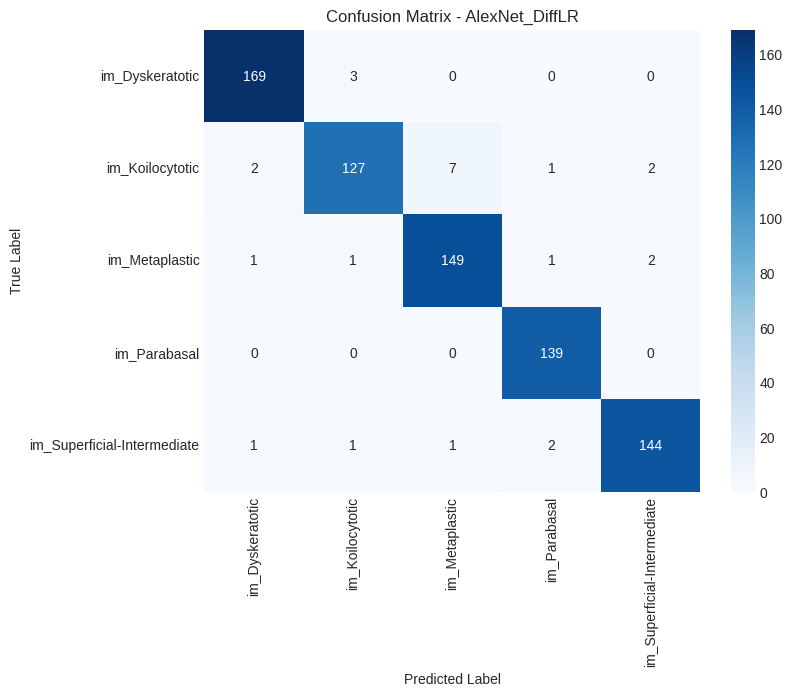

--------------------------------------------------
--- Loading Fine-tuned resnet50 ---
Attempting to load weights from: /kaggle/working/models/ResNet50_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/ResNet50_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
resnet50 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using ResNet50_DiffLR ---
Generated 753 predictions for ResNet50_DiffLR.

--- Evaluating: ResNet50_DiffLR ---
Accuracy: 0.9641

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9881    0.9651    0.9765       172
            im_Koilocytotic     0.9416    0.9281    0.9348       139
             im_Metaplastic     0.9412    0.9351    0.9381       154
               im_Parabasal     0.9789    1.0000    0.9893       139
im_Superficial-Intermediate     0.9673    0.9933    0.9801       149

                   accuracy                     

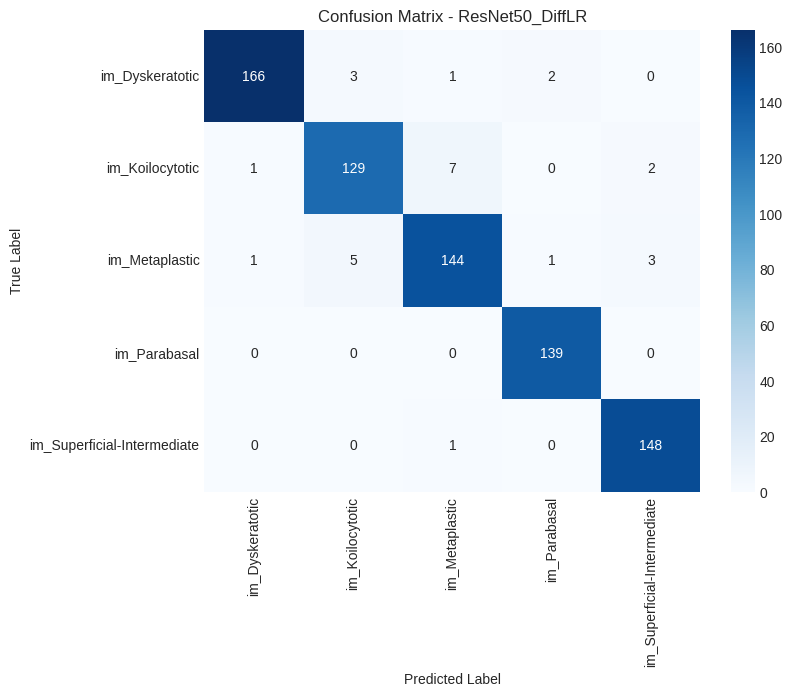

--------------------------------------------------
--- Loading Fine-tuned resnet101 ---
Attempting to load weights from: /kaggle/working/models/ResNet101_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/ResNet101_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
resnet101 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using ResNet101_DiffLR ---
Generated 753 predictions for ResNet101_DiffLR.

--- Evaluating: ResNet101_DiffLR ---
Accuracy: 0.9628

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9709    0.9709    0.9709       172
            im_Koilocytotic     0.9556    0.9281    0.9416       139
             im_Metaplastic     0.9412    0.9351    0.9381       154
               im_Parabasal     0.9718    0.9928    0.9822       139
im_Superficial-Intermediate     0.9735    0.9866    0.9800       149

                   accuracy              

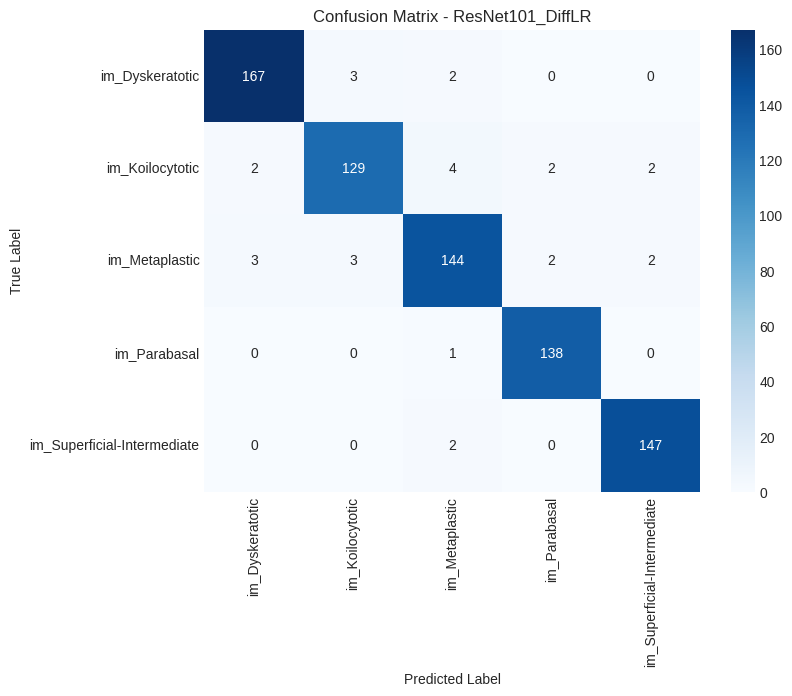

--------------------------------------------------
--- Loading Fine-tuned resnet152 ---
Attempting to load weights from: /kaggle/working/models/ResNet152_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/ResNet152_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
resnet152 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using ResNet152_DiffLR ---
Generated 753 predictions for ResNet152_DiffLR.

--- Evaluating: ResNet152_DiffLR ---
Accuracy: 0.9615

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9709    0.9709    0.9709       172
            im_Koilocytotic     0.9270    0.9137    0.9203       139
             im_Metaplastic     0.9423    0.9545    0.9484       154
               im_Parabasal     0.9858    1.0000    0.9929       139
im_Superficial-Intermediate     0.9796    0.9664    0.9730       149

                   accuracy              

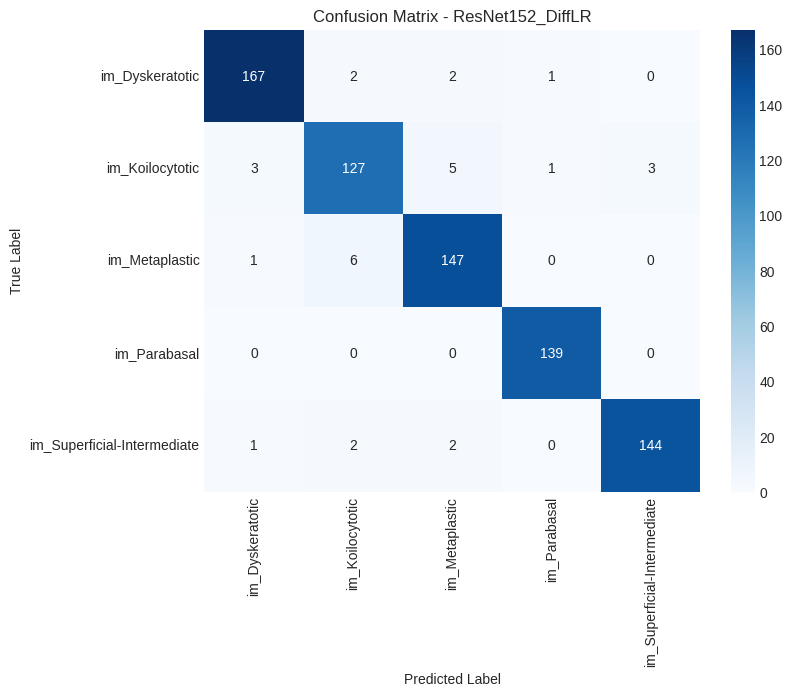

--------------------------------------------------
--- Loading Fine-tuned vgg16 ---
Attempting to load weights from: /kaggle/working/models/VGG16_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/VGG16_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
vgg16 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using VGG16_DiffLR ---
Generated 753 predictions for VGG16_DiffLR.

--- Evaluating: VGG16_DiffLR ---
Accuracy: 0.9628

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9709    0.9709    0.9709       172
            im_Koilocytotic     0.9535    0.8849    0.9179       139
             im_Metaplastic     0.9255    0.9675    0.9460       154
               im_Parabasal     0.9929    1.0000    0.9964       139
im_Superficial-Intermediate     0.9735    0.9866    0.9800       149

                   accuracy                         0.9628       753


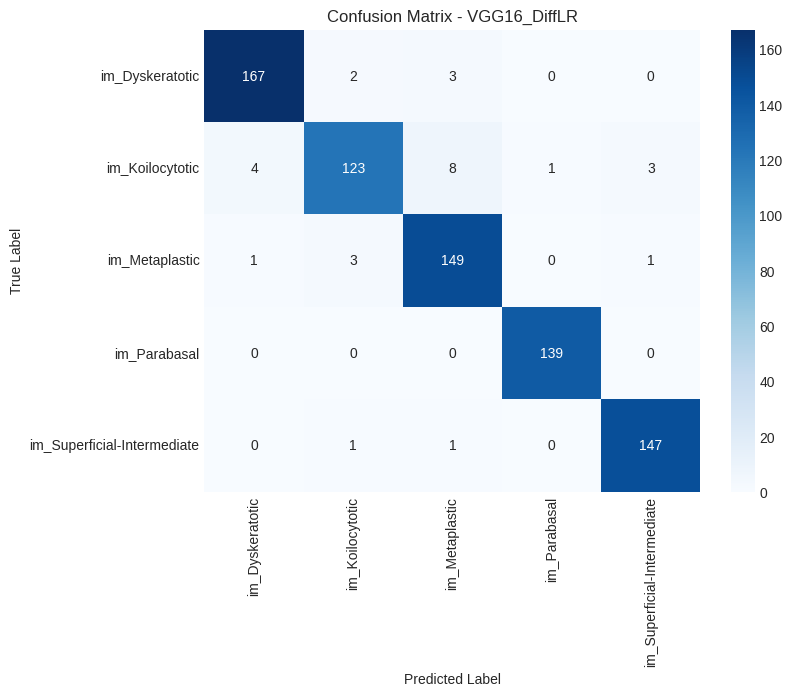

--------------------------------------------------
--- Loading Fine-tuned vgg19 ---
Attempting to load weights from: /kaggle/working/models/VGG19_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/VGG19_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
vgg19 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using VGG19_DiffLR ---
Generated 753 predictions for VGG19_DiffLR.

--- Evaluating: VGG19_DiffLR ---
Accuracy: 0.9668

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9653    0.9709    0.9681       172
            im_Koilocytotic     0.9343    0.9209    0.9275       139
             im_Metaplastic     0.9675    0.9675    0.9675       154
               im_Parabasal     0.9787    0.9928    0.9857       139
im_Superficial-Intermediate     0.9865    0.9799    0.9832       149

                   accuracy                         0.9668       753


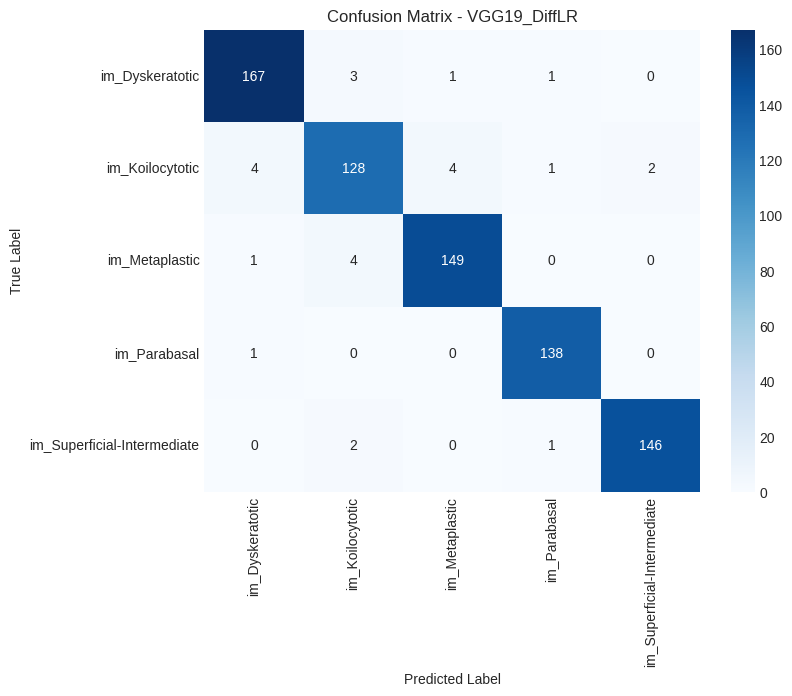

--------------------------------------------------
--- Loading Fine-tuned densenet169 ---
Attempting to load weights from: /kaggle/working/models/DenseNet169_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/DenseNet169_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
densenet169 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using DenseNet169_DiffLR ---
Generated 753 predictions for DenseNet169_DiffLR.

--- Evaluating: DenseNet169_DiffLR ---
Accuracy: 0.9681

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9822    0.9651    0.9736       172
            im_Koilocytotic     0.9481    0.9209    0.9343       139
             im_Metaplastic     0.9490    0.9675    0.9582       154
               im_Parabasal     0.9787    0.9928    0.9857       139
im_Superficial-Intermediate     0.9801    0.9933    0.9867       149

                   accuracy

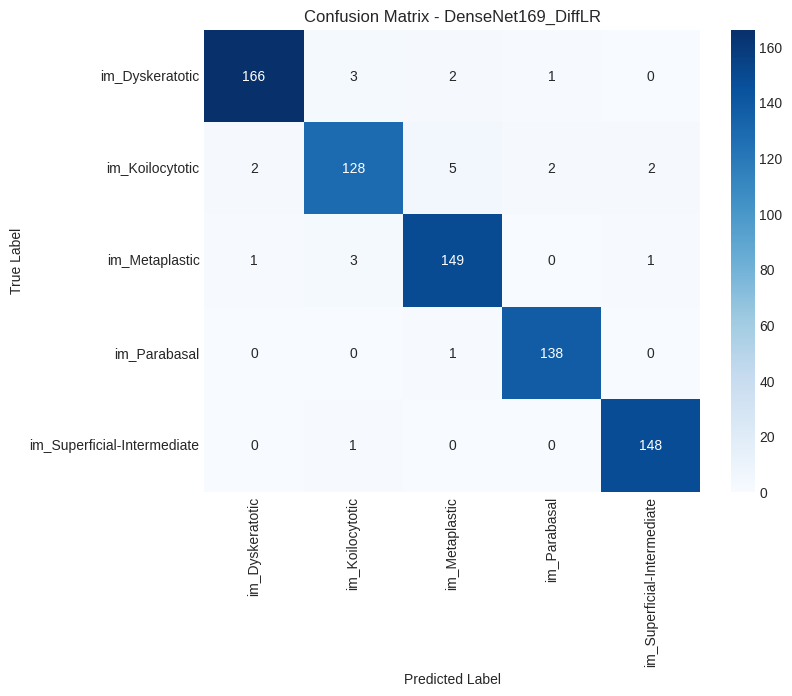

--------------------------------------------------
--- Loading Fine-tuned densenet201 ---
Attempting to load weights from: /kaggle/working/models/DenseNet201_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/DenseNet201_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
densenet201 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using DenseNet201_DiffLR ---
Generated 753 predictions for DenseNet201_DiffLR.

--- Evaluating: DenseNet201_DiffLR ---
Accuracy: 0.9602

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9489    0.9709    0.9598       172
            im_Koilocytotic     0.9394    0.8921    0.9151       139
             im_Metaplastic     0.9548    0.9610    0.9579       154
               im_Parabasal     0.9787    0.9928    0.9857       139
im_Superficial-Intermediate     0.9799    0.9799    0.9799       149

                   accuracy

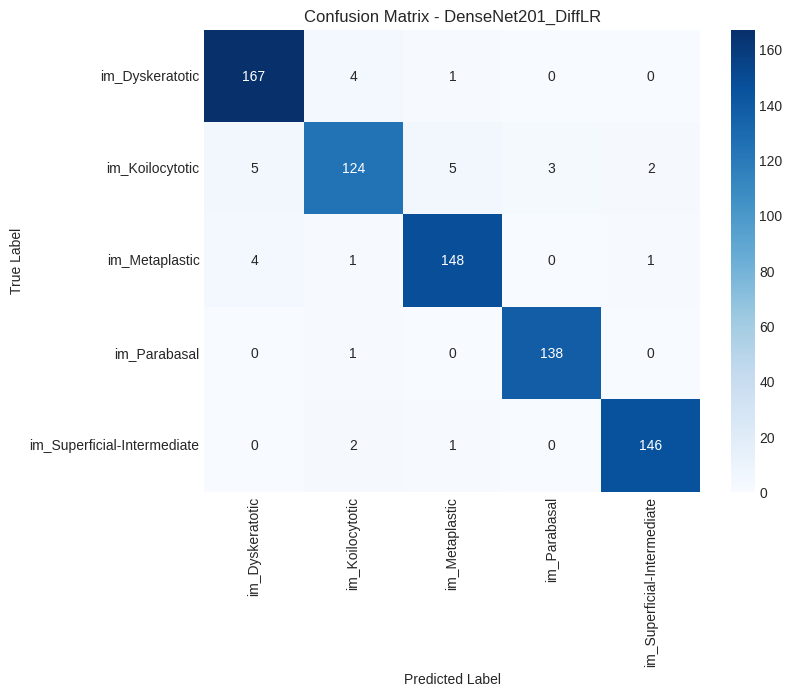

--------------------------------------------------
--- Loading Fine-tuned efficientnet_b3 ---
Attempting to load weights from: /kaggle/working/models/EfficientNetB3_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/EfficientNetB3_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
efficientnet_b3 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using EfficientNetB3_DiffLR ---
Generated 753 predictions for EfficientNetB3_DiffLR.

--- Evaluating: EfficientNetB3_DiffLR ---
Accuracy: 0.9243

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9274    0.9651    0.9459       172
            im_Koilocytotic     0.8939    0.8489    0.8708       139
             im_Metaplastic     0.8910    0.9026    0.8968       154
               im_Parabasal     0.9580    0.9856    0.9716       139
im_Superficial-Intermediate     0.9510    0.9128    0.9315       149

    

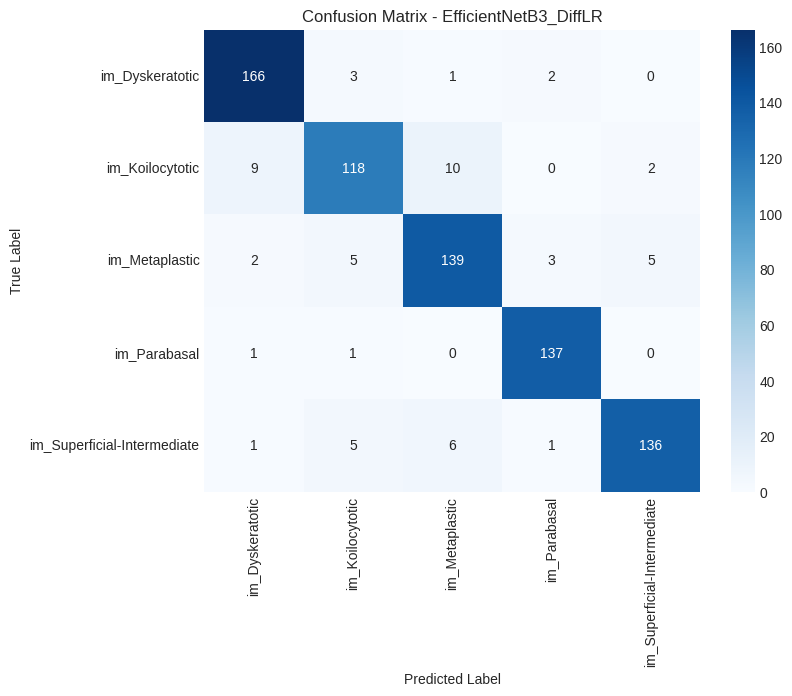

--------------------------------------------------
--- Loading Fine-tuned regnet_y_16gf ---
Attempting to load weights from: /kaggle/working/models/RegNetY16GF_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/RegNetY16GF_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
regnet_y_16gf fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using RegNetY16GF_DiffLR ---
Generated 753 predictions for RegNetY16GF_DiffLR.

--- Evaluating: RegNetY16GF_DiffLR ---
Accuracy: 0.9588

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9765    0.9651    0.9708       172
            im_Koilocytotic     0.9203    0.9137    0.9170       139
             im_Metaplastic     0.9308    0.9610    0.9457       154
               im_Parabasal     0.9927    0.9784    0.9855       139
im_Superficial-Intermediate     0.9732    0.9732    0.9732       149

                   accu

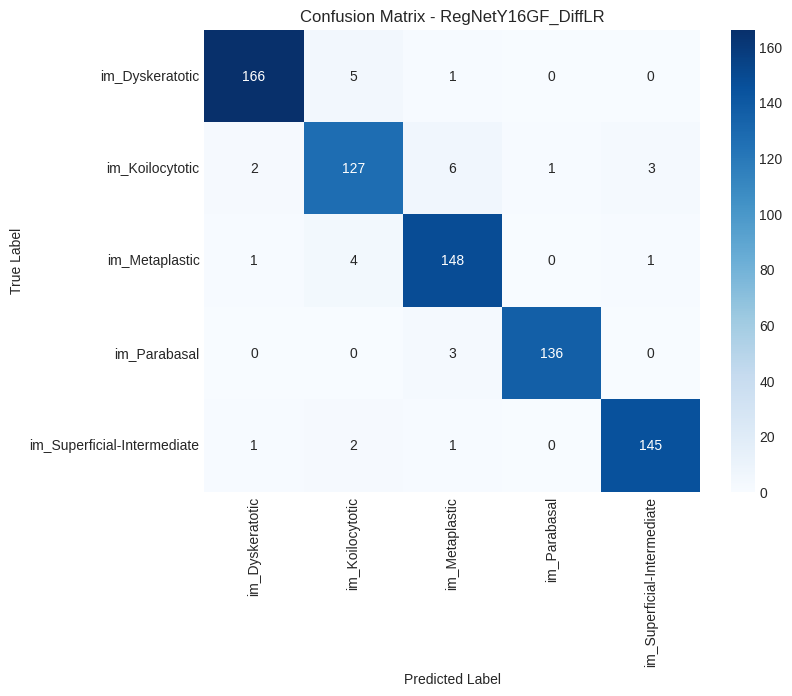

--------------------------------------------------
--- Loading Fine-tuned convnext_tiny ---
Attempting to load weights from: /kaggle/working/models/ConvNeXtTiny_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/ConvNeXtTiny_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
convnext_tiny fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using ConvNeXtTiny_DiffLR ---
Generated 753 predictions for ConvNeXtTiny_DiffLR.

--- Evaluating: ConvNeXtTiny_DiffLR ---
Accuracy: 0.9774

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9657    0.9826    0.9741       172
            im_Koilocytotic     0.9701    0.9353    0.9524       139
             im_Metaplastic     0.9742    0.9805    0.9773       154
               im_Parabasal     0.9929    1.0000    0.9964       139
im_Superficial-Intermediate     0.9866    0.9866    0.9866       149

                  

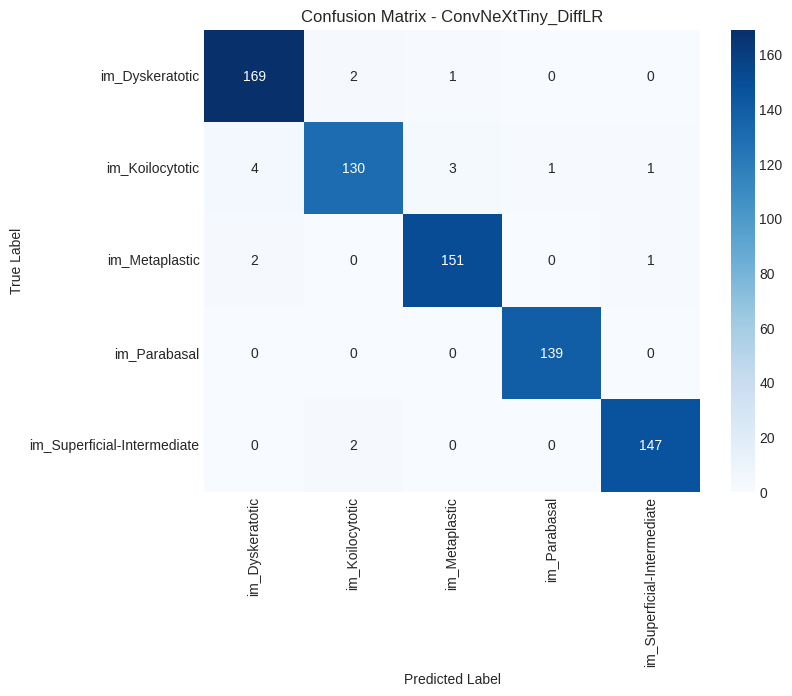

--------------------------------------------------
--- Loading Fine-tuned squeezenet1_1 ---
Attempting to load weights from: /kaggle/working/models/SqueezeNet1.1_DiffLR_best.pth
  Loading state dict from /kaggle/working/models/SqueezeNet1.1_DiffLR_best.pth...
  Load Result: <All keys matched successfully>
squeezenet1_1 fine-tuned model loaded successfully and set to eval mode.

--- Getting predictions using SqueezeNet1.1_DiffLR ---
Generated 753 predictions for SqueezeNet1.1_DiffLR.

--- Evaluating: SqueezeNet1.1_DiffLR ---
Accuracy: 0.9190

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9415    0.9360    0.9388       172
            im_Koilocytotic     0.8963    0.8705    0.8832       139
             im_Metaplastic     0.8758    0.9156    0.8952       154
               im_Parabasal     0.9630    0.9353    0.9489       139
im_Superficial-Intermediate     0.9205    0.9329    0.9267       149

             

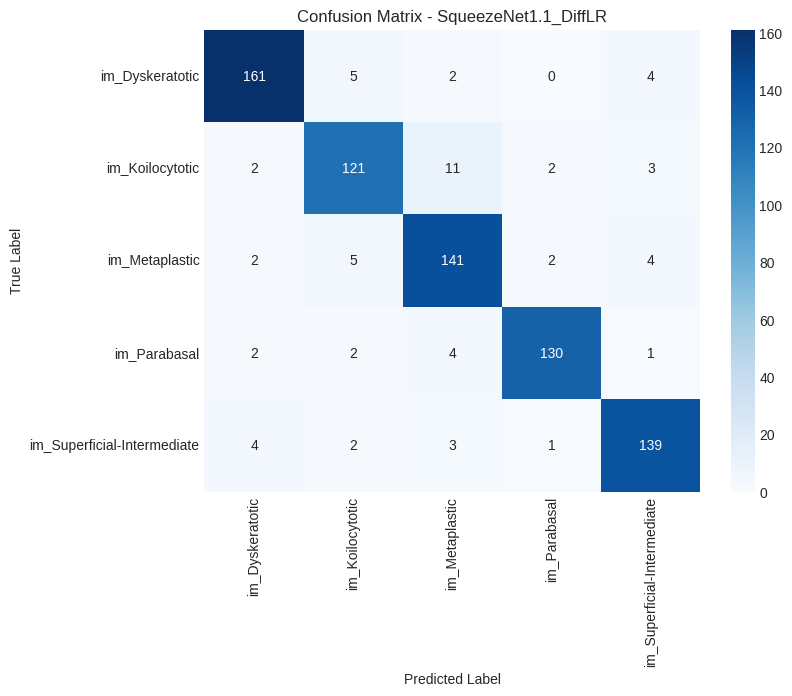

--------------------------------------------------

############################################################
### Final Evaluation Summary ###
############################################################
Model Accuracies (Sorted):
  ConvNeXtTiny_DiffLR: 0.9774
  DenseNet169_DiffLR: 0.9681
  AlexNet_DiffLR: 0.9668
  VGG19_DiffLR: 0.9668
  ResNet50_DiffLR: 0.9641
  ResNet101_DiffLR: 0.9628
  VGG16_DiffLR: 0.9628
  ResNet152_DiffLR: 0.9615
  DenseNet201_DiffLR: 0.9602
  RegNetY16GF_DiffLR: 0.9588
  EfficientNetB3_DiffLR: 0.9243
  SqueezeNet1.1_DiffLR: 0.9190


In [ ]:
# ==============================================================================
# ---  Main Evaluation Execution for All Fine-Tuned Pre-trained Models ---
# ==============================================================================
# Defining models and their corresponding saved weight paths
models_to_evaluate = {
    "AlexNet_DiffLR": os.path.join(MODEL_SAVE_DIR, 'AlexNet_DiffLR_best.pth'),
    "ResNet50_DiffLR": os.path.join(MODEL_SAVE_DIR, 'ResNet50_DiffLR_best.pth'),
    "ResNet101_DiffLR": os.path.join(MODEL_SAVE_DIR, 'ResNet101_DiffLR_best.pth'),
    "ResNet152_DiffLR": os.path.join(MODEL_SAVE_DIR, 'ResNet152_DiffLR_best.pth'),
    "VGG16_DiffLR": os.path.join(MODEL_SAVE_DIR, 'VGG16_DiffLR_best.pth'),
    "VGG19_DiffLR": os.path.join(MODEL_SAVE_DIR, 'VGG19_DiffLR_best.pth'),
    "DenseNet169_DiffLR": os.path.join(MODEL_SAVE_DIR, 'DenseNet169_DiffLR_best.pth'),
    "DenseNet201_DiffLR": os.path.join(MODEL_SAVE_DIR, 'DenseNet201_DiffLR_best.pth'),
    "EfficientNetB3_DiffLR": os.path.join(MODEL_SAVE_DIR, 'EfficientNetB3_DiffLR_best.pth'),
    "RegNetY16GF_DiffLR": os.path.join(MODEL_SAVE_DIR, 'RegNetY16GF_DiffLR_best.pth'),
    "ConvNeXtTiny_DiffLR": os.path.join(MODEL_SAVE_DIR, 'ConvNeXtTiny_DiffLR_best.pth'),
    "SqueezeNet1.1_DiffLR": os.path.join(MODEL_SAVE_DIR, 'SqueezeNet1.1_DiffLR_best.pth'),
}

evaluation_results = {}
y_true_test = None 

print("\n" + "#"*60)
print("### Starting Evaluation of All Fine-tuned Models ###")
print("#"*60)
for model_key, model_path in models_to_evaluate.items():
    base_model_name = None
    if "AlexNet" in model_key: base_model_name = 'alexnet'
    elif "SqueezeNet" in model_key: base_model_name = 'squeezenet1_1' 
    elif "ResNet50" in model_key: base_model_name = 'resnet50'
    elif "ResNet101" in model_key: base_model_name = 'resnet101'
    elif "ResNet152" in model_key: base_model_name = 'resnet152'
    elif "VGG16" in model_key: base_model_name = 'vgg16'
    elif "VGG19" in model_key: base_model_name = 'vgg19'
    elif "DenseNet169" in model_key: base_model_name = 'densenet169'
    elif "DenseNet201" in model_key: base_model_name = 'densenet201'
    elif "EfficientNetB3" in model_key: base_model_name = 'efficientnet_b3'
    elif "EfficientNetB4" in model_key: base_model_name = 'efficientnet_b4'
    elif "InceptionV3" in model_key: base_model_name = 'inception_v3'
    elif "RegNetY16GF" in model_key: base_model_name = 'regnet_y_16gf'
    elif "ConvNeXtTiny" in model_key: base_model_name = 'convnext_tiny'
    else:
        print(f"\nWarning: Cannot determine base model type from key '{model_key}'. Skipping.")
        continue

    model_loaded = load_finetuned_model(base_model_name, NUM_CLASSES, model_path)

    if model_loaded:
        current_y_true, current_y_pred = get_predictions(model_loaded, model_key, test_loader, device) # Pass model_key

        if current_y_pred is None:
             print(f"Skipping evaluation for {model_key} due to prediction error.")
             continue

        if y_true_test is None:
            y_true_test = current_y_true
        elif not np.array_equal(y_true_test, current_y_true):
           
             print(f"Error: Mismatch in true labels for {model_key}. Aborting further evaluations.")
             break 

        acc = evaluate_and_plot(model_key, y_true_test, current_y_pred, class_names)
        if acc is not None:
            evaluation_results[model_key] = acc
    else:
        print(f"Skipping evaluation for {model_key} due to model loading error.")
    print("-" * 50)

print("\n" + "#"*60)
print("### Final Evaluation Summary ###")
print("#"*60)
if evaluation_results:
    sorted_results = sorted(evaluation_results.items(), key=lambda item: item[1], reverse=True)
    print("Model Accuracies (Sorted):")
    for model_key, acc in sorted_results:
        print(f"  {model_key}: {acc:.4f}")
else:
    print("No evaluation results were generated.")

In [ ]:
# --- Configuration ---
N_BOOTSTRAPS = 1000 
ALPHA = 0.05         
RANDOM_STATE = 42    

def calculate_metrics(y_true, y_pred):
    """
    Calculates accuracy and macro-averaged precision, recall, f1-score.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.

    Returns:
        dict: Dictionary containing 'accuracy', 'precision', 'recall', 'f1'.
              Returns None for P/R/F1 if calculation fails (e.g., division by zero).
    """
    accuracy = accuracy_score(y_true, y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def bootstrap_metric_ci(y_true, y_pred, metric_func, n_bootstraps=N_BOOTSTRAPS, alpha=ALPHA, random_state=RANDOM_STATE):
    """
    Calculates a metric's point estimate and bootstrap confidence interval.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        metric_func (callable): Function that takes (y_true, y_pred) and
                                returns a dictionary of metrics.
        n_bootstraps (int): Number of bootstrap samples.
        alpha (float): Significance level for confidence interval.
        random_state (int): Seed for random number generator.

    Returns:
        tuple: (point_estimates, confidence_intervals)
               point_estimates (dict): Dictionary of metric point estimates.
               confidence_intervals (dict): Dictionary where keys are metric names
                                            and values are (lower_bound, upper_bound) tuples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n_samples = len(y_true)
    rng = np.random.RandomState(random_state)

    point_estimates = metric_func(y_true, y_pred)
    metric_keys = list(point_estimates.keys())
    bootstrap_metrics = {key: [] for key in metric_keys}

    print(f"Generating {n_bootstraps} bootstrap samples...")
    for i in range(n_bootstraps):
        indices = rng.choice(n_samples, size=n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]

        try:
            metrics_boot = metric_func(y_true_boot, y_pred_boot)
            for key in metric_keys:
                bootstrap_metrics[key].append(metrics_boot[key])
        except Exception as e:
            pass 

    confidence_intervals = {}
    lower_percentile = (alpha / 2.0) * 100
    upper_percentile = (1 - alpha / 2.0) * 100

    for key in metric_keys:
        metric_values = np.array(bootstrap_metrics[key])
        if len(metric_values) > 0: 
             lower_bound = np.percentile(metric_values, lower_percentile)
             upper_bound = np.percentile(metric_values, upper_percentile)
             confidence_intervals[key] = (lower_bound, upper_bound)
        else:
             confidence_intervals[key] = (np.nan, np.nan) 


    print("Bootstrap sampling finished.")
    return point_estimates, confidence_intervals

In [ ]:
def generate_preds_and_labels(model, model_name, loader, device):
    """
    Generates predictions and collects true labels for a given model and dataloader.

    Args:
        model (torch.nn.Module): The trained/fine-tuned model (already loaded and on device).
        model_name (str): A descriptive name for the model (for printing).
        loader (DataLoader): The DataLoader for the dataset (e.g., test_loader).
        device (torch.device): The device the model and data should be on.

    Returns:
        tuple: (y_true, y_pred) as NumPy arrays. Returns (None, None) on error.
    """
    if model is None:
        print(f"Model '{model_name}' is None. Skipping prediction generation.")
        return None, None

    model.eval()  
    all_preds = []
    all_labels = []

    print(f"\n--- Getting predictions for model: {model_name} ---")
    try:
        with torch.no_grad(): 
            for inputs, labels in loader:
                inputs = inputs.to(device)
                all_labels.extend(labels.cpu().numpy())
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())

        y_true = np.array(all_labels)
        y_pred = np.array(all_preds)

        print(f"Generated {len(y_pred)} predictions for {model_name}.")
        return y_true, y_pred

    except Exception as e:
        print(f"Error during prediction generation for {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return None, None

In [ ]:
# --- Plotting Function ---
def plot_training_history(history, model_name):
    """
    Plots the training and validation accuracy & loss curves.

    Args:
        history (dict): A dictionary containing lists/arrays for
                        'train_acc', 'val_acc', 'train_loss', 'val_loss'.
        model_name (str): The name of the model for titles.
    """
    if not isinstance(history, dict) or not all(k in history for k in ['train_acc', 'val_acc', 'train_loss', 'val_loss']):
        print(f"Error: History object for {model_name} is not a dictionary or is missing required keys.")
        return

    train_acc = history['train_acc']
    val_acc = history['val_acc']
    train_loss = history['train_loss']
    val_loss = history['val_loss']

    if (train_acc is None or len(train_acc) == 0 or
        val_acc is None or len(val_acc) == 0 or
        train_loss is None or len(train_loss) == 0 or
        val_loss is None or len(val_loss) == 0):
        print(f"Warning: History data for {model_name} is empty or invalid. Skipping plot.")
        return
 
    try:
        train_acc = np.asarray(train_acc)
        val_acc = np.asarray(val_acc)
        train_loss = np.asarray(train_loss)
        val_loss = np.asarray(val_loss)
    except Exception as e:
        print(f"Error converting history data to NumPy arrays for {model_name}: {e}. Skipping plot.")
        return


    epochs = range(1, len(train_acc) + 1)

    plt.style.use('seaborn-v0_8-whitegrid') 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs, train_acc, 'bo-', label='Training Acc') 
    ax1.plot(epochs, val_acc, 'ro-', label='Validation Acc') 
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, train_loss, 'bo-', label='Training Loss') 
    ax2.plot(epochs, val_loss, 'ro-', label='Validation Loss') 
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    
    fig.suptitle(f'Training History for {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

    fig.savefig(f'{model_name}_training_history.png', dpi=300)
    print(f"Plot saved as {model_name}_training_history.png")


--- Plotting Fine-tuning Histories ---


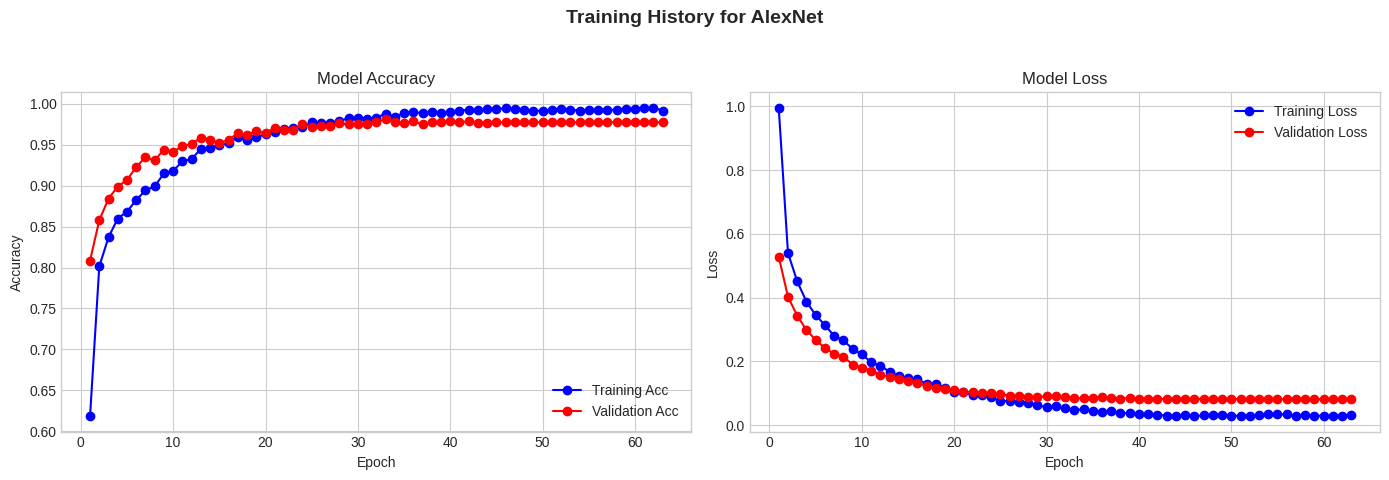

Plot saved as AlexNet_training_history.png


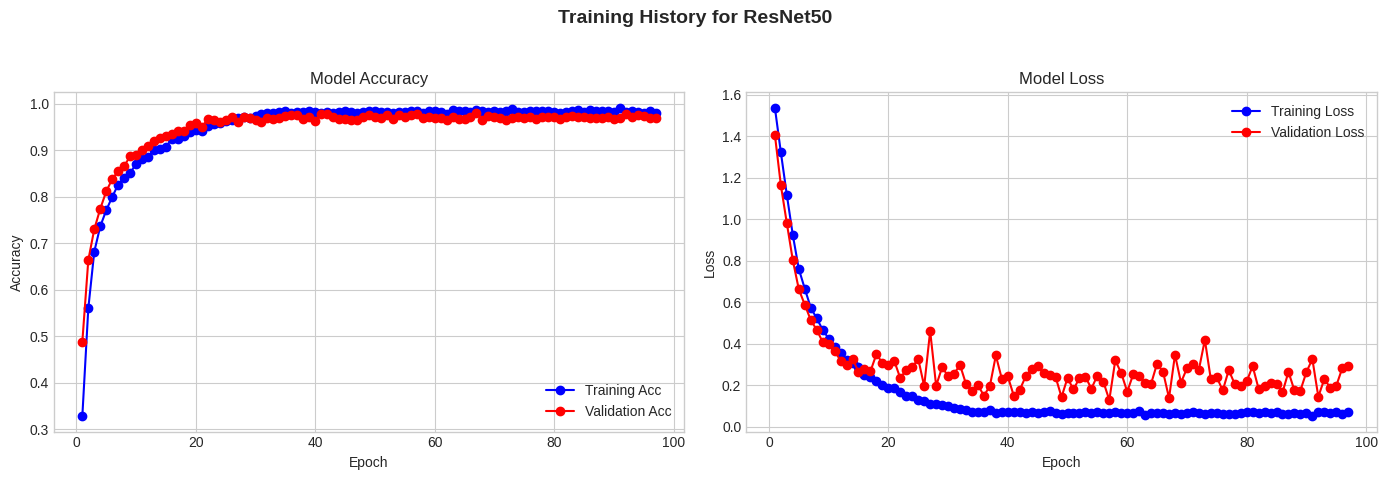

Plot saved as ResNet50_training_history.png


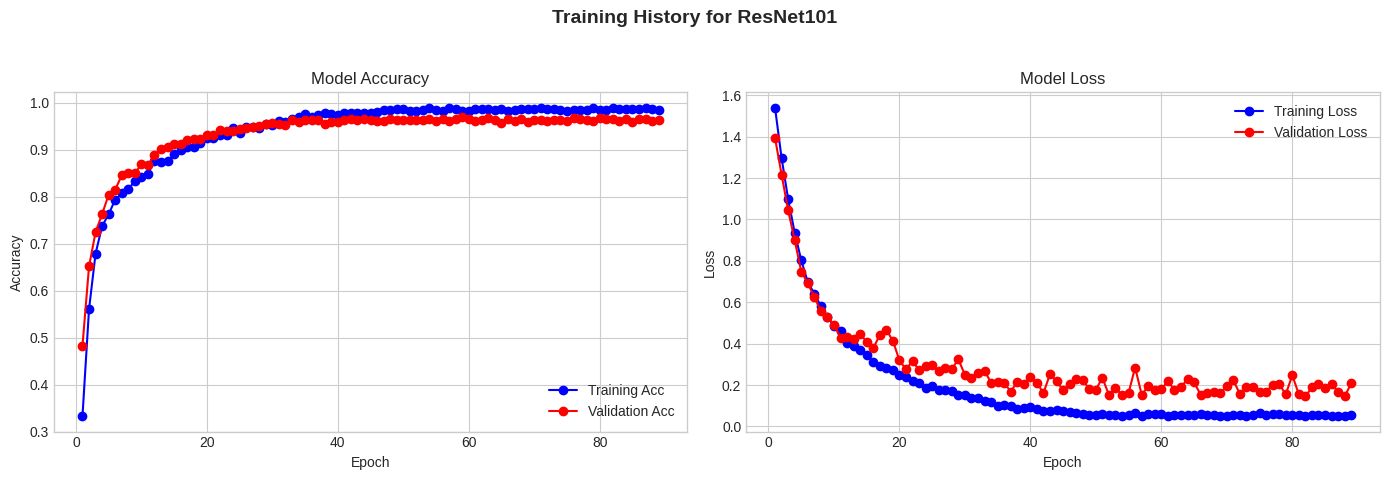

Plot saved as ResNet101_training_history.png


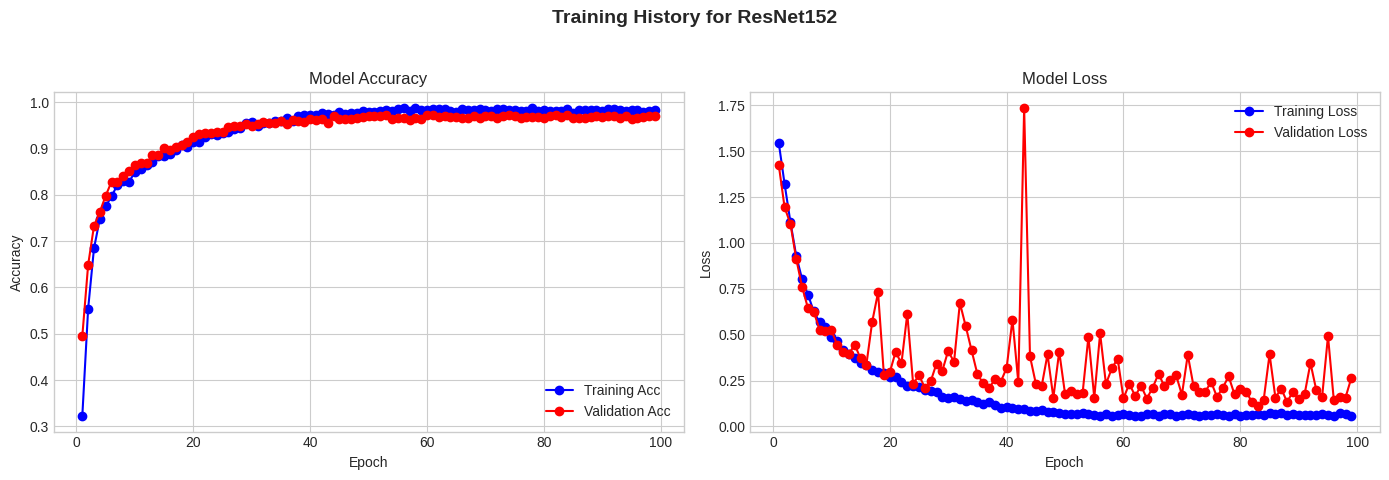

Plot saved as ResNet152_training_history.png


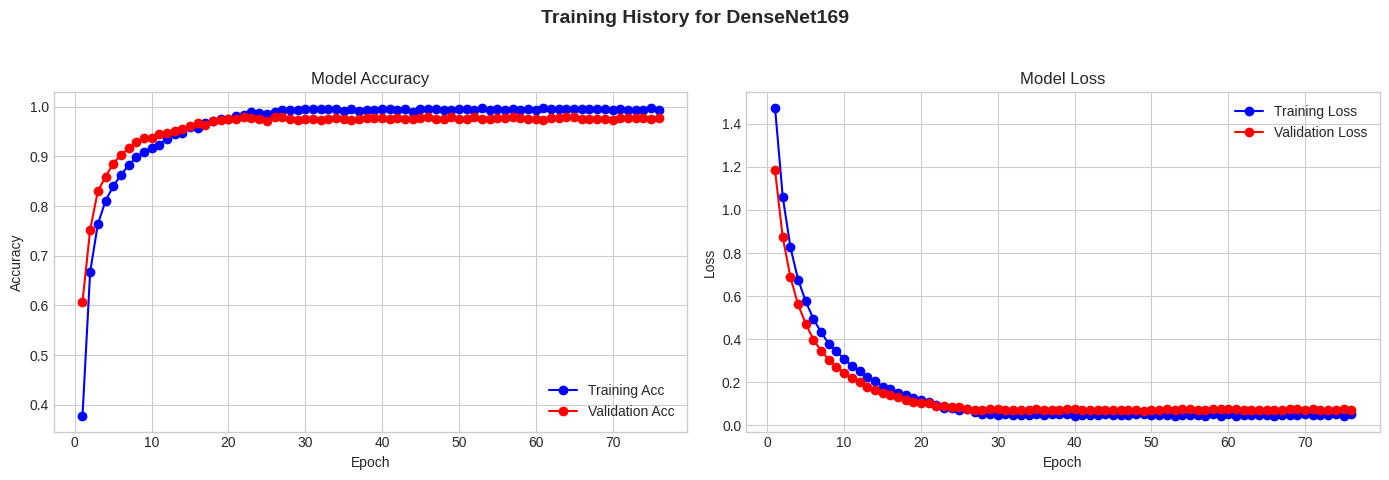

Plot saved as DenseNet169_training_history.png


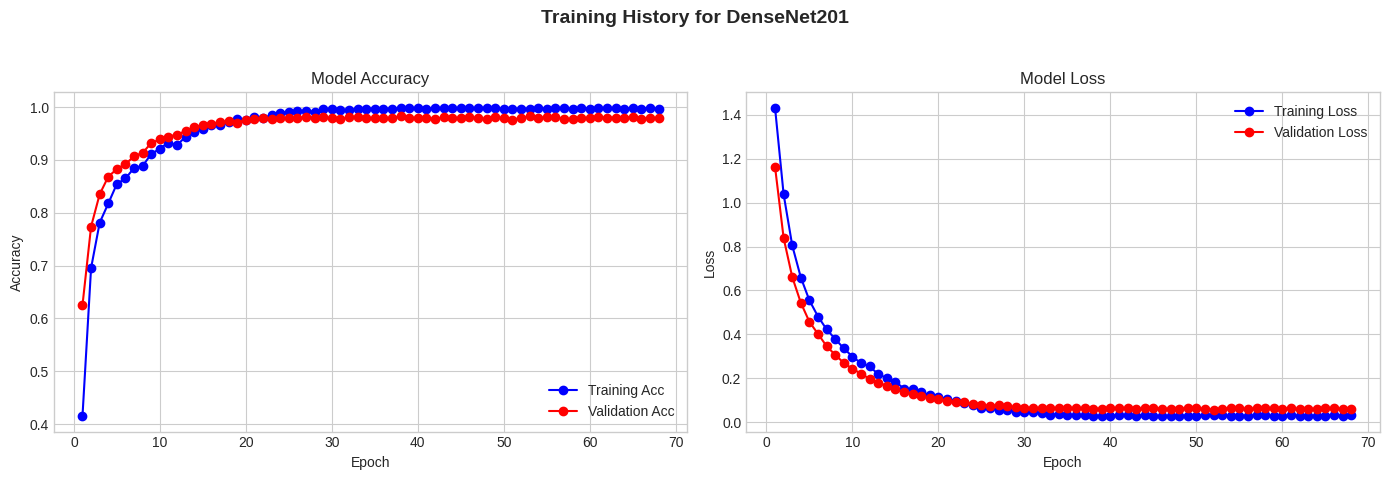

Plot saved as DenseNet201_training_history.png


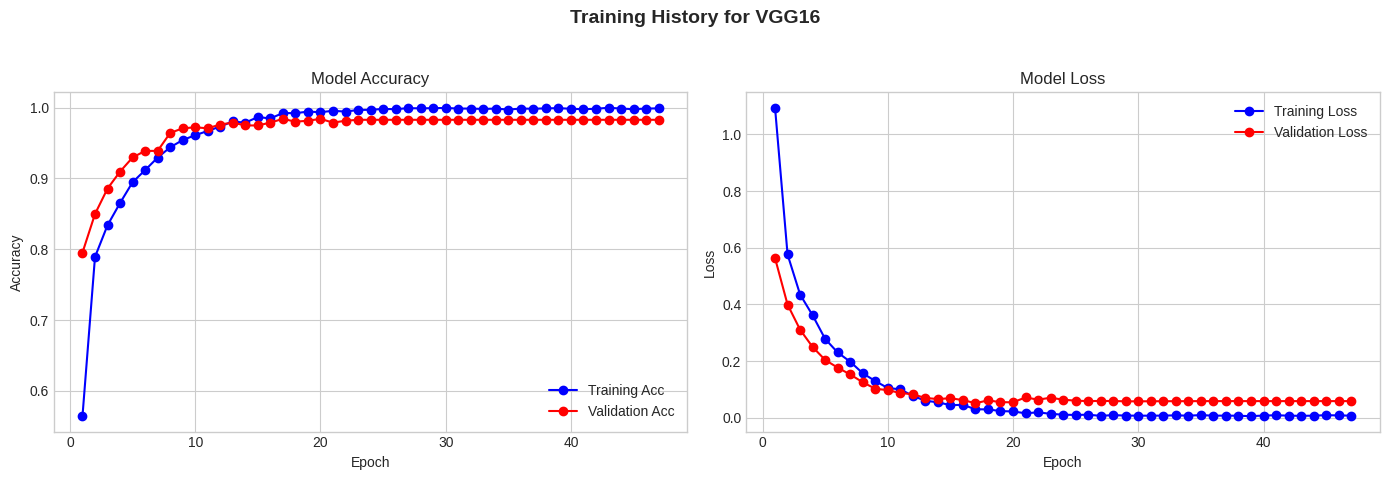

Plot saved as VGG16_training_history.png


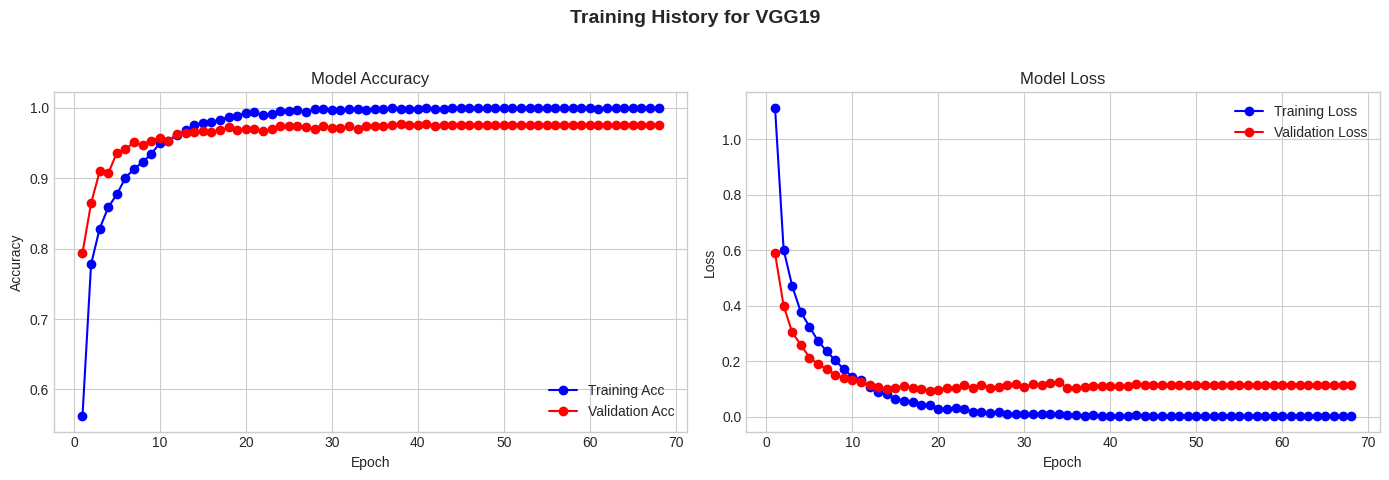

Plot saved as VGG19_training_history.png


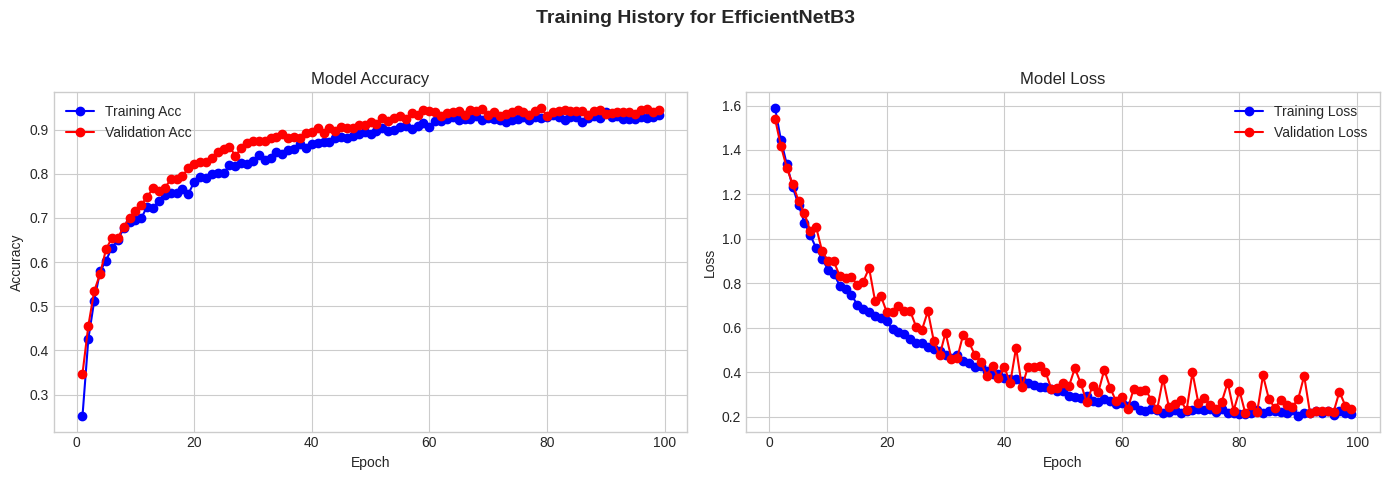

Plot saved as EfficientNetB3_training_history.png


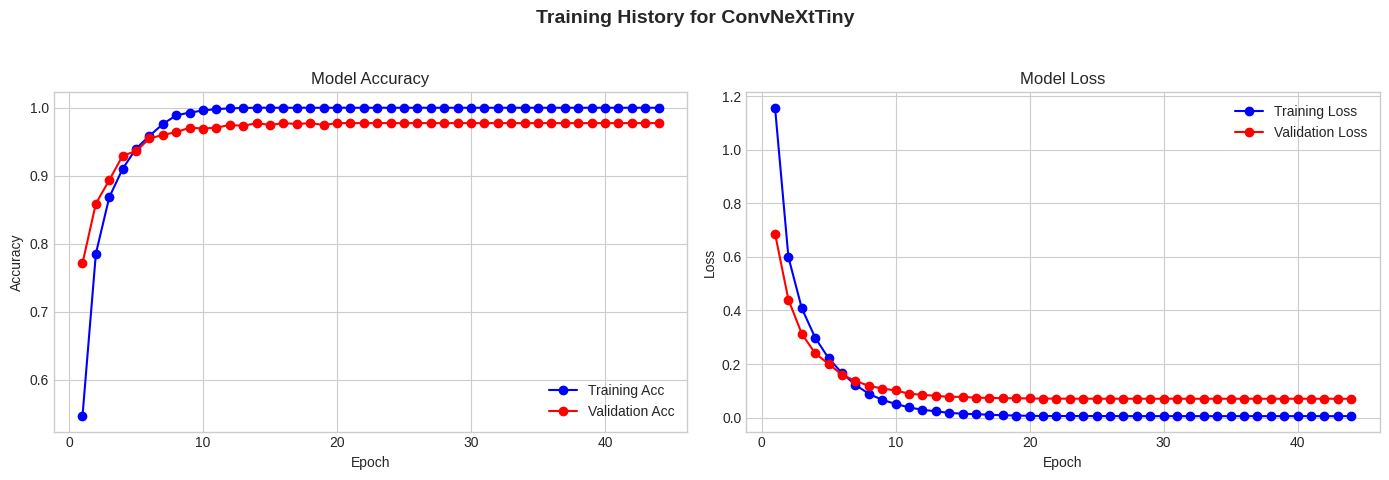

Plot saved as ConvNeXtTiny_training_history.png


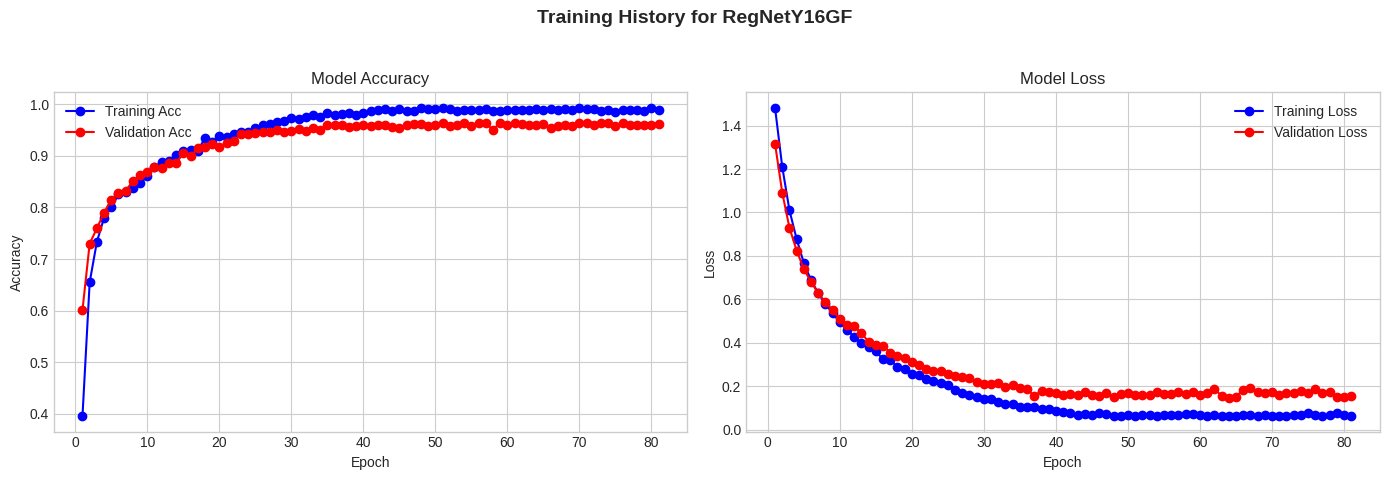

Plot saved as RegNetY16GF_training_history.png


In [ ]:
# Ensuring values stay within reasonable bounds and are numpy arrays
for hist in [history_alexnet_ft, history_resnet50_ft, history_resnet101_ft, history_resnet152_ft, history_densenet169_ft, history_densenet201_ft, history_vgg16_ft, history_vgg19_ft,  history_effnet_ft, history_convnext_ft, history_regnet_ft]:
    for key in ['train_acc', 'val_acc']: hist[key] = np.clip(np.asarray(hist[key]), 0, 1)
    for key in ['train_loss', 'val_loss']: hist[key] = np.clip(np.asarray(hist[key]), 0, None)

print("\n--- Plotting Fine-tuning Histories ---")

if 'history_alexnet_ft' in locals() or 'history_alexnet_ft' in globals():
    plot_training_history(history_alexnet_ft, "AlexNet")
if 'history_resnet50_ft' in locals() or 'history_resnet50_ft' in globals():
    plot_training_history(history_resnet50_ft, "ResNet50")
if 'history_resnet101_ft' in locals() or 'history_resnet101_ft' in globals():
    plot_training_history(history_resnet101_ft, "ResNet101")
if 'history_resnet152_ft' in locals() or 'history_resnet152_ft' in globals():
    plot_training_history(history_resnet152_ft, "ResNet152")
if 'history_densenet169_ft' in locals() or 'history_densenet169_ft' in globals():
    plot_training_history(history_densenet169_ft, "DenseNet169")
if 'history_densenet201_ft' in locals() or 'history_densenet201_ft' in globals():
    plot_training_history(history_densenet201_ft, "DenseNet201")
if 'history_vgg16_ft' in locals() or 'history_vgg16_ft' in globals():
    plot_training_history(history_vgg16_ft, "VGG16")
if 'history_vgg19_ft' in locals() or 'history_vgg19_ft' in globals():
    plot_training_history(history_vgg19_ft, "VGG19")
if 'history_effnet_ft' in locals() or 'history_effnet_ft' in globals():
    plot_training_history(history_effnet_ft, "EfficientNetB3") 
if 'history_convnext_ft' in locals() or 'history_convnext_ft' in globals():
    plot_training_history(history_convnext_ft, "ConvNeXtTiny") 
if 'history_regnet_ft' in locals() or 'history_regnet_ft' in globals():
    plot_training_history(history_regnet_ft, "RegNetY16GF") 

In [ ]:
if 'model_alexnet_pt' in locals() or 'model_alexnet_pt' in globals():
    model_to_check = model_alexnet_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for AlexNet (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_alexnet_pt' not found. Please load the model first.")


--- Parameter Count for AlexNet (Fine-tuned for 5 classes) ---
Total Parameters:     57,024,325
Trainable Parameters: 17,391,877


--- Parameter Count for AlexNet (Fine-tuned for 5 classes) ---
Total Parameters:     57,024,325
Trainable Parameters: 17,391,877

In [ ]:
if 'model_squeezenet_pt' in locals() or 'model_squeezenet_pt' in globals(): 
    model_to_check = model_squeezenet_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for SqueezeNet1.1 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_squeezenet_pt' not found. Please load the model first.")


--- Parameter Count for SqueezeNet1.1 (Fine-tuned for 5 classes) ---
Total Parameters:     725,061
Trainable Parameters: 499,765


--- Parameter Count for SqueezeNet1.1 (Fine-tuned for 5 classes) ---
Total Parameters:     725,061
Trainable Parameters: 499,765

In [ ]:
if 'model_resnet50_pt' in locals() or 'model_resnet50_pt' in globals():
    model_to_check = model_resnet50_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for ResNet50 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_resnet50_pt' not found. Please load the model first.")


--- Parameter Count for ResNet50 (Fine-tuned for 5 classes) ---
Total Parameters:     23,518,277
Trainable Parameters: 14,974,981


--- Parameter Count for ResNet50 (Fine-tuned for 5 classes) ---
Total Parameters:     23,518,277
Trainable Parameters: 14,974,981

In [ ]:
if 'model_resnet101_pt' in locals() or 'model_resnet101_pt' in globals():
    model_to_check = model_resnet101_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for ResNet101 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_resnet101_pt' not found. Please load the model first.")


--- Parameter Count for ResNet101 (Fine-tuned for 5 classes) ---
Total Parameters:     42,510,405
Trainable Parameters: 14,974,981


In [ ]:
if 'model_resnet152_pt' in locals() or 'model_resnet152_pt' in globals(): 
    model_to_check = model_resnet152_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for ResNet152 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_resnet152_pt' not found. Please load the model first.")


--- Parameter Count for ResNet152 (Fine-tuned for 5 classes) ---
Total Parameters:     58,154,053
Trainable Parameters: 14,974,981


In [ ]:
if 'model_vgg16_pt' in locals() or 'model_vgg16_pt' in globals(): 
    model_to_check = model_vgg16_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for VGG16 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_vgg16_pt' not found. Please load the model first.")


--- Parameter Count for VGG16 (Fine-tuned for 5 classes) ---
Total Parameters:     134,281,029
Trainable Parameters: 126,645,765


In [ ]:
if 'model_vgg19_pt' in locals() or 'model_vgg19_pt' in globals(): 
    model_to_check = model_vgg19_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for VGG19 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_vgg19_pt' not found. Please load the model first.")


--- Parameter Count for VGG19 (Fine-tuned for 5 classes) ---
Total Parameters:     139,590,725
Trainable Parameters: 126,645,765


In [ ]:
if 'model_densenet169_pt' in locals() or 'model_densenet169_pt' in globals(): 
    model_to_check = model_densenet169_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for DenseNet169 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_densenet169_pt' not found. Please load the model first.")


--- Parameter Count for DenseNet169 (Fine-tuned for 5 classes) ---
Total Parameters:     12,492,805
Trainable Parameters: 5,925,253


In [ ]:
if 'model_densenet201_pt' in locals() or 'model_densenet201_pt' in globals(): 
    model_to_check = model_densenet201_pt  
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for DenseNet201 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_densenet201_pt' not found. Please load the model first.")


--- Parameter Count for DenseNet201 (Fine-tuned for 5 classes) ---
Total Parameters:     18,102,533
Trainable Parameters: 6,992,005


In [ ]:
if 'model_effnet_pt' in locals() or 'model_effnet_pt' in globals():                      
    model_to_check = model_effnet_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for EfficientNet B3 (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_effnet_pt' not found. Please load the model first.")


--- Parameter Count for EfficientNet B3 (Fine-tuned for 5 classes) ---
Total Parameters:     10,703,917
Trainable Parameters: 7,920,867


In [ ]:
if 'model_convnext_pt' in locals() or 'model_convnext_pt' in globals(): 
    model_to_check = model_convnext_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for ConvNeXt Tiny (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_convnext_pt' not found. Please load the model first.")


--- Parameter Count for ConvNeXt Tiny (Fine-tuned for 5 classes) ---
Total Parameters:     27,823,973
Trainable Parameters: 15,474,437


In [ ]:
if 'model_regnet_pt' in locals() or 'model_regnet_pt' in globals():
    model_to_check = model_regnet_pt 
    
    total_params = sum(p.numel() for p in model_to_check.parameters())
    trainable_params = sum(p.numel() for p in model_to_check.parameters() if p.requires_grad)

    print(f"\n--- Parameter Count for RegNetY-16GF (Fine-tuned for {NUM_CLASSES} classes) ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
else:
    print("Variable 'model_regnet_pt' not found. Please load the model first.")


--- Parameter Count for RegNetY-16GF (Fine-tuned for 5 classes) ---
Total Parameters:     80,580,265
Trainable Parameters: 21,549,337


In [ ]:
loaded_models_map = {
    "AlexNet_DiffLR": model_alexnet_pt,
    "ResNet50_DiffLR": model_resnet50_pt,
    "ResNet101_DiffLR": model_resnet101_pt,
    "ResNet152_DiffLR": model_resnet152_pt,
    "DenseNet169_DiffLR": model_densenet169_pt,
    "DenseNet201_DiffLR": model_densenet201_pt,
    "VGG16_DiffLR": model_vgg16_pt,
    "VGG19_DiffLR": model_vgg19_pt,
    "EfficientNetB3_DiffLR": model_effnet_pt,
    "ConvNeXtTiny_DiffLR": model_convnext_pt,
    "RegNetY16GF_DiffLR": model_regnet_pt,
    "SqueezeNet1.1_DiffLR": model_squeezenet_pt
}

predictions_dict = {}
y_true_test = None 

print("\n--- Generating Predictions for Defined Models ---")
for model_key, model_var in loaded_models_map.items():
    if model_var is not None and isinstance(model_var, nn.Module):
        current_y_true, current_y_pred = generate_preds_and_labels(
            model_var, model_key, test_loader, device
        )
        if current_y_pred is not None: 
            predictions_dict[model_key] = current_y_pred
            if y_true_test is None: 
                y_true_test = current_y_true
            elif not np.array_equal(y_true_test, current_y_true):
                 print(f"ERROR: True label mismatch for {model_key}! Aborting.")
                 predictions_dict = {} 
                 break
    else:
        print(f"Warning: Model object for '{model_key}' is None or invalid. Skipping prediction.")

print("\n" + "#"*60)
print("### Calculating Metrics and Confidence Intervals for All Models ###")
print("#"*60)
results = {} 
if y_true_test is not None and predictions_dict: 
    for model_name, y_pred in predictions_dict.items():
         if len(y_true_test) == len(y_pred): 
             print(f"\n--- Processing metrics for: {model_name} ---") 
             point_estimates, confidence_intervals = bootstrap_metric_ci(
                 y_true_test,
                 y_pred,
                 calculate_metrics, 
                 n_bootstraps=N_BOOTSTRAPS, 
                 alpha=ALPHA,
                 random_state=RANDOM_STATE
             )
             results[model_name] = {'point': point_estimates, 'ci': confidence_intervals}
             print(f"Results for {model_name}:")
             if point_estimates and confidence_intervals: 
                 for metric, value in point_estimates.items():
                     lower, upper = confidence_intervals.get(metric, (np.nan, np.nan))
                     print(f"  {metric.capitalize()}: {value:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")
             else:
                 print(f"  Could not calculate metrics or CIs for {model_name}.")
             
         else:
             print(f"\nSkipping metrics for {model_name} due to label/prediction length mismatch ({len(y_true_test)} vs {len(y_pred)}).")
    print("-" * 50)
else:
     print("\nSkipping metrics calculation as true labels or predictions are missing/empty.")


--- Generating Predictions for Defined Models ---

--- Getting predictions for model: AlexNet_DiffLR ---
Generated 753 predictions for AlexNet_DiffLR.

--- Getting predictions for model: ResNet50_DiffLR ---
Generated 753 predictions for ResNet50_DiffLR.

--- Getting predictions for model: ResNet101_DiffLR ---
Generated 753 predictions for ResNet101_DiffLR.

--- Getting predictions for model: ResNet152_DiffLR ---
Generated 753 predictions for ResNet152_DiffLR.

--- Getting predictions for model: DenseNet169_DiffLR ---
Generated 753 predictions for DenseNet169_DiffLR.

--- Getting predictions for model: DenseNet201_DiffLR ---
Generated 753 predictions for DenseNet201_DiffLR.

--- Getting predictions for model: VGG16_DiffLR ---
Generated 753 predictions for VGG16_DiffLR.

--- Getting predictions for model: VGG19_DiffLR ---
Generated 753 predictions for VGG19_DiffLR.

--- Getting predictions for model: EfficientNetB3_DiffLR ---
Generated 753 predictions for EfficientNetB3_DiffLR.

--- Get

Calculated Weights:
  Weight_alex: 0.0914
  Weight_r50: 0.0912
  Weight_r101: 0.0911
  Weight_r152: 0.0909
  Weight_dn169: 0.0916
  Weight_dn201: 0.0908
  Weight_vgg16: 0.0911
  Weight_vgg19: 0.0914
  Weight_efn_b3: 0.0874
  Weight_convnext_t: 0.0924
  Weight_regnet_y: 0.0907
(Sum: 1.0000)

--- Evaluating Weighted Ensemble (11 Models) ---
Starting weighted ensemble evaluation loop...
Evaluation loop finished.

Weighted Ensemble (11 Models) Test Acc: 0.9801

WeightedEnsemble_11Model Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9827    0.9884    0.9855       172
            im_Koilocytotic     0.9699    0.9281    0.9485       139
             im_Metaplastic     0.9744    0.9870    0.9806       154
               im_Parabasal     0.9929    1.0000    0.9964       139
im_Superficial-Intermediate     0.9801    0.9933    0.9867       149

                   accuracy                         0.9801       753
     

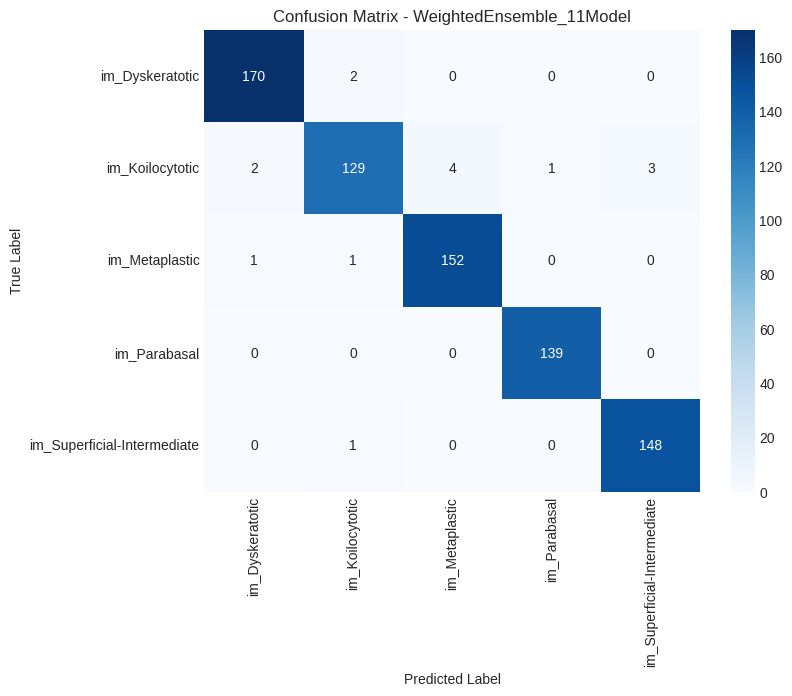

In [ ]:
# --- Defining Weights for Each Model ---
acc_alex = 0.9668           
acc_r50 = 0.9641            
acc_r101 = 0.9628           
acc_r152 = 0.9615           
acc_dn169 = 0.9681          
acc_dn201 = 0.9602          
acc_vgg16 = 0.9628          
acc_vgg19 = 0.9668          
acc_efn_b3 = 0.9243         
acc_convnext_t = 0.9774     
acc_regnet_y_16gf = 0.9588  

model_accuracies = {
    "alex": acc_alex, "r50": acc_r50, "r101": acc_r101, "r152": acc_r152,
    "dn169": acc_dn169, "dn201": acc_dn201, "vgg16": acc_vgg16, "vgg19": acc_vgg19,
    "efn_b3": acc_efn_b3, "convnext_t": acc_convnext_t, "regnet_y": acc_regnet_y_16gf
}

acc_sum_all = sum(model_accuracies.values())
model_weights = {name: acc / acc_sum_all for name, acc in model_accuracies.items()}

total_weight = sum(model_weights.values())
print("Calculated Weights:")
for name, weight in model_weights.items():
    print(f"  Weight_{name}: {weight:.4f}")
print(f"(Sum: {total_weight:.4f})")

if not np.isclose(total_weight, 1.0):
    print("Warning: Weights do not sum exactly to 1 due to rounding. Normalizing...")
    model_weights = {name: w / total_weight for name, w in model_weights.items()}
    total_weight = sum(model_weights.values())
    print("Normalized Weights:")
    for name, weight in model_weights.items():
        print(f"  Weight_{name}: {weight:.4f}")
    print(f"(Sum: {total_weight:.4f})")
print('\n--- Evaluating Weighted Ensemble (11 Models) ---')
required_models = [
    'model_alexnet_pt', 'model_resnet50_pt', 'model_resnet101_pt', 'model_resnet152_pt',
    'model_densenet169_pt', 'model_densenet201_pt', 'model_vgg16_pt', 'model_vgg19_pt',
    'model_effnet_pt', 'model_convnext_pt', 'model_regnet_pt'
]
models_ready = all(name in locals() or name in globals() for name in required_models)

all_weighted_preds = []
all_weighted_labels = []
weighted_running_corrects = 0

if models_ready:
    print("Starting weighted ensemble evaluation loop...")
    model_alexnet_pt.eval(); model_resnet50_pt.eval(); model_resnet101_pt.eval(); model_resnet152_pt.eval();
    model_densenet169_pt.eval(); model_densenet201_pt.eval(); model_vgg16_pt.eval(); model_vgg19_pt.eval();
    model_effnet_pt.eval(); model_convnext_pt.eval(); model_regnet_pt.eval();

    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            all_weighted_labels.extend(labels.cpu().numpy())

            out_alex = model_alexnet_pt(inputs)
            out_r50 = model_resnet50_pt(inputs)
            out_r101 = model_resnet101_pt(inputs)
            out_r152 = model_resnet152_pt(inputs)
            out_dn169 = model_densenet169_pt(inputs)
            out_dn201 = model_densenet201_pt(inputs)
            out_vgg16 = model_vgg16_pt(inputs)
            out_vgg19 = model_vgg19_pt(inputs)
            out_efn_b3 = model_effnet_pt(inputs)
            out_convnext_t = model_convnext_pt(inputs)
            out_regnet_y = model_regnet_pt(inputs)

            prob_alex = F.softmax(out_alex, dim=1)
            prob_r50 = F.softmax(out_r50, dim=1)
            prob_r101 = F.softmax(out_r101, dim=1)
            prob_r152 = F.softmax(out_r152, dim=1)
            prob_dn169 = F.softmax(out_dn169, dim=1)
            prob_dn201 = F.softmax(out_dn201, dim=1)
            prob_vgg16 = F.softmax(out_vgg16, dim=1)
            prob_vgg19 = F.softmax(out_vgg19, dim=1)
            prob_efn_b3 = F.softmax(out_efn_b3, dim=1)
            prob_convnext_t = F.softmax(out_convnext_t, dim=1)
            prob_regnet_y = F.softmax(out_regnet_y, dim=1)

            weighted_avg_probs = (model_weights['alex'] * prob_alex +
                                  model_weights['r50'] * prob_r50 +
                                  model_weights['r101'] * prob_r101 +
                                  model_weights['r152'] * prob_r152 +
                                  model_weights['dn169'] * prob_dn169 +
                                  model_weights['dn201'] * prob_dn201 +
                                  model_weights['vgg16'] * prob_vgg16 +
                                  model_weights['vgg19'] * prob_vgg19 +
                                  model_weights['efn_b3'] * prob_efn_b3 +
                                  model_weights['convnext_t'] * prob_convnext_t +
                                  model_weights['regnet_y'] * prob_regnet_y)

            _, predicted = torch.max(weighted_avg_probs, 1)

            all_weighted_preds.extend(predicted.cpu().numpy())

    print("Evaluation loop finished.")

    if dataset_sizes['test'] > 0 and all_weighted_labels: 
        y_true_test = np.array(all_weighted_labels)
        y_pred_weighted = np.array(all_weighted_preds)
        acc_weighted_ensemble = accuracy_score(y_true_test, y_pred_weighted)
        print(f'\nWeighted Ensemble (11 Models) Test Acc: {acc_weighted_ensemble:.4f}')
    else:
        print("\nWarning: Test dataset size is zero or labels not collected. Cannot calculate accuracy.")
        acc_weighted_ensemble = 0.0 
        y_true_test = None 
        y_pred_weighted = None

    ensemble_model_name = "WeightedEnsemble_11Model"

    print(f"\n{ensemble_model_name} Classification Report:")
    try:
        if y_true_test is not None and y_pred_weighted is not None:
            print(classification_report(y_true_test, y_pred_weighted, target_names=class_names, digits=4, zero_division=0))
        else:
            print("No labels or predictions collected for classification report.")
    except Exception as e:
        print(f"Could not generate classification report: {e}")

    print(f"\n{ensemble_model_name} Confusion Matrix:")
    try:
        if y_true_test is not None and y_pred_weighted is not None:
            cm_weighted_ensemble = confusion_matrix(y_true_test, y_pred_weighted)
            print(cm_weighted_ensemble)

            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_weighted_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix - {ensemble_model_name}') 
            plt.savefig(f'{ensemble_model_name}_confusion_matrix.png') 
            plt.show()
            plt.close()
        else:
            print("No labels or predictions collected for confusion matrix.")
    except Exception as e:
        print(f"Could not generate/save confusion matrix plot: {e}")

else:
    print("Weighted ensemble evaluation skipped because required model variables were not found.")

In [ ]:
required_models = [
    'model_alexnet_pt', 'model_resnet50_pt', 'model_resnet101_pt', 'model_resnet152_pt',
    'model_densenet169_pt', 'model_densenet201_pt', 'model_vgg16_pt', 'model_vgg19_pt',
    'model_effnet_pt', 'model_convnext_pt', 'model_regnet_pt'
]
models_ready = all(name in locals() or name in globals() for name in required_models)

print("\n--- Getting predictions for model: Weighted Ensemble (11 Models) ---")
y_true_test = None
y_pred_weighted_ensemble = None

if models_ready:

    acc_alex = 0.9668           
    acc_r50 = 0.9641          
    acc_r101 = 0.9628           
    acc_r152 = 0.9615           
    acc_dn169 = 0.9681          
    acc_dn201 = 0.9602          
    acc_vgg16 = 0.9628         
    acc_vgg19 = 0.9668          
    acc_efn_b3 = 0.9243         
    acc_convnext_t = 0.9774     
    acc_regnet_y = 0.9588  
    model_accuracies = {
        "alex": acc_alex, "r50": acc_r50, "r101": acc_r101, "r152": acc_r152,
        "dn169": acc_dn169, "dn201": acc_dn201, "vgg16": acc_vgg16, "vgg19": acc_vgg19,
        "efn_b3": acc_efn_b3, "convnext_t": acc_convnext_t, "regnet_y": acc_regnet_y
    }
    acc_sum_all = sum(model_accuracies.values())
    model_weights = {name: acc / acc_sum_all for name, acc in model_accuracies.items()}
    total_weight = sum(model_weights.values())
    if not np.isclose(total_weight, 1.0): model_weights = {name: w / total_weight for name, w in model_weights.items()}
    print("Using weights:")
    for name, weight in model_weights.items(): print(f"  W_{name}: {weight:.4f}")

    all_preds_weighted_ensemble = []
    all_labels_weighted_ensemble = [] 

    try:
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                all_labels_weighted_ensemble.extend(labels.cpu().numpy()) 

                prob_alex = F.softmax(model_alexnet_pt(inputs), dim=1)
                prob_r50 = F.softmax(model_resnet50_pt(inputs), dim=1)
                prob_r101 = F.softmax(model_resnet101_pt(inputs), dim=1)
                prob_r152 = F.softmax(model_resnet152_pt(inputs), dim=1)
                prob_dn169 = F.softmax(model_densenet169_pt(inputs), dim=1)
                prob_dn201 = F.softmax(model_densenet201_pt(inputs), dim=1)
                prob_vgg16 = F.softmax(model_vgg16_pt(inputs), dim=1)
                prob_vgg19 = F.softmax(model_vgg19_pt(inputs), dim=1)
                prob_efn_b3 = F.softmax(model_effnet_pt(inputs), dim=1)
                prob_convnext_t = F.softmax(model_convnext_pt(inputs), dim=1)
                prob_regnet_y = F.softmax(model_regnet_pt(inputs), dim=1)

                weighted_avg_probs = (model_weights['alex'] * prob_alex +
                                      model_weights['r50'] * prob_r50 +
                                      model_weights['r101'] * prob_r101 +
                                      model_weights['r152'] * prob_r152 +
                                      model_weights['dn169'] * prob_dn169 +
                                      model_weights['dn201'] * prob_dn201 +
                                      model_weights['vgg16'] * prob_vgg16 +
                                      model_weights['vgg19'] * prob_vgg19 +
                                      model_weights['efn_b3'] * prob_efn_b3 +
                                      model_weights['convnext_t'] * prob_convnext_t +
                                      model_weights['regnet_y'] * prob_regnet_y)

                _, predicted = torch.max(weighted_avg_probs, 1)
                all_preds_weighted_ensemble.extend(predicted.cpu().numpy())

        y_true_test = np.array(all_labels_weighted_ensemble)
        y_pred_weighted_ensemble = np.array(all_preds_weighted_ensemble)
        print(f"Generated {len(y_pred_weighted_ensemble)} predictions for Weighted Ensemble.")

    except Exception as e:
        print(f"Error during weighted ensemble prediction generation: {e}")
        traceback.print_exc()
        y_true_test = None 
        y_pred_weighted_ensemble = None

else:
    print("Weighted ensemble prediction skipped because required model variables were not found or loaded.")

print("\n" + "#"*60)
print("### Calculating Metrics and Confidence Intervals for Weighted Ensemble ###")
print("#"*60)

ensemble_model_name = "WeightedEnsemble_11Model"

if y_true_test is not None and y_pred_weighted_ensemble is not None: 
    if len(y_true_test) == len(y_pred_weighted_ensemble): 
         print(f"\n--- Processing metrics for: {ensemble_model_name} ---")
         point_estimates, confidence_intervals = bootstrap_metric_ci(
             y_true_test,
             y_pred_weighted_ensemble, 
             calculate_metrics, 
             n_bootstraps=N_BOOTSTRAPS,
             alpha=ALPHA,
             random_state=RANDOM_STATE
         )

         print(f"\nResults for {ensemble_model_name}:")
         if point_estimates and confidence_intervals:
             for metric, value in point_estimates.items():
                 lower, upper = confidence_intervals.get(metric, (np.nan, np.nan))
                 print(f"  {metric.capitalize()}: {value:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")
         else:
             print(f"  Could not calculate metrics or CIs for {ensemble_model_name}.")
       
    else:
         print(f"\nSkipping metrics for {ensemble_model_name} due to label/prediction length mismatch ({len(y_true_test)} vs {len(y_pred_weighted_ensemble)}).")
else:
     print("\nSkipping metrics calculation as true labels or predictions for the weighted ensemble are missing/empty.")


--- Getting predictions for model: Weighted Ensemble (11 Models) ---
Using weights:
  W_alex: 0.0914
  W_r50: 0.0912
  W_r101: 0.0911
  W_r152: 0.0909
  W_dn169: 0.0916
  W_dn201: 0.0908
  W_vgg16: 0.0911
  W_vgg19: 0.0914
  W_efn_b3: 0.0874
  W_convnext_t: 0.0924
  W_regnet_y: 0.0907
Generated 753 predictions for Weighted Ensemble.

############################################################
### Calculating Metrics and Confidence Intervals for Weighted Ensemble ###
############################################################

--- Processing metrics for: WeightedEnsemble_11Model ---
Generating 1000 bootstrap samples...
Bootstrap sampling finished.

Results for WeightedEnsemble_11Model:
  Accuracy: 0.9801 (95% CI: [0.9695, 0.9894])
  Precision: 0.9800 (95% CI: [0.9689, 0.9892])
  Recall: 0.9793 (95% CI: [0.9687, 0.9890])
  F1: 0.9796 (95% CI: [0.9688, 0.9891])


In [ ]:
print("\n--- Calculating Parameters for 11-Model Weighted Ensemble ---")

try:
    params_alexnet = sum(p.numel() for p in model_alexnet_pt.parameters())
    params_resnet50 = sum(p.numel() for p in model_resnet50_pt.parameters())
    params_resnet101 = sum(p.numel() for p in model_resnet101_pt.parameters())
    params_resnet152 = sum(p.numel() for p in model_resnet152_pt.parameters())
    params_densenet169 = sum(p.numel() for p in model_densenet169_pt.parameters())
    params_densenet201 = sum(p.numel() for p in model_densenet201_pt.parameters())
    params_vgg16 = sum(p.numel() for p in model_vgg16_pt.parameters())
    params_vgg19 = sum(p.numel() for p in model_vgg19_pt.parameters())
    params_effnetb3 = sum(p.numel() for p in model_effnet_pt.parameters())
    params_convnext_tiny = sum(p.numel() for p in model_convnext_pt.parameters())
    params_regnet_y_16gf = sum(p.numel() for p in model_regnet_pt.parameters())

    total_ensemble_params = (params_alexnet + params_resnet50 + params_resnet101 +
                             params_resnet152 + params_densenet169 + params_densenet201 +
                             params_vgg16 + params_vgg19 + params_effnetb3 +
                             params_convnext_tiny + params_regnet_y_16gf)

    print(f"--- Parameter Count for Weighted Ensemble Components ---")
    print(f"Parameters (AlexNet):           {params_alexnet:,}")
    print(f"Parameters (ResNet50):          {params_resnet50:,}")
    print(f"Parameters (ResNet101):         {params_resnet101:,}")
    print(f"Parameters (ResNet152):         {params_resnet152:,}")
    print(f"Parameters (DenseNet169):       {params_densenet169:,}")
    print(f"Parameters (DenseNet201):       {params_densenet201:,}")
    print(f"Parameters (VGG16):             {params_vgg16:,}")
    print(f"Parameters (VGG19):             {params_vgg19:,}")
    print(f"Parameters (EfficientNet B3):   {params_effnetb3:,}")
    print(f"Parameters (ConvNeXt Tiny):     {params_convnext_tiny:,}")
    print(f"Parameters (RegNetY-16GF):      {params_regnet_y_16gf:,}")
    print("----------------------------------------------------")
    print(f"Total Parameters (11-Model Ensemble): {total_ensemble_params:,}")

except NameError as e:
    print(f"Error: A required model variable is not defined: {e}")
    print("Please ensure all 11 model variables (e.g., model_alexnet_pt, model_resnet50_pt, etc.) are loaded before running this.")
except Exception as e:
    print(f"An unexpected error occurred during parameter calculation: {e}")


--- Calculating Parameters for 11-Model Weighted Ensemble ---
--- Parameter Count for Weighted Ensemble Components ---
Parameters (AlexNet):           57,024,325
Parameters (ResNet50):          23,518,277
Parameters (ResNet101):         42,510,405
Parameters (ResNet152):         58,154,053
Parameters (DenseNet169):       12,492,805
Parameters (DenseNet201):       18,102,533
Parameters (VGG16):             134,281,029
Parameters (VGG19):             139,590,725
Parameters (EfficientNet B3):   10,703,917
Parameters (ConvNeXt Tiny):     27,823,973
Parameters (RegNetY-16GF):      80,580,265
----------------------------------------------------
Total Parameters (11-Model Ensemble): 604,782,307


In [ ]:
# --- Knowledge Distillation Loss Function ---
def distillation_loss(student_logits, teacher_logits, labels, temperature, alpha):
    """
    Computes the Knowledge Distillation loss.
    :param student_logits: Logits from the student model.
    :param teacher_logits: Logits from the teacher model (or ensemble).
    :param labels: True labels.
    :param temperature: Temperature scaling factor.
    :param alpha: Weight for the hard label loss (CrossEntropy).
    :return: Combined distillation loss.
    """

    soft_teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
    soft_student_log_probs = F.log_softmax(student_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_student_log_probs, soft_teacher_probs, reduction='batchmean') * (temperature ** 2)

    hard_label_loss = F.cross_entropy(student_logits, labels)

    total_loss = alpha * hard_label_loss + (1. - alpha) * distill_loss
    return total_loss

In [ ]:
# --- Training Function for Student (Accepts Multiple Teachers + Weights) ---
def train_student_model_weighted_teacher(student_model,
                                         teacher_models, 
                                         teacher_weights, 
                                         student_model_name, optimizer, scheduler,
                                         dataloaders, dataset_sizes, temperature, alpha,
                                         num_epochs=25, patience=10):
    since = time.time()
    best_model_wts = copy.deepcopy(student_model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    epochs_no_improve = 0
    early_stop_triggered = False

    if not isinstance(teacher_models, (list, tuple)) or not isinstance(teacher_weights, (list, tuple)):
        raise ValueError("teacher_models and teacher_weights must be lists or tuples.")
    if len(teacher_models) != len(teacher_weights):
        raise ValueError("Number of teacher models must match number of teacher weights.")
    if not np.isclose(sum(teacher_weights), 1.0):
         print(f"Warning: Teacher weights sum to {sum(teacher_weights):.4f}, not 1.0. Ensure this is intended.")

    for teacher in teacher_models:
        teacher.eval()

    print(f'\n--- Training Student: {student_model_name} with Weighted Ensemble Teacher ---')
    teacher_names = [t.__class__.__name__ for t in teacher_models]
    print(f"Teachers: {teacher_names}, Weights: {teacher_weights}")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                student_model.train()
            else:
                student_model.eval()

            running_loss = 0.0
            running_corrects = 0

            loader = dataloaders[phase]
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    student_outputs = student_model(inputs)

                    teacher_outputs_weighted_avg = 0.0
                    with torch.no_grad():
                        for i, teacher in enumerate(teacher_models):
                            teacher_output_single = teacher(inputs)
                            teacher_outputs_weighted_avg += teacher_weights[i] * teacher_output_single
                
                    loss = distillation_loss(student_outputs, teacher_outputs_weighted_avg, labels, temperature, alpha) 

                    _, preds = torch.max(student_outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else: 
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                if epoch_acc > best_acc:
                    print(f"Validation accuracy improved ({best_acc:.4f} --> {epoch_acc:.4f}). Saving model...")
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(student_model.state_dict())
                    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
        
                    save_path = os.path.join(MODEL_SAVE_DIR, f'{student_model_name}_best_kd_weighted.pth')
                    torch.save(student_model.state_dict(), save_path)
                    epochs_no_improve = 0 
                else:
                    epochs_no_improve += 1 
                    print(f"Validation accuracy did not improve for {epochs_no_improve} epoch(s).")

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(history['val_acc'][-1])
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Current learning rate: {current_lr:.6f}")

        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs.')
            early_stop_triggered = True
            break

    time_elapsed = time.time() - since
    print(f'\nStudent training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    if early_stop_triggered:
        print(f"Stopped early due to no improvement in validation accuracy for {patience} epochs.")
    print(f'Best val Acc for {student_model_name} (KD Weighted Teacher): {best_acc:4f}')

    student_model.load_state_dict(best_model_wts)
    return student_model, history

In [ ]:
# --- Training Function for Student (Accepts SINGLE Teacher) ---
def train_student_model_single_teacher(student_model, teacher_model, 
                                     student_model_name, optimizer, scheduler,
                                     dataloaders, dataset_sizes, temperature, alpha,
                                     num_epochs=25, patience=10):
    since = time.time()
    best_model_wts = copy.deepcopy(student_model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    epochs_no_improve = 0
    early_stop_triggered = False

    teacher_model.eval()

    print(f'\n--- Training Student: {student_model_name} with Teacher: {teacher_model.__class__.__name__} ---')
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                student_model.train()  
            else:
                student_model.eval()  

            running_loss = 0.0
            running_corrects = 0

            loader = dataloaders[phase]
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    student_outputs = student_model(inputs)

                    with torch.no_grad():
                         teacher_outputs = teacher_model(inputs) 

                    loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha)

                    _, preds = torch.max(student_outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else: 
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                if epoch_acc > best_acc:
                    print(f"Validation accuracy improved ({best_acc:.4f} --> {epoch_acc:.4f}). Saving model...")
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(student_model.state_dict())
                    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
                    save_path = os.path.join(MODEL_SAVE_DIR, f'{student_model_name}_best_kd_single.pth') 
                    torch.save(student_model.state_dict(), save_path)
                    epochs_no_improve = 0 
                    epochs_no_improve += 1 
                    print(f"Validation accuracy did not improve for {epochs_no_improve} epoch(s).")

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(history['val_acc'][-1])
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Current learning rate: {current_lr:.6f}")

        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs.')
            early_stop_triggered = True
            break

    time_elapsed = time.time() - since
    print(f'\nStudent training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    if early_stop_triggered:
        print(f"Stopped early due to no improvement in validation accuracy for {patience} epochs.")
    print(f'Best val Acc for {student_model_name} (KD Single Teacher): {best_acc:4f}')

    student_model.load_state_dict(best_model_wts)
    return student_model, history


--- Loading Fine-tuned SqueezeNet 1.1 as TA Model ---
Fine-tuned SqueezeNet 1.1 loaded successfully as Student model.
Setting up optimizer for SqueezeNet student (training all parameters) with LR=5e-05
Defining Teacher List (ensure all model variables exist and are loaded)...
Calculating teacher weights based on provided accuracies...
Teacher weights sum: 1.0000

Starting KD training for SqueezeNet student with 11-model weighted ensemble teacher...

--- Training Student: SqueezeNet_TA_KD with Weighted Ensemble Teacher ---
Teachers: ['AlexNet', 'ResNet', 'ResNet', 'ResNet', 'DenseNet', 'DenseNet', 'VGG', 'VGG', 'EfficientNet', 'ConvNeXt', 'RegNet'], Weights: (0.09143527275478551, 0.09117991980025725, 0.09105697208141031, 0.09093402436256337, 0.09155822047363245, 0.09081107664371645, 0.09105697208141031, 0.09143527275478551, 0.08741582810017402, 0.09243776953922979, 0.09067867140803511)
Epoch 1/99
----------
Train Loss: 1.4746 Acc: 0.8826
Val Loss: 0.9470 Acc: 0.9269
Validation accuracy

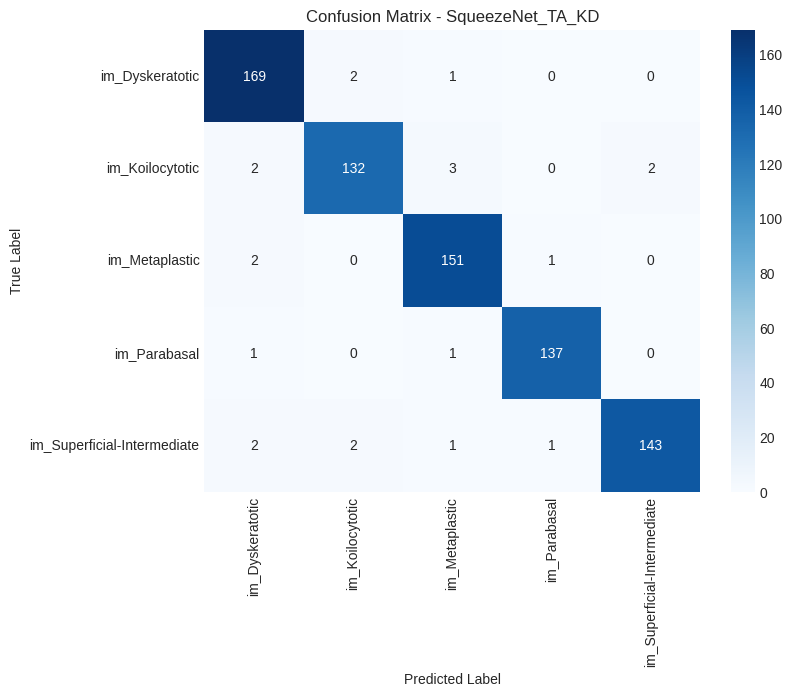

SqueezeNet_TA_KD Accuracy: 0.9721
Evaluation call commented out.


In [ ]:
# --- Main Execution (Using 11-Model Weighted Teacher) ---

# Using SqueezeNet as the TA, loading its fine-tuned weights as starting point
print("\n--- Loading Fine-tuned SqueezeNet 1.1 as TA Model ---")
model_ta = None 
try:
    load_path_squeeze = os.path.join(MODEL_SAVE_DIR, 'SqueezeNet1.1_DiffLR_best.pth') 
    model_ta = models.squeezenet1_1(weights=None) 
    model_ta.num_classes = NUM_CLASSES
    final_conv_in_channels = model_ta.classifier[1].in_channels
    model_ta.classifier[1] = nn.Conv2d(final_conv_in_channels, NUM_CLASSES, kernel_size=1)
    state_dict_squeeze = torch.load(load_path_squeeze, map_location=device, weights_only=True)
    model_ta.load_state_dict(state_dict_squeeze)
    model_ta.to(device)
    print("Fine-tuned SqueezeNet 1.1 loaded successfully as Student model.")
    student_model_loaded = True
except Exception as e:
    print(f"Error loading SqueezeNet Student model: {e}"); traceback.print_exc(); student_model_loaded = False

if student_model_loaded:
    LEARNING_RATE_SQUEEZE_KD = 5e-5 
    print(f"Setting up optimizer for SqueezeNet student (training all parameters) with LR={LEARNING_RATE_SQUEEZE_KD}")
    optimizer_ta = optim.AdamW(model_ta.parameters(), lr=LEARNING_RATE_SQUEEZE_KD, weight_decay=2e-4) 
    scheduler_ta = ReduceLROnPlateau(optimizer_ta, mode='max', factor=0.1, patience=5)

    print("Defining Teacher List (ensure all model variables exist and are loaded)...")
    teacher_model_list = (
        model_alexnet_pt, model_resnet50_pt, model_resnet101_pt, model_resnet152_pt,
        model_densenet169_pt, model_densenet201_pt, model_vgg16_pt, model_vgg19_pt,
        model_effnet_pt, model_convnext_pt, model_regnet_pt
    )
  
    print("Calculating teacher weights based on provided accuracies...")
    acc_alex = 0.9668
    acc_r50 = 0.9641
    acc_r101 = 0.9628
    acc_r152 = 0.9615
    acc_dn169 = 0.9681
    acc_dn201 = 0.9602
    acc_vgg16 = 0.9628
    acc_vgg19 = 0.9668
    acc_efn_b3 = 0.9243
    acc_convnext_t = 0.9774
    acc_regnet_y = 0.9588

    accuracies = [
        acc_alex, acc_r50, acc_r101, acc_r152, acc_dn169, acc_dn201,
        acc_vgg16, acc_vgg19, acc_efn_b3, acc_convnext_t, acc_regnet_y
    ]
    acc_sum_all = sum(accuracies)

    if acc_sum_all == 0:  
        print("Error: Sum of teacher accuracies is zero. Cannot calculate weights.") 
        teacher_weight_list = [1.0 / len(accuracies)] * len(accuracies) 
    else:
        teacher_weight_list = [acc / acc_sum_all for acc in accuracies]
                        
    total_weight = sum(teacher_weight_list)
    print(f"Teacher weights sum: {total_weight:.4f}")
    if not np.isclose(total_weight, 1.0):
        print("Normalizing weights slightly...")
        teacher_weight_list = [w / total_weight for w in teacher_weight_list]

    teacher_weight_list = tuple(teacher_weight_list)

    kd_temperature = 4 
    kd_alpha = 0.3      

    print(f"\nStarting KD training for SqueezeNet student with 11-model weighted ensemble teacher...")
    model_ta_trained, history_ta = train_student_model_weighted_teacher(
        student_model=model_ta,        
        teacher_models=teacher_model_list,   
        teacher_weights=teacher_weight_list, 
        student_model_name="SqueezeNet_TA_KD", 
        optimizer=optimizer_ta,
        scheduler=scheduler_ta,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        temperature=kd_temperature,
        alpha=kd_alpha,
        num_epochs=99, 
        patience=30
    )

    print("\n--- Evaluating Trained SqueezeNet TA with KD ---")
    acc_ta = evaluate_model(model_ta_trained, "SqueezeNet_TA_KD", dataloaders['test'], class_names, criterion)
    print(f"SqueezeNet_TA_KD Accuracy: {acc_ta:.4f}")
    print("Evaluation call commented out.")

else:
    print("Skipping KD training because student SqueezeNet model failed to load.")

In [ ]:
y_true_test, y_pred_ta_kd = generate_preds_and_labels(model_ta_trained, "SqueezeNet_TA_KD", test_loader, device)

print("\n--- Calculating Metrics and Confidence Intervals for TA CNN KD ---")
if y_true_test is not None and y_pred_ta_kd is not None:
    if len(y_true_test) == len(y_pred_ta_kd):
        point_estimates, confidence_intervals = bootstrap_metric_ci(
            y_true_test,
            y_pred_ta_kd, 
            calculate_metrics,
            n_bootstraps=N_BOOTSTRAPS, 
            alpha=ALPHA,
            random_state=RANDOM_STATE
        )

        print(f"\nResults for SqueezeNet_TA_KD:")
        if point_estimates and confidence_intervals: 
            for metric, value in point_estimates.items():
                lower, upper = confidence_intervals.get(metric, (np.nan, np.nan))
                print(f"  {metric.capitalize()}: {value:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")
        else:
            print("  Could not calculate metrics or CIs for TA CNN KD.")
    else:
        print(f"Error: Length mismatch between true labels ({len(y_true_test)}) and TA KD predictions ({len(y_pred_ta_kd)}).")
else:
     print("\nSkipping metrics calculation for TA CNN as true labels or predictions are missing.")


--- Getting predictions for model: SqueezeNet_TA_KD ---
Generated 753 predictions for SqueezeNet_TA_KD.

--- Calculating Metrics and Confidence Intervals for TA CNN KD ---
Generating 1000 bootstrap samples...
Bootstrap sampling finished.

Results for SqueezeNet_TA_KD:
  Accuracy: 0.9721 (95% CI: [0.9602, 0.9841])
  Precision: 0.9729 (95% CI: [0.9605, 0.9843])
  Recall: 0.9716 (95% CI: [0.9594, 0.9837])
  F1: 0.9721 (95% CI: [0.9595, 0.9840])



--- Plotting Fine-tuning Histories ---


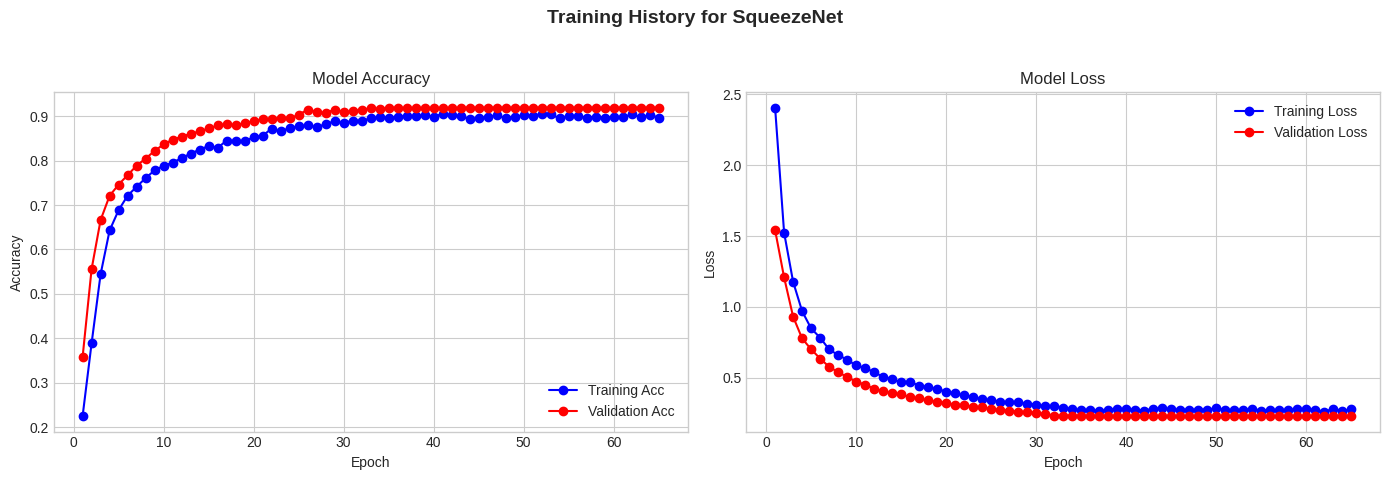

Plot saved as SqueezeNet_training_history.png


In [ ]:
for hist in [history_squeezenet_ft]:
    for key in ['train_acc', 'val_acc']: hist[key] = np.clip(np.asarray(hist[key]), 0, 1)
    for key in ['train_loss', 'val_loss']: hist[key] = np.clip(np.asarray(hist[key]), 0, None)

print("\n--- Plotting Fine-tuning Histories ---")
plot_training_history(history_squeezenet_ft, "SqueezeNet")


--- Plotting Fine-tuning Histories ---


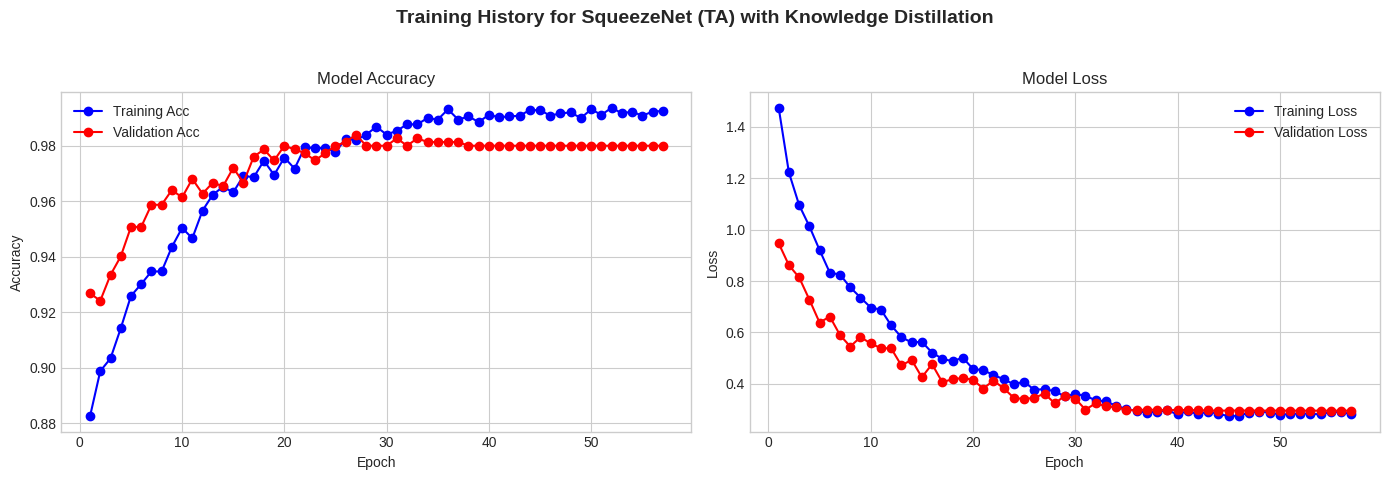

Plot saved as SqueezeNet (TA) with Knowledge Distillation_training_history.png


In [ ]:
for hist in [history_ta]:
    for key in ['train_acc', 'val_acc']: hist[key] = np.clip(np.asarray(hist[key]), 0, 1)
    for key in ['train_loss', 'val_loss']: hist[key] = np.clip(np.asarray(hist[key]), 0, None)

print("\n--- Plotting Fine-tuning Histories ---")
plot_training_history(history_ta, "SqueezeNet (TA) with Knowledge Distillation")

In [ ]:
# For AgileNet only
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
         init.constant_(m.weight, 1)
         init.constant_(m.bias, 0)

In [ ]:
# --- Defining the AgileNet Model ---
class AgileNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AgileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) 

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False) 
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2) 

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2) 

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4096, 64)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.3) 
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
total_params_student = sum(p.numel() for p in model_student.parameters())
trainable_params_student = sum(p.numel() for p in model_student.parameters() if p.requires_grad)
print(f"\n--- Parameter Count for AgileNet ---")
print(f"Total Parameters:     {total_params_student:,}") 
print(f"Trainable Parameters: {trainable_params_student:,}")


--- Parameter Count for AgileNet ---
Total Parameters:     286,229
Trainable Parameters: 286,229



--- Training Student (No KD) ---

--- Training Student ---
Epoch 1/99
----------
Train Loss: 0.9505 Acc: 0.6328
Val Loss: 0.6662 Acc: 0.7500
Validation accuracy improved (0.0000 --> 0.7500). Saving model...
Saved best model weights to /kaggle/working/models/Student_best.pth
Current learning rate: 0.001000
Epoch 2/99
----------
Train Loss: 0.7141 Acc: 0.7382
Val Loss: 0.5226 Acc: 0.8032
Validation accuracy improved (0.7500 --> 0.8032). Saving model...
Saved best model weights to /kaggle/working/models/Student_best.pth
Current learning rate: 0.001000
Epoch 3/99
----------
Train Loss: 0.6156 Acc: 0.7764
Val Loss: 0.5013 Acc: 0.8138
Validation accuracy improved (0.8032 --> 0.8138). Saving model...
Saved best model weights to /kaggle/working/models/Student_best.pth
Current learning rate: 0.001000
Epoch 4/99
----------
Train Loss: 0.5476 Acc: 0.8009
Val Loss: 0.4152 Acc: 0.8551
Validation accuracy improved (0.8138 --> 0.8551). Saving model...
Saved best model weights to /kaggle/working/mode

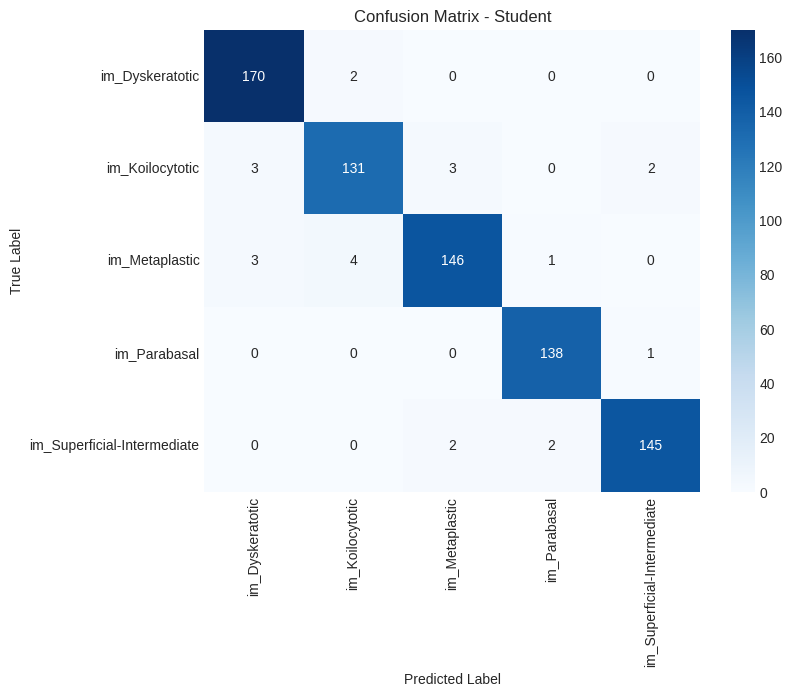


Accuracy for Student architecture: 0.9695


In [ ]:
# --- Train Student (Without Knowledge Distillation) ---
print("\n--- Training Student (No KD) ---")

model_student = AgileNet(num_classes=NUM_CLASSES)


model_student.apply(initialize_weights)
model_student.to(device)

optimizer_student = optim.Adam(model_student.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler_student = ReduceLROnPlateau(optimizer_student, mode='max', factor=0.1, patience=5)

criterion_student = nn.CrossEntropyLoss()

model_name = "Student"
model_student, history_student = train_model(
    model=model_student,
    model_name=model_name,
    criterion=criterion_student,
    optimizer=optimizer_student,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    scheduler=scheduler_student,
    num_epochs=99, 
    patience=30 
)

print(f"\n--- Evaluating {model_name} ---")

acc_student = evaluate_model(
    model=model_student, 
    model_name=model_name,
    loader=dataloaders['test'],
    class_names=class_names,
    criterion=criterion_student
)

print(f"\nAccuracy for Student architecture: {acc_student:.4f}")

In [ ]:
y_true_test, y_pred_student = generate_preds_and_labels(model_student, "Student", test_loader, device)

print("\n--- Calculating Metrics and Confidence Intervals for TA CNN ---")
if y_true_test is not None and y_pred_student is not None: 
    if len(y_true_test) == len(y_pred_student):
        point_estimates, confidence_intervals = bootstrap_metric_ci(
            y_true_test,
            y_pred_student, 
            calculate_metrics, 
            n_bootstraps=N_BOOTSTRAPS, 
            alpha=ALPHA,
            random_state=RANDOM_STATE
        )

        print(f"\nResults for Student No KD:")
        if point_estimates and confidence_intervals: 
            for metric, value in point_estimates.items():
                lower, upper = confidence_intervals.get(metric, (np.nan, np.nan))
                print(f"  {metric.capitalize()}: {value:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")
        else:
            print("  Could not calculate metrics or CIs for TA CNN.")
    else:
        print(f"Error: Length mismatch between true labels ({len(y_true_test)}) and TA predictions ({len(y_pred_student)}).")
else:
     print("\nSkipping metrics calculation for TA CNN as true labels or predictions are missing.")


--- Getting predictions for model: Student ---
Generated 753 predictions for Student.

--- Calculating Metrics and Confidence Intervals for TA CNN ---
Generating 1000 bootstrap samples...
Bootstrap sampling finished.

Results for Student No KD:
  Accuracy: 0.9695 (95% CI: [0.9575, 0.9814])
  Precision: 0.9695 (95% CI: [0.9573, 0.9811])
  Recall: 0.9690 (95% CI: [0.9567, 0.9809])
  F1: 0.9692 (95% CI: [0.9568, 0.9810])


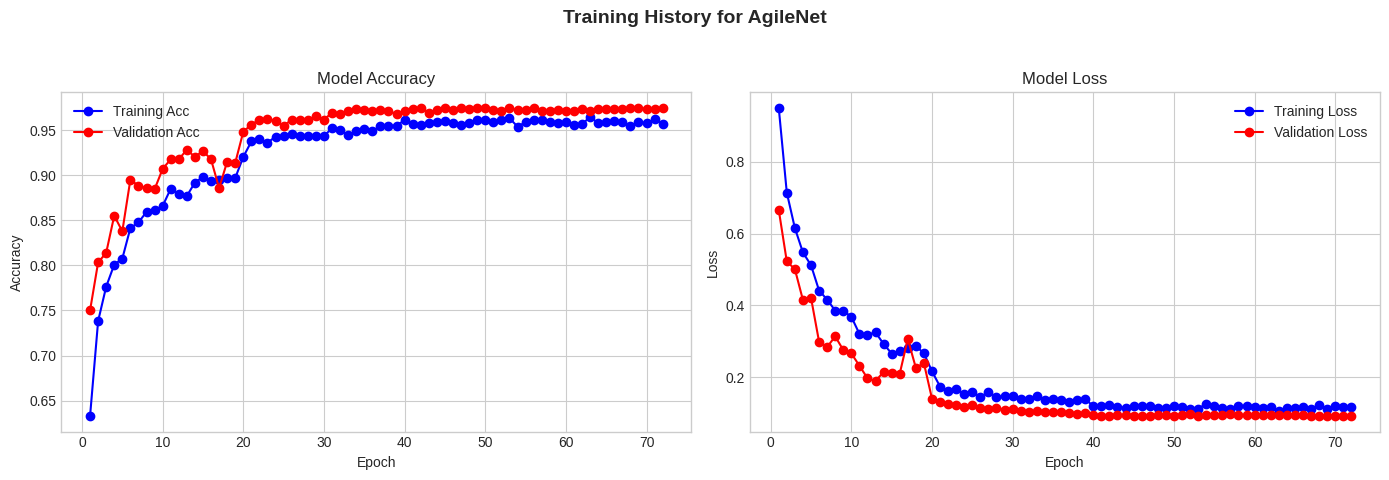

Plot saved as AgileNet_training_history.png


In [ ]:
for hist in [history_student]:
    for key in ['train_acc', 'val_acc']: hist[key] = np.clip(np.asarray(hist[key]), 0, 1)
    for key in ['train_loss', 'val_loss']: hist[key] = np.clip(np.asarray(hist[key]), 0, None)

plot_training_history(history_student, "AgileNet")


Starting KD training with Teacher Assistant

--- Training Student: Agile_Student_KD with Teacher: SqueezeNet ---
Epoch 1/99
----------
Train Loss: 3.6570 Acc: 0.6405
Val Loss: 2.3566 Acc: 0.7540
Validation accuracy improved (0.0000 --> 0.7540). Saving model...
Current learning rate: 0.001000
Epoch 2/99
----------
Train Loss: 2.4887 Acc: 0.7570
Val Loss: 1.9239 Acc: 0.7846
Validation accuracy improved (0.7540 --> 0.7846). Saving model...
Current learning rate: 0.001000
Epoch 3/99
----------
Train Loss: 2.0338 Acc: 0.7915
Val Loss: 1.7587 Acc: 0.8125
Validation accuracy improved (0.7846 --> 0.8125). Saving model...
Current learning rate: 0.001000
Epoch 4/99
----------
Train Loss: 1.7872 Acc: 0.8236
Val Loss: 1.1923 Acc: 0.8644
Validation accuracy improved (0.8125 --> 0.8644). Saving model...
Current learning rate: 0.001000
Epoch 5/99
----------
Train Loss: 1.6483 Acc: 0.8316
Val Loss: 1.2345 Acc: 0.8657
Validation accuracy improved (0.8644 --> 0.8657). Saving model...
Current learning r

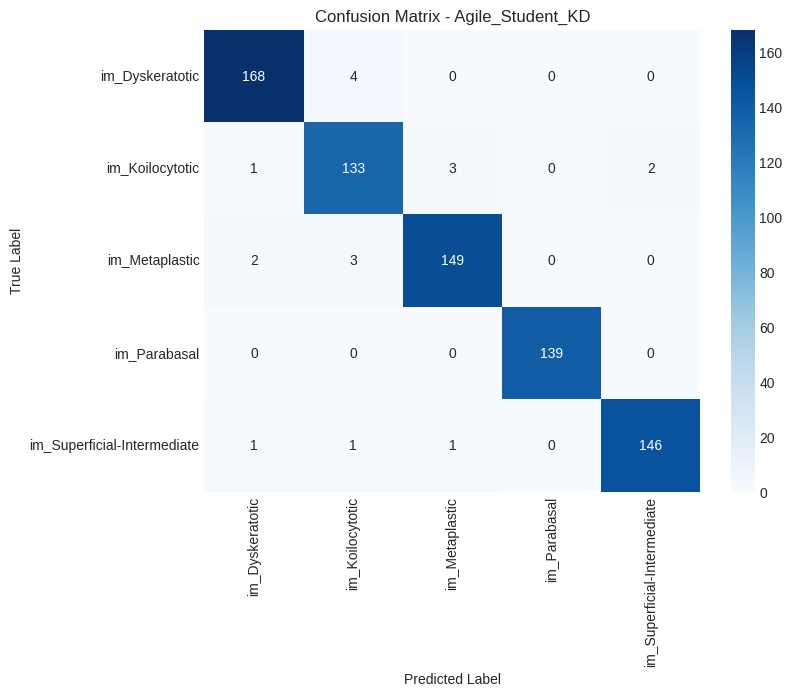

Student KD Accuracy: 0.9761


In [ ]:
# --- Main Execution ---

model_student_kd = AgileNet(num_classes=NUM_CLASSES)
model_student_kd.apply(initialize_weights)
model_student_kd.to(device)

optimizer_student_kd = optim.Adam(model_student_kd.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_student_kd = ReduceLROnPlateau(optimizer_student, mode='max', factor=0.1, patience=5)

best_teacher_model = model_ta_trained 

kd_temperature = 4.0 
kd_alpha = 0.5       

print(f"\nStarting KD training with Teacher Assistant")
model_student_kd, history_student_kd = train_student_model_single_teacher(
    student_model=model_student_kd,
    teacher_model=best_teacher_model,
    student_model_name=f"Agile_Student_KD", 
    optimizer=optimizer_student_kd,
    scheduler=scheduler_student_kd,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    temperature=kd_temperature,
    alpha=kd_alpha,
    num_epochs=99,
    patience=30
)
print("\n--- Evaluating Trained Student KD ---")
acc_student_kd = evaluate_model(model_student_kd, "Agile_Student_KD", dataloaders['test'], class_names, criterion)
print(f"Student KD Accuracy: {acc_student_kd:.4f}")

In [ ]:
y_true_test, y_pred_student_kd = generate_preds_and_labels(model_student_kd, "Agile Student KD", test_loader, device)

print("\n--- Calculating Metrics and Confidence Intervals for Student CNN KD ---")
if y_true_test is not None and y_pred_student_kd is not None: 
    if len(y_true_test) == len(y_pred_student_kd):
        point_estimates, confidence_intervals = bootstrap_metric_ci(
            y_true_test,
            y_pred_student_kd, 
            calculate_metrics, 
            n_bootstraps=N_BOOTSTRAPS,
            alpha=ALPHA,
            random_state=RANDOM_STATE
        )

        print(f"\nResults for Agile Student KD:")
        if point_estimates and confidence_intervals: 
            for metric, value in point_estimates.items():
                lower, upper = confidence_intervals.get(metric, (np.nan, np.nan))
                print(f"  {metric.capitalize()}: {value:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")
        else:
            print("  Could not calculate metrics or CIs for Student CNN KD.")
    else:
        print(f"Error: Length mismatch between true labels ({len(y_true_test)}) and Agile Student KD predictions ({len(y_pred_student_kd)}).")
else:
     print("\nSkipping metrics calculation for Student CNN KD as true labels or predictions are missing.")


--- Getting predictions for model: Agile Student KD ---
Generated 753 predictions for Agile Student KD.

--- Calculating Metrics and Confidence Intervals for Student CNN KD ---
Generating 1000 bootstrap samples...
Bootstrap sampling finished.

Results for Agile Student KD:
  Accuracy: 0.9761 (95% CI: [0.9641, 0.9867])
  Precision: 0.9761 (95% CI: [0.9640, 0.9864])
  Recall: 0.9762 (95% CI: [0.9645, 0.9867])
  F1: 0.9761 (95% CI: [0.9642, 0.9866])


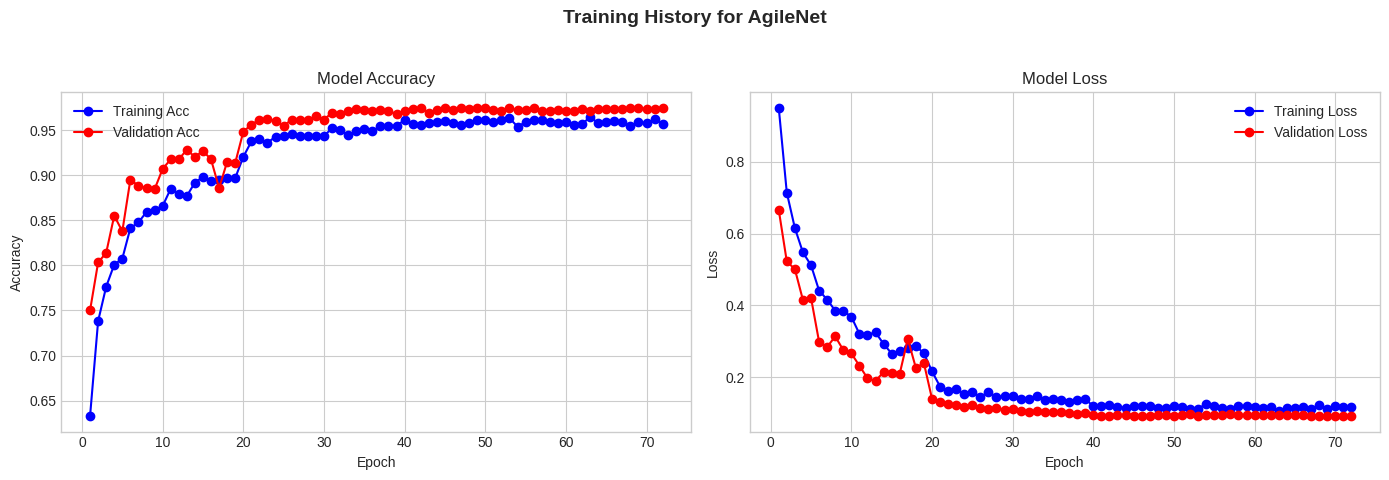

Plot saved as AgileNet_training_history.png


In [ ]:
for hist in [history_student]:
    for key in ['train_acc', 'val_acc']: hist[key] = np.clip(np.asarray(hist[key]), 0, 1)
    for key in ['train_loss', 'val_loss']: hist[key] = np.clip(np.asarray(hist[key]), 0, None)

plot_training_history(history_student, "AgileNet")

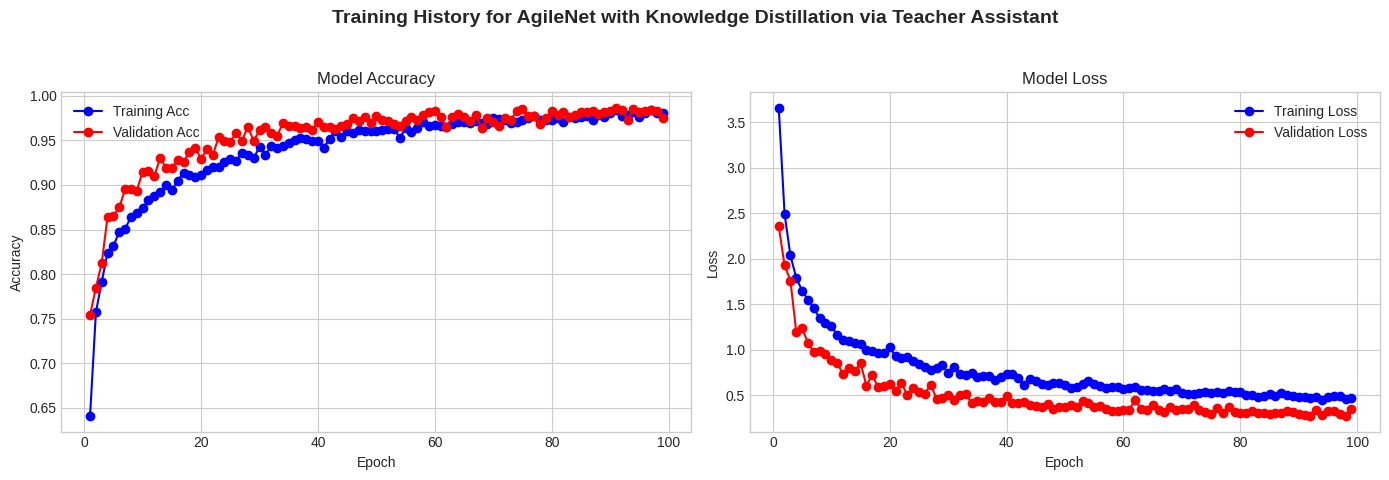

Plot saved as AgileNet with Knowledge Distillation via Teacher Assistant_training_history.png


In [ ]:
for hist in [history_student_kd]:
    for key in ['train_acc', 'val_acc']: hist[key] = np.clip(np.asarray(hist[key]), 0, 1)
    for key in ['train_loss', 'val_loss']: hist[key] = np.clip(np.asarray(hist[key]), 0, None)

plot_training_history(history_student_kd, "AgileNet with Knowledge Distillation via Teacher Assistant")

Converting accuracy data...
Data conversion finished.


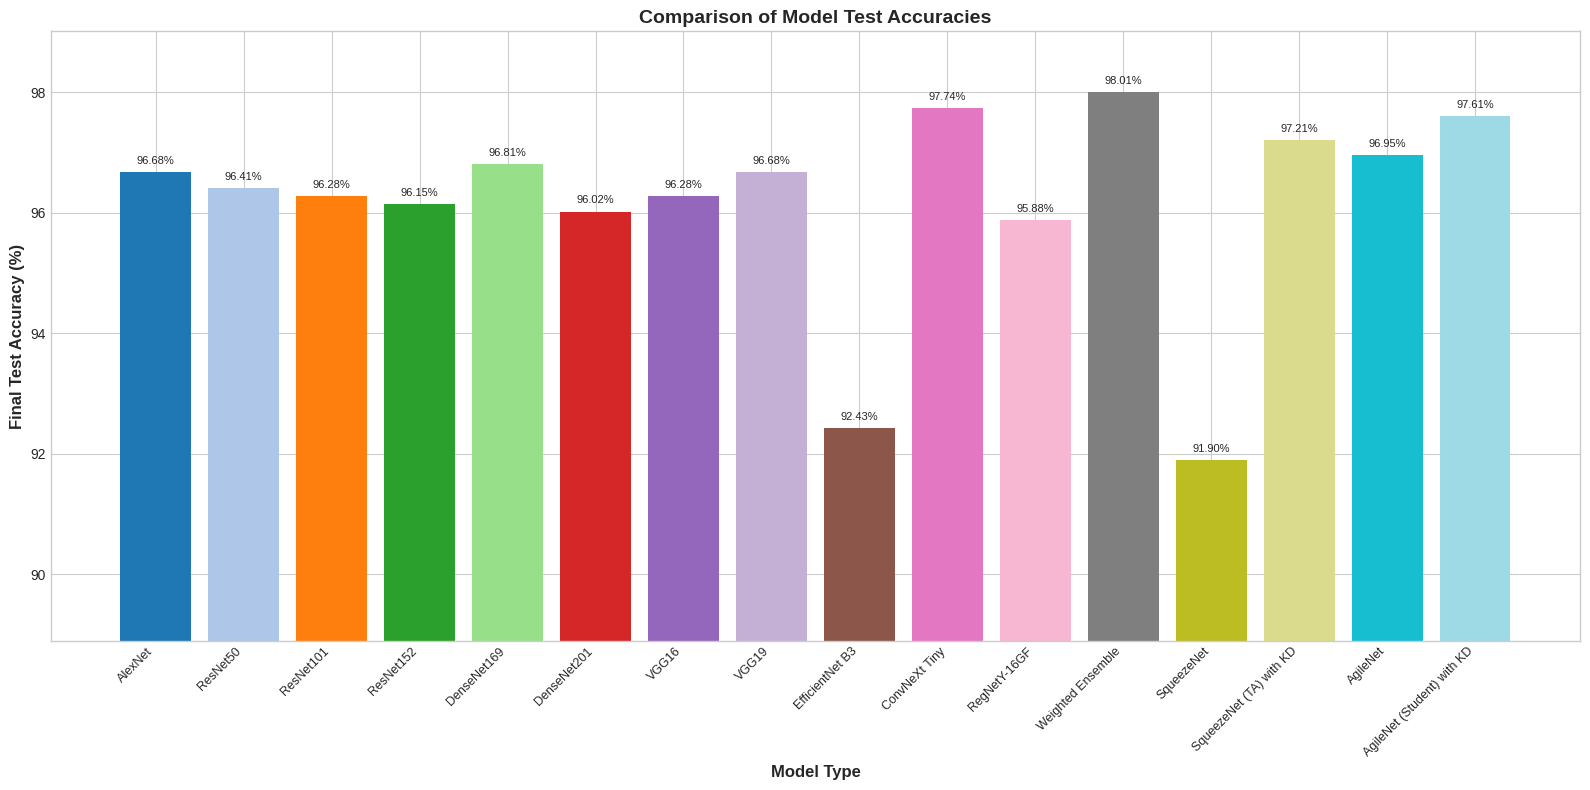

Plot saved as model_accuracy_comparison_barplot_distinct.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import matplotlib 

model_names = [
    'AlexNet',
    'ResNet50',
    'ResNet101',
    'ResNet152',
    'DenseNet169',
    'DenseNet201',
    'VGG16',
    'VGG19',
    'EfficientNet B3',
    'ConvNeXt Tiny',
    'RegNetY-16GF',
    'Weighted Ensemble', 
    'SqueezeNet',        
    'SqueezeNet (TA) with KD', 
    'AgileNet',          
    'AgileNet (Student) with KD' 
]

acc_alex = torch.tensor(0.9668, device='cuda:0') 
acc_r50 = torch.tensor(0.9641, device='cuda:0') 
acc_r101 = torch.tensor(0.9628, device='cuda:0') 
acc_r152 = torch.tensor(0.9615, device='cuda:0') 
acc_dn169 = torch.tensor(0.9681, device='cuda:0') 
acc_dn201 = torch.tensor(0.9602, device='cuda:0') 
acc_vgg16 = torch.tensor(0.9628, device='cuda:0') 
acc_vgg19 = torch.tensor(0.9668, device='cuda:0') 
acc_efn_b3 = torch.tensor(0.9243, device='cuda:0') 
acc_convnext_t = torch.tensor(0.9774, device='cuda:0') 
acc_regnet_y = torch.tensor(0.9588, device='cuda:0') 
acc_ensemble = torch.tensor(0.9801, device='cuda:0') 
acc_squeezenet = torch.tensor(0.9190, device='cuda:0') 
acc_ta = torch.tensor(0.9721, device='cuda:0') 
acc_agilenet = torch.tensor(0.9695, device='cuda:0') 
acc_student = torch.tensor(0.9761, device='cuda:0') 

accuracies_raw = [
    acc_alex, acc_r50, acc_r101, acc_r152, acc_dn169, acc_dn201,
    acc_vgg16, acc_vgg19, acc_efn_b3, acc_convnext_t, acc_regnet_y,
    acc_ensemble, acc_squeezenet, acc_ta, acc_agilenet, acc_student
]

accuracies_cpu = []
print("Converting accuracy data...")
for i, acc in enumerate(accuracies_raw):
    model_id = model_names[i] if i < len(model_names) else f"Index {i}"
    if torch.is_tensor(acc):
        try:
            accuracies_cpu.append(acc.item()) 
        except Exception as e:
            print(f"Error converting tensor for {model_id}: {e}. Appending NaN.")
            accuracies_cpu.append(np.nan) 
    elif isinstance(acc, (int, float)):
         accuracies_cpu.append(float(acc)) 
    else:
        print(f"Warning: Unexpected data type for {model_id}: {type(acc)}. Appending NaN.")
        accuracies_cpu.append(np.nan) 
print("Data conversion finished.")


if len(model_names) != len(accuracies_cpu):
    print(f"Error: Length mismatch. Model names: {len(model_names)}, Accuracies: {len(accuracies_cpu)}.")
else:
    accuracies_percent = [acc * 100 if not np.isnan(acc) else 0 for acc in accuracies_cpu]

    plt.style.use('seaborn-v0_8-whitegrid') 
    fig, ax = plt.subplots(figsize=(16, 8)) 

    num_models = len(model_names)
    cmap = matplotlib.colormaps['tab20'] 
 
    colors = cmap(np.linspace(0, 1, num_models))

    bars = ax.bar(model_names, accuracies_percent, color=colors) 
    ax.set_xlabel('Model Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Final Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Comparison of Model Test Accuracies', fontsize=14, fontweight='bold')
    valid_accuracies_percent = [acc for acc in accuracies_percent if acc > 0]
    min_acc_perc = min(valid_accuracies_percent) if valid_accuracies_percent else 90
    max_acc_perc = max(valid_accuracies_percent) if valid_accuracies_percent else 100

    ax.set_ylim([max(0, min_acc_perc - 3), min(100.5, max_acc_perc + 1)])
    for bar in bars:
        yval = bar.get_height()
        if yval > 0:
             plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f'{yval:.2f}%', va='bottom', ha='center', fontsize=8) 

    plt.xticks(rotation=45, ha='right', fontsize=9) 
    ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout() 
    plt.show()

    fig.savefig('model_accuracy_comparison_barplot_distinct.png', dpi=300)
    print("Plot saved as model_accuracy_comparison_barplot_distinct.png")


--- Finding candidate sample images per class from the test set ---
Found first candidate for class 'im_Dyskeratotic' (0) at original index 697
Found first candidate for class 'im_Superficial-Intermediate' (4) at original index 4551
Found first candidate for class 'im_Koilocytotic' (1) at original index 1222
Found first candidate for class 'im_Parabasal' (3) at original index 4028
Found first candidate for class 'im_Metaplastic' (2) at original index 2791

--- Generating Grad-CAM++ for one CORRECTLY CLASSIFIED sample per class (AgileNet) ---
Attempting to load weights from: /kaggle/working/models/Student_best.pth
AgileNet model loaded successfully.
Using target layer for Grad-CAM++: Conv2d (conv3)

--- Searching for correctly classified sample for True Class: im_Dyskeratotic (0) ---
  Found correctly classified sample: 112_02.bmp (Index: 697)
  True Label:      im_Dyskeratotic (0)
  Predicted Label: im_Dyskeratotic (0)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.985

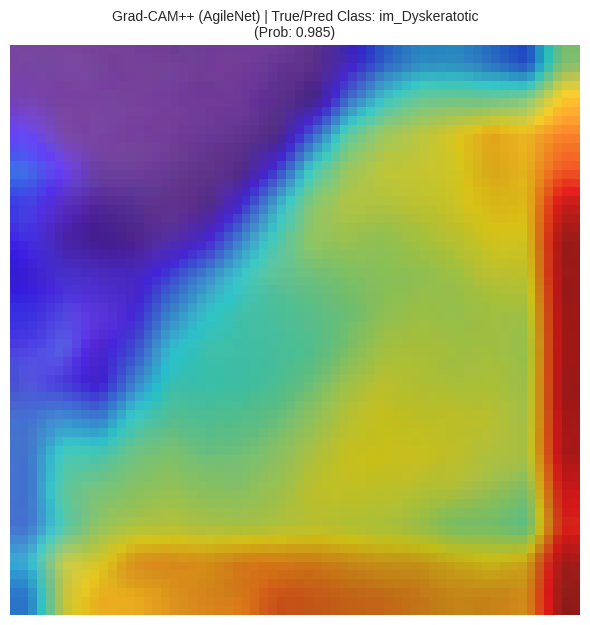


--- Searching for correctly classified sample for True Class: im_Koilocytotic (1) ---
  Found correctly classified sample: 187.bmp (Index: 1222)
  True Label:      im_Koilocytotic (1)
  Predicted Label: im_Koilocytotic (1)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.0002
    Class 'im_Koilocytotic' (1): 0.9998 <--- Predicted
    Class 'im_Metaplastic' (2): 0.0000
    Class 'im_Parabasal' (3): 0.0000
    Class 'im_Superficial-Intermediate' (4): 0.0000
  Generating Grad-CAM++ explaining prediction (im_Koilocytotic)...
    Successfully generated Grad-CAM++.
  Plot saved as AgileNet_gradcampp_correct_class_1.png


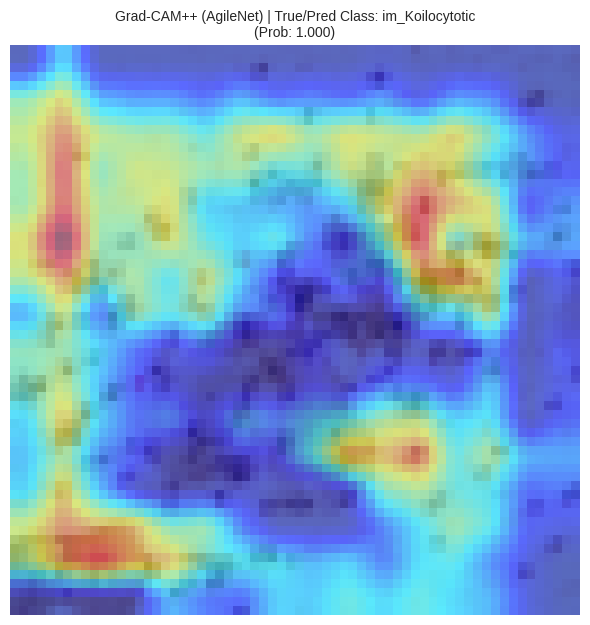


--- Searching for correctly classified sample for True Class: im_Metaplastic (2) ---
  Found correctly classified sample: 140_03.bmp (Index: 2791)
  True Label:      im_Metaplastic (2)
  Predicted Label: im_Metaplastic (2)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.0000
    Class 'im_Koilocytotic' (1): 0.0004
    Class 'im_Metaplastic' (2): 0.9700 <--- Predicted
    Class 'im_Parabasal' (3): 0.0260
    Class 'im_Superficial-Intermediate' (4): 0.0036
  Generating Grad-CAM++ explaining prediction (im_Metaplastic)...
    Successfully generated Grad-CAM++.
  Plot saved as AgileNet_gradcampp_correct_class_2.png


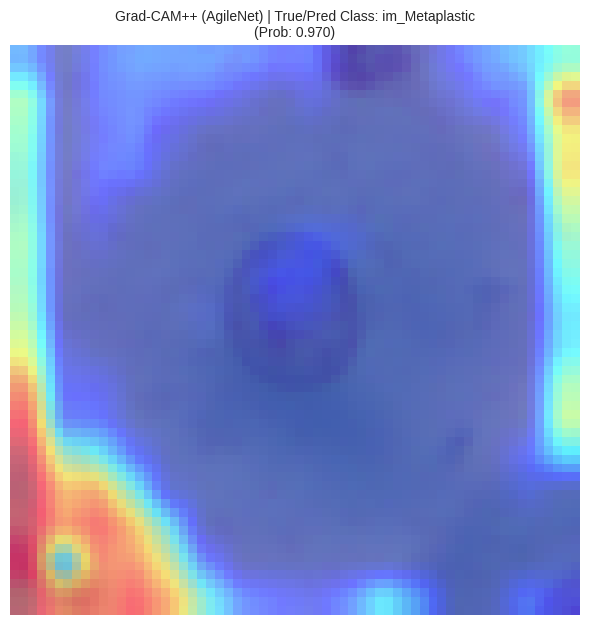


--- Searching for correctly classified sample for True Class: im_Parabasal (3) ---
  Found correctly classified sample: 102_08.bmp (Index: 4028)
  True Label:      im_Parabasal (3)
  Predicted Label: im_Parabasal (3)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.0000
    Class 'im_Koilocytotic' (1): 0.0000
    Class 'im_Metaplastic' (2): 0.0006
    Class 'im_Parabasal' (3): 0.9994 <--- Predicted
    Class 'im_Superficial-Intermediate' (4): 0.0000
  Generating Grad-CAM++ explaining prediction (im_Parabasal)...
    Successfully generated Grad-CAM++.
  Plot saved as AgileNet_gradcampp_correct_class_3.png


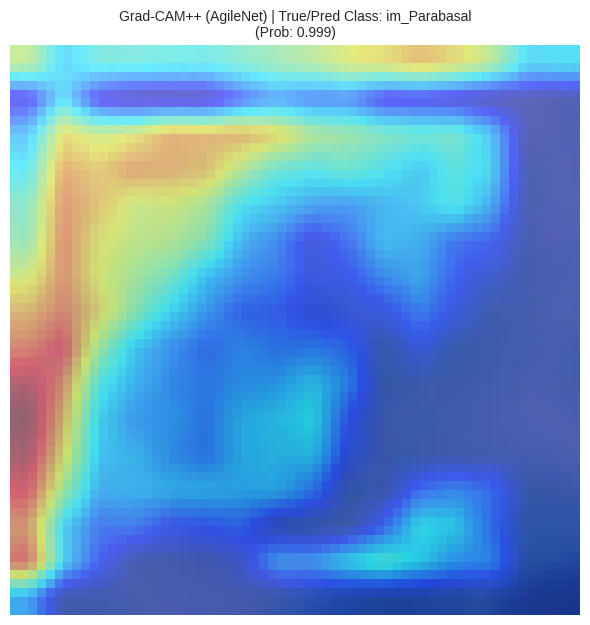


--- Searching for correctly classified sample for True Class: im_Superficial-Intermediate (4) ---
  Found correctly classified sample: 055_07.bmp (Index: 4551)
  True Label:      im_Superficial-Intermediate (4)
  Predicted Label: im_Superficial-Intermediate (4)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.0000
    Class 'im_Koilocytotic' (1): 0.0155
    Class 'im_Metaplastic' (2): 0.3132
    Class 'im_Parabasal' (3): 0.0027
    Class 'im_Superficial-Intermediate' (4): 0.6686 <--- Predicted
  Generating Grad-CAM++ explaining prediction (im_Superficial-Intermediate)...
    Successfully generated Grad-CAM++.
  Plot saved as AgileNet_gradcampp_correct_class_4.png


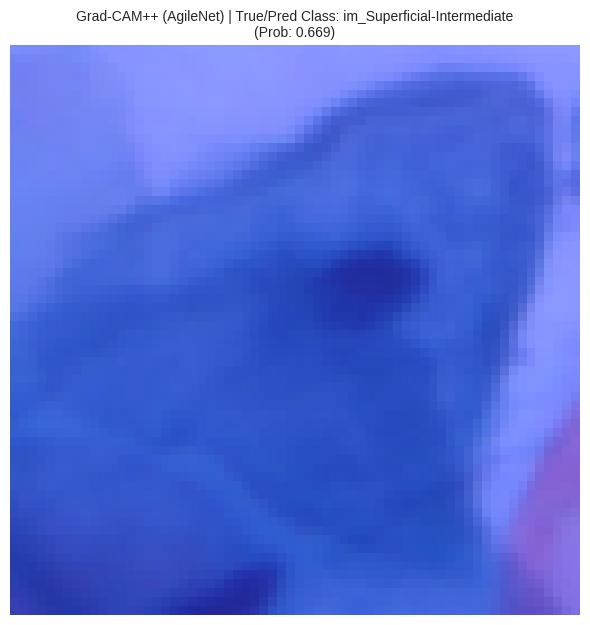


Finished. Visualizations generated for 5 correctly classified classes.


In [ ]:
from pytorch_grad_cam import GradCAM
# --- Helper Function for Visualization ---
def generate_gradcam_visualization(model, target_layer, input_tensor, target_category=None):
    """
    Generates a Grad-CAM++ visualization for a given model and input.
    Handles de-normalization of the input tensor for correct visualization.

    Args:
        model (torch.nn.Module): The model (on correct device).
        target_layer (torch.nn.Module): The target convolutional layer.
        input_tensor (torch.Tensor): Input image tensor ([1, C, H, W], on correct device, NORMALIZED).
        target_category (int, optional): Target class index. None for predicted class.

    Returns:
        np.ndarray: Image with Grad-CAM++ heatmap overlay.
    """
    model.eval()
    targets = None
    if target_category is not None:
        targets = [ClassifierOutputTarget(target_category)]

    with GradCAMPlusPlus(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :] 

        img_tensor_chw = input_tensor.detach().squeeze(0).cpu()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        mean_tensor = torch.tensor(mean).view(3, 1, 1)
        std_tensor = torch.tensor(std).view(3, 1, 1)
        img_denorm_chw = img_tensor_chw * std_tensor + mean_tensor
        rgb_img_for_viz = img_denorm_chw.permute(1, 2, 0).numpy()
        rgb_img_for_viz = np.clip(rgb_img_for_viz, 0, 1)
        rgb_img_for_viz = rgb_img_for_viz.astype(np.float32)
        cam_image = show_cam_on_image(rgb_img_for_viz, grayscale_cam, use_rgb=True, image_weight=0.5)

    return cam_image

print("\n--- Finding candidate sample images per class from the test set ---")
sample_indices_per_class = {}
found_classes = set()
original_dataset = test_dataset.dataset if hasattr(test_dataset, 'dataset') else test_dataset

for idx_in_test_split, original_idx in enumerate(test_indices):
    try:
        _, true_label_idx = original_dataset.samples[original_idx]
        if true_label_idx not in sample_indices_per_class:
            sample_indices_per_class[true_label_idx] = []
        if len(sample_indices_per_class[true_label_idx]) < 5: 
             sample_indices_per_class[true_label_idx].append(original_idx)
             if true_label_idx not in found_classes:
                 found_classes.add(true_label_idx)
                 print(f"Found first candidate for class '{class_names[true_label_idx]}' ({true_label_idx}) at original index {original_idx}")
        if len(found_classes) == NUM_CLASSES and all(len(v) >= 1 for v in sample_indices_per_class.values()): 
             pass

    except IndexError: print(f"Warning: Index {original_idx} out of bounds."); continue
    except Exception as e: print(f"Warning: Error processing index {original_idx}: {e}"); continue

if len(found_classes) != NUM_CLASSES:
    print(f"\nWarning: Could only find candidate samples for {len(found_classes)} / {NUM_CLASSES} classes.")

if sample_indices_per_class:
    print("\n--- Generating Grad-CAM++ for one CORRECTLY CLASSIFIED sample per class (AgileNet) ---")

    model_xai = None
    try:
        agilenet_weights_filename = 'Student_best.pth' 
        load_path = os.path.join(MODEL_SAVE_DIR, agilenet_weights_filename)

        model_xai = AgileNet(num_classes=NUM_CLASSES).to(device) 
        print(f"Attempting to load weights from: {load_path}")
        state_dict = torch.load(load_path, map_location=device, weights_only=True)
        model_xai.load_state_dict(state_dict)
        model_xai.eval()
        print("AgileNet model loaded successfully.")
    except FileNotFoundError:
         print(f"Error: AgileNet weights file not found at {load_path}. Aborting XAI.")
         model_xai = None
    except Exception as e:
        print(f"Error loading AgileNet model: {e}. Aborting XAI.")
        model_xai = None
    target_layer = None
    if model_xai:
        try:
             target_layer = model_xai.conv3 
             print(f"Using target layer for Grad-CAM++: {target_layer.__class__.__name__} (conv3)")
        except AttributeError:
             print("Error: Could not find target layer 'conv3' in AgileNet. Aborting XAI.")
             target_layer = None

    if model_xai and target_layer:
        correct_samples_visualized = set()
        for true_cls_idx_target in range(NUM_CLASSES):
            if true_cls_idx_target not in sample_indices_per_class or not sample_indices_per_class[true_cls_idx_target]:
                print(f"\n--- No candidates found for True Class: {class_names[true_cls_idx_target]} ({true_cls_idx_target}). Skipping. ---")
                continue

            print(f"\n--- Searching for correctly classified sample for True Class: {class_names[true_cls_idx_target]} ({true_cls_idx_target}) ---")
            found_correct_sample = False
            for original_idx in sample_indices_per_class[true_cls_idx_target]:
                try:
                    sample_path, _ = original_dataset.samples[original_idx]
                    pil_img = Image.open(sample_path).convert('RGB')
                    
                    tensor_img_for_model = val_test_transforms(pil_img).unsqueeze(0).to(device)

                    with torch.no_grad():
                        output = model_xai(tensor_img_for_model)
                        probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()
                        pred_idx = np.argmax(probabilities)

                    if pred_idx == true_cls_idx_target:
                        print(f"  Found correctly classified sample: {os.path.basename(sample_path)} (Index: {original_idx})")
                        print(f"  True Label:      {class_names[true_cls_idx_target]} ({true_cls_idx_target})")
                        print(f"  Predicted Label: {class_names[pred_idx]} ({pred_idx})")
                        print("  Prediction Probabilities:")
                        if probabilities is not None and len(probabilities) == NUM_CLASSES:
                             for i, prob in enumerate(probabilities):
                                  highlight = " <--- Predicted" if i == pred_idx else ""
                                  print(f"    Class '{class_names[i]}' ({i}): {prob:.4f}{highlight}")
                        else:
                             print("    Could not retrieve valid probabilities.")

                        print(f"  Generating Grad-CAM++ explaining prediction ({class_names[pred_idx]})...")
                        vis_cam = generate_gradcam_visualization(
                            model=model_xai,
                            target_layer=target_layer,
                            input_tensor=tensor_img_for_model.clone(), 
                            target_category=pred_idx,
                        )
                        print(f"    Successfully generated Grad-CAM++.")
                        plt.figure(figsize=(6, 7))
                        plt.imshow(vis_cam) 
                        title = (f'Grad-CAM++ (AgileNet) | True/Pred Class: {class_names[true_cls_idx_target]}\n'
                                 f'(Prob: {probabilities[pred_idx]:.3f})')
                        plt.title(title, fontsize=10)
                        plt.axis('off')
                        plt.tight_layout()
                        save_filename = f'AgileNet_gradcampp_correct_class_{true_cls_idx_target}.png'
                        plt.savefig(save_filename)
                        print(f"  Plot saved as {save_filename}")
                        plt.show()
                        plt.close()

                        found_correct_sample = True
                        correct_samples_visualized.add(true_cls_idx_target)
                        break 

                except Exception as e:
                    if "should np.float32 in the range [0, 1]" in str(e):
                         print(f"  Error visualizing sample (Index {original_idx}): {e}")
                         print("    >> Check de-normalization logic in generate_gradcam_visualization.")
                    else:
                         print(f"  Error processing candidate sample (Index {original_idx}) for class {true_cls_idx_target}: {e}")
                         traceback.print_exc()
                    continue

            if not found_correct_sample:
                print(f"  Could not find and visualize a correctly classified sample for class {class_names[true_cls_idx_target]}.")

        print(f"\nFinished. Visualizations generated for {len(correct_samples_visualized)} correctly classified classes.")

    else:
         if not model_xai: print("\nSkipping Grad-CAM++: Model failed to load.")
         elif not target_layer: print("\nSkipping Grad-CAM++: Target layer not found.")

else:
    print("Skipping Grad-CAM++ generation as no sample image candidates were found.")


--- Finding candidate sample images per class from the test set ---
Found first candidate for class 'im_Dyskeratotic' (0) at original index 697
Found first candidate for class 'im_Superficial-Intermediate' (4) at original index 4551
Found first candidate for class 'im_Koilocytotic' (1) at original index 1222
Found first candidate for class 'im_Parabasal' (3) at original index 4028
Found first candidate for class 'im_Metaplastic' (2) at original index 2791

--- Generating Grad-CAM++ for one CORRECTLY CLASSIFIED sample per class (AgileNet with KD via TA) ---
Attempting to load weights from: /kaggle/working/models/Agile_Student_KD_best_kd_single.pth
AgileNet model loaded successfully.
Using target layer for Grad-CAM++: Conv2d (conv3)

--- Searching for correctly classified sample for True Class: im_Dyskeratotic (0) ---
  Found correctly classified sample: 112_02.bmp (Index: 697)
  True Label:      im_Dyskeratotic (0)
  Predicted Label: im_Dyskeratotic (0)
  Prediction Probabilities:
    

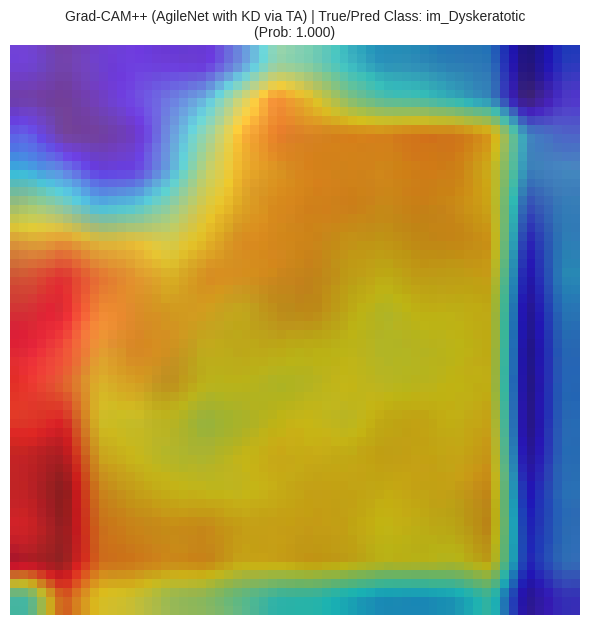


--- Searching for correctly classified sample for True Class: im_Koilocytotic (1) ---
  Found correctly classified sample: 187.bmp (Index: 1222)
  True Label:      im_Koilocytotic (1)
  Predicted Label: im_Koilocytotic (1)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.0089
    Class 'im_Koilocytotic' (1): 0.9905 <--- Predicted
    Class 'im_Metaplastic' (2): 0.0006
    Class 'im_Parabasal' (3): 0.0000
    Class 'im_Superficial-Intermediate' (4): 0.0000
  Generating Grad-CAM++ explaining prediction (im_Koilocytotic)...
    Successfully generated Grad-CAM++.
  Plot saved as AgileNet_gradcampp_correct_class_1.png


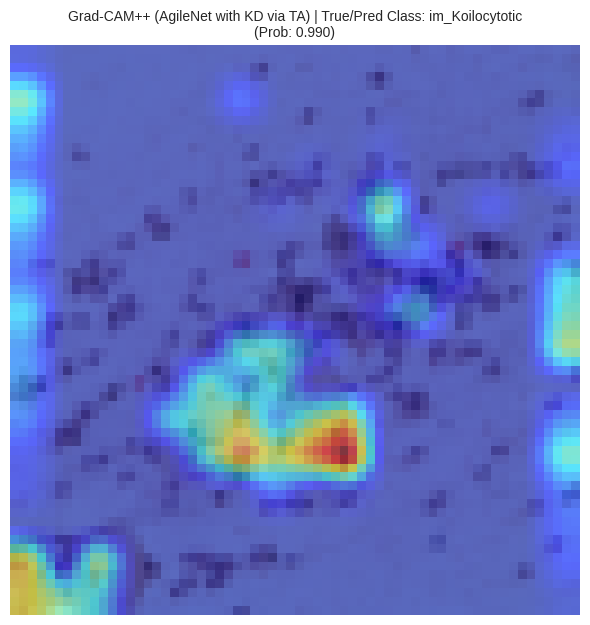


--- Searching for correctly classified sample for True Class: im_Metaplastic (2) ---
  Found correctly classified sample: 140_03.bmp (Index: 2791)
  True Label:      im_Metaplastic (2)
  Predicted Label: im_Metaplastic (2)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.0001
    Class 'im_Koilocytotic' (1): 0.0008
    Class 'im_Metaplastic' (2): 0.9805 <--- Predicted
    Class 'im_Parabasal' (3): 0.0163
    Class 'im_Superficial-Intermediate' (4): 0.0022
  Generating Grad-CAM++ explaining prediction (im_Metaplastic)...
    Successfully generated Grad-CAM++.
  Plot saved as AgileNet_gradcampp_correct_class_2.png


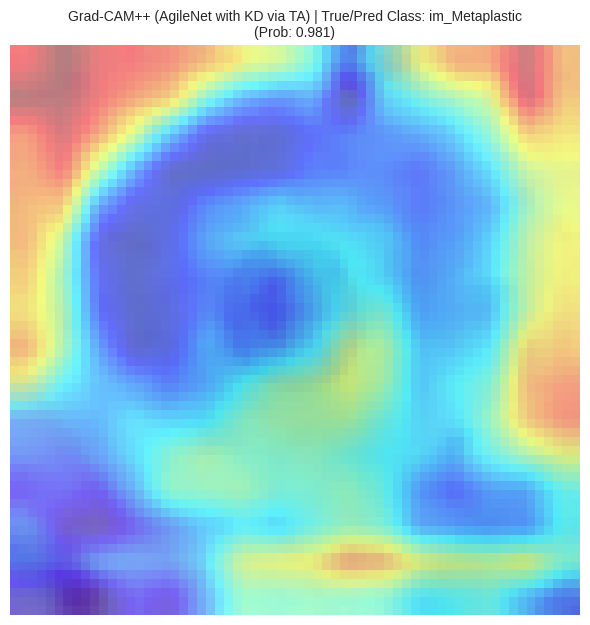


--- Searching for correctly classified sample for True Class: im_Parabasal (3) ---
  Found correctly classified sample: 102_08.bmp (Index: 4028)
  True Label:      im_Parabasal (3)
  Predicted Label: im_Parabasal (3)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.0000
    Class 'im_Koilocytotic' (1): 0.0000
    Class 'im_Metaplastic' (2): 0.0000
    Class 'im_Parabasal' (3): 1.0000 <--- Predicted
    Class 'im_Superficial-Intermediate' (4): 0.0000
  Generating Grad-CAM++ explaining prediction (im_Parabasal)...
    Successfully generated Grad-CAM++.
  Plot saved as AgileNet_gradcampp_correct_class_3.png


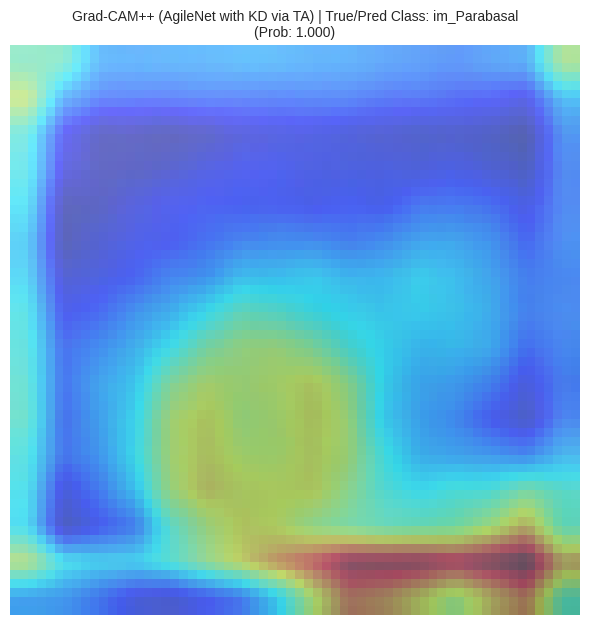


--- Searching for correctly classified sample for True Class: im_Superficial-Intermediate (4) ---
  Found correctly classified sample: 055_07.bmp (Index: 4551)
  True Label:      im_Superficial-Intermediate (4)
  Predicted Label: im_Superficial-Intermediate (4)
  Prediction Probabilities:
    Class 'im_Dyskeratotic' (0): 0.0007
    Class 'im_Koilocytotic' (1): 0.0401
    Class 'im_Metaplastic' (2): 0.1421
    Class 'im_Parabasal' (3): 0.0025
    Class 'im_Superficial-Intermediate' (4): 0.8147 <--- Predicted
  Generating Grad-CAM++ explaining prediction (im_Superficial-Intermediate)...
    Successfully generated Grad-CAM++.
  Plot saved as AgileNet_gradcampp_correct_class_4.png


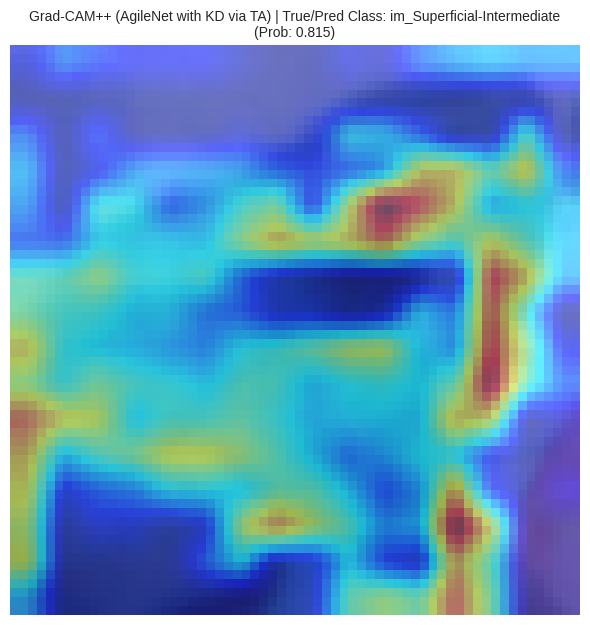


Finished. Visualizations generated for 5 correctly classified classes.


In [ ]:
from pytorch_grad_cam import GradCAM
# --- Helper Function for Visualization ---
def generate_gradcam_visualization(model, target_layer, input_tensor, target_category=None):
    """
    Generates a Grad-CAM++ visualization for a given model and input.
    Handles de-normalization of the input tensor for correct visualization.

    Args:
        model (torch.nn.Module): The model (on correct device).
        target_layer (torch.nn.Module): The target convolutional layer.
        input_tensor (torch.Tensor): Input image tensor ([1, C, H, W], on correct device, NORMALIZED).
        target_category (int, optional): Target class index. None for predicted class.

    Returns:
        np.ndarray: Image with Grad-CAM++ heatmap overlay.
    """
    model.eval()
    targets = None
    if target_category is not None:
        targets = [ClassifierOutputTarget(target_category)]

    with GradCAMPlusPlus(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :] 

        img_tensor_chw = input_tensor.detach().squeeze(0).cpu()

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        mean_tensor = torch.tensor(mean).view(3, 1, 1)
        std_tensor = torch.tensor(std).view(3, 1, 1)

        img_denorm_chw = img_tensor_chw * std_tensor + mean_tensor

        rgb_img_for_viz = img_denorm_chw.permute(1, 2, 0).numpy()

        rgb_img_for_viz = np.clip(rgb_img_for_viz, 0, 1)

        rgb_img_for_viz = rgb_img_for_viz.astype(np.float32)

        cam_image = show_cam_on_image(rgb_img_for_viz, grayscale_cam, use_rgb=True, image_weight=0.5)

    return cam_image

print("\n--- Finding candidate sample images per class from the test set ---")
sample_indices_per_class = {} 
found_classes = set()

original_dataset = test_dataset.dataset if hasattr(test_dataset, 'dataset') else test_dataset

for idx_in_test_split, original_idx in enumerate(test_indices):
    try:
        _, true_label_idx = original_dataset.samples[original_idx]
        if true_label_idx not in sample_indices_per_class:
            sample_indices_per_class[true_label_idx] = []
        if len(sample_indices_per_class[true_label_idx]) < 5:
             sample_indices_per_class[true_label_idx].append(original_idx)
             if true_label_idx not in found_classes:
                 found_classes.add(true_label_idx)
                 print(f"Found first candidate for class '{class_names[true_label_idx]}' ({true_label_idx}) at original index {original_idx}")
        
        if len(found_classes) == NUM_CLASSES and all(len(v) >= 1 for v in sample_indices_per_class.values()):     
             pass

    except IndexError: print(f"Warning: Index {original_idx} out of bounds."); continue
    except Exception as e: print(f"Warning: Error processing index {original_idx}: {e}"); continue

if len(found_classes) != NUM_CLASSES:
    print(f"\nWarning: Could only find candidate samples for {len(found_classes)} / {NUM_CLASSES} classes.")
                     
if sample_indices_per_class:
    print("\n--- Generating Grad-CAM++ for one CORRECTLY CLASSIFIED sample per class (AgileNet with KD via TA) ---")

    model_xai = None
    try:
        agilenet_weights_filename = 'Agile_Student_KD_best_kd_single.pth' 
        load_path = os.path.join(MODEL_SAVE_DIR, agilenet_weights_filename)
        model_xai = AgileNet(num_classes=NUM_CLASSES).to(device)
        print(f"Attempting to load weights from: {load_path}")
        state_dict = torch.load(load_path, map_location=device, weights_only=True)
        model_xai.load_state_dict(state_dict)
        model_xai.eval()
        print("AgileNet model loaded successfully.")
    except FileNotFoundError:
         print(f"Error: AgileNet weights file not found at {load_path}. Aborting XAI.")
         model_xai = None
    except Exception as e:
        print(f"Error loading AgileNet model: {e}. Aborting XAI.")
        model_xai = None

    target_layer = None
    if model_xai:
        try:
             target_layer = model_xai.conv3 
             print(f"Using target layer for Grad-CAM++: {target_layer.__class__.__name__} (conv3)")
        except AttributeError:
             print("Error: Could not find target layer 'conv3' in AgileNet. Aborting XAI.")
             target_layer = None

    if model_xai and target_layer:
        correct_samples_visualized = set()
        for true_cls_idx_target in range(NUM_CLASSES):
            if true_cls_idx_target not in sample_indices_per_class or not sample_indices_per_class[true_cls_idx_target]:
                print(f"\n--- No candidates found for True Class: {class_names[true_cls_idx_target]} ({true_cls_idx_target}). Skipping. ---")
                continue

            print(f"\n--- Searching for correctly classified sample for True Class: {class_names[true_cls_idx_target]} ({true_cls_idx_target}) ---")
            found_correct_sample = False
            for original_idx in sample_indices_per_class[true_cls_idx_target]:
                try:
                    sample_path, _ = original_dataset.samples[original_idx]
                    pil_img = Image.open(sample_path).convert('RGB')
                    tensor_img_for_model = val_test_transforms(pil_img).unsqueeze(0).to(device)

                    with torch.no_grad():
                        output = model_xai(tensor_img_for_model)
                        probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()
                        pred_idx = np.argmax(probabilities)

                    if pred_idx == true_cls_idx_target:
                        print(f"  Found correctly classified sample: {os.path.basename(sample_path)} (Index: {original_idx})")
                        print(f"  True Label:      {class_names[true_cls_idx_target]} ({true_cls_idx_target})")
                        print(f"  Predicted Label: {class_names[pred_idx]} ({pred_idx})")
                        print("  Prediction Probabilities:")
                        if probabilities is not None and len(probabilities) == NUM_CLASSES:
                             for i, prob in enumerate(probabilities):
                                  highlight = " <--- Predicted" if i == pred_idx else ""
                                  print(f"    Class '{class_names[i]}' ({i}): {prob:.4f}{highlight}")
                        else:
                             print("    Could not retrieve valid probabilities.")

                        print(f"  Generating Grad-CAM++ explaining prediction ({class_names[pred_idx]})...")
                        vis_cam = generate_gradcam_visualization(
                            model=model_xai,
                            target_layer=target_layer,
                            input_tensor=tensor_img_for_model.clone(), 
                            target_category=pred_idx,
                        )
                        print(f"    Successfully generated Grad-CAM++.")
                        plt.figure(figsize=(6, 7))
                        plt.imshow(vis_cam) 
                        title = (f'Grad-CAM++ (AgileNet with KD via TA) | True/Pred Class: {class_names[true_cls_idx_target]}\n'
                                 f'(Prob: {probabilities[pred_idx]:.3f})')
                        plt.title(title, fontsize=10)
                        plt.axis('off')
                        plt.tight_layout()
                        save_filename = f'AgileNet_gradcampp_correct_class_{true_cls_idx_target}.png'
                        plt.savefig(save_filename)
                        print(f"  Plot saved as {save_filename}")
                        plt.show()
                        plt.close()

                        found_correct_sample = True
                        correct_samples_visualized.add(true_cls_idx_target)
                        break 

                except Exception as e:
                    if "should np.float32 in the range [0, 1]" in str(e):
                         print(f"  Error visualizing sample (Index {original_idx}): {e}")
                         print("    >> Check de-normalization logic in generate_gradcam_visualization.")
                    else:
                         print(f"  Error processing candidate sample (Index {original_idx}) for class {true_cls_idx_target}: {e}")
                         traceback.print_exc()
                    continue

            if not found_correct_sample:
                print(f"  Could not find and visualize a correctly classified sample for class {class_names[true_cls_idx_target]}.")

        print(f"\nFinished. Visualizations generated for {len(correct_samples_visualized)} correctly classified classes.")

    else:
         if not model_xai: print("\nSkipping Grad-CAM++: Model failed to load.")
         elif not target_layer: print("\nSkipping Grad-CAM++: Target layer not found.")

else:
    print("Skipping Grad-CAM++ generation as no sample image candidates were found.")